<a href="https://colab.research.google.com/github/ryyutku/DSGP/blob/anuk/Modelling/Demand_forecast_model_6_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training models at different stages of EDA**

In [93]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from prophet import Prophet

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [94]:
df = pd.read_csv('CIEC.csv')

In [95]:
df.shape

(262, 21)

In [96]:
df.columns

Index(['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties ',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'New Vehicle Registrations', 'Vehicle Sales', 'Vehicle Sales Asia',
       'No.of Vessels Colombo', 'Imports of Refined Products',
       'Tax income profits_gains', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel'],
      dtype='object')

In [97]:
df['date'] = pd.to_datetime(df['date'])

In [98]:
features = ['date','fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'GDP: Gross National Income', 'Government Debt',
       'New Vehicle Registrations', 'Vehicle Sales', 'Port Stay Duration',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Colombo port calls',
       'Tax income profits_gains', 'Tax on Export', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'Household_income',
       'Fuel_other_manufacture']

In [99]:
df_original = df.copy()

## **Checking the time frame with the most columns available**

In [100]:
print(df.isnull().sum())

date                                         0
fuel_consumption                             0
petroleum_imports_crudeOil                   0
Taxes_on_Customs_and_Other_Import Duties     0
Foreign Direct Investments                   0
GDP Goods and Services                       1
New Vehicle Registrations                    0
Vehicle Sales                                0
Vehicle Sales Asia                           0
No.of Vessels Colombo                        0
Imports of Refined Products                  0
Tax income profits_gains                     0
Tax Goods & Services                         0
Tax Road Transport                           0
GDP FCE Households                           1
Diesel User Price                            0
Petrol User Price                            0
Consumption_Oil                              0
Sales 90 Octane                              0
Sales 95 Octane                              0
Sales Auto Diesel                            0
dtype: int64


In [101]:
len(df.columns)

21

In [102]:
df.dtypes

date                                         datetime64[ns]
fuel_consumption                                    float64
petroleum_imports_crudeOil                          float64
Taxes_on_Customs_and_Other_Import Duties            float64
Foreign Direct Investments                          float64
GDP Goods and Services                              float64
New Vehicle Registrations                           float64
Vehicle Sales                                       float64
Vehicle Sales Asia                                  float64
No.of Vessels Colombo                               float64
Imports of Refined Products                         float64
Tax income profits_gains                            float64
Tax Goods & Services                                float64
Tax Road Transport                                  float64
GDP FCE Households                                  float64
Diesel User Price                                   float64
Petrol User Price                                   float64
Consumption_Oil                                     float64
Sales 90 Octane                                     float64
Sales 95 Octane                                     float64
Sales Auto Diesel                                   float64
dtype: object

# Exploratory Data Analysis

## **Outlier detection**

In [103]:
#Detecting outliers using Zscore
import pandas as pd
import numpy as np
from scipy.stats import zscore

def detect_outliers_zscore(df, feature, threshold=2, time_column='date'):
    df = df.copy()

    # Skip non-numeric columns
    if not np.issubdtype(df[feature].dtype, np.number):
        print(f"Skipping non-numeric column: {feature}")
        return None, df  # Skip non-numeric columns

    # Drop rows with missing values in the feature column
    df = df.dropna(subset=[feature])

    # Calculate Z-scores for the feature
    df['zscore'] = zscore(df[feature])

    # Identify anomalies based on the Z-score threshold
    df[feature + '_isanomaly'] = (df['zscore'].abs() > threshold)

    # Filter anomaly data
    anomalies = df[df[feature + '_isanomaly']]

    # Select numerical output
    anomalies = anomalies[[time_column, feature, 'zscore', feature + '_isanomaly']]

    return anomalies, df



In [104]:
processed_df = df.copy()

for feature in df.columns:
    print("----", feature, "----")
    anomalies, processed_df = detect_outliers_zscore(processed_df, feature=feature, threshold=2)

    if anomalies is not None:
        print(f"Feature: {feature}")
        print(anomalies.head())
    print()

---- date ----
Skipping non-numeric column: date

---- fuel_consumption ----
Feature: fuel_consumption
Empty DataFrame
Columns: [date, fuel_consumption, zscore, fuel_consumption_isanomaly]
Index: []

---- petroleum_imports_crudeOil ----
Feature: petroleum_imports_crudeOil
Empty DataFrame
Columns: [date, petroleum_imports_crudeOil, zscore, petroleum_imports_crudeOil_isanomaly]
Index: []

---- Taxes_on_Customs_and_Other_Import Duties  ----
Feature: Taxes_on_Customs_and_Other_Import Duties 
Empty DataFrame
Columns: [date, Taxes_on_Customs_and_Other_Import Duties , zscore, Taxes_on_Customs_and_Other_Import Duties _isanomaly]
Index: []

---- Foreign Direct Investments ----
Feature: Foreign Direct Investments
Empty DataFrame
Columns: [date, Foreign Direct Investments, zscore, Foreign Direct Investments_isanomaly]
Index: []

---- GDP Goods and Services ----
Feature: GDP Goods and Services
Empty DataFrame
Columns: [date, GDP Goods and Services, zscore, GDP Goods and Services_isanomaly]
Index: 

In [105]:
processed_df.columns

Index(['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties ',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'New Vehicle Registrations', 'Vehicle Sales', 'Vehicle Sales Asia',
       'No.of Vessels Colombo', 'Imports of Refined Products',
       'Tax income profits_gains', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'zscore',
       'fuel_consumption_isanomaly', 'petroleum_imports_crudeOil_isanomaly',
       'Taxes_on_Customs_and_Other_Import Duties _isanomaly',
       'Foreign Direct Investments_isanomaly',
       'GDP Goods and Services_isanomaly',
       'New Vehicle Registrations_isanomaly', 'Vehicle Sales_isanomaly',
       'Vehicle Sales Asia_isanomaly', 'No.of Vessels Colombo_isanomaly',
       'Imports of Refined Products_isanomaly',
    

### **Removing the outliers**

In [106]:
# Removing anomalies
processed_df = processed_df[processed_df['New Vehicle Registrations_isanomaly'] == False]
processed_df = processed_df[processed_df['No.of Vessels Colombo_isanomaly'] == False]
processed_df = processed_df[processed_df['Imports of Refined Products_isanomaly'] == False]
processed_df = processed_df[processed_df['Tax Road Transport_isanomaly'] == False]
processed_df = processed_df[processed_df['Petrol User Price_isanomaly'] == False]
processed_df = processed_df[processed_df['Sales 90 Octane_isanomaly'] == False]

### **Test running a model**

In [107]:
# Drop anomaly columns
processed_df = processed_df.drop(columns=[col for col in processed_df.columns if '_isanomaly' in col])


In [108]:
# Ensure frequency is set correctly for weekly data
processed_df = processed_df.resample('W', on='date').mean()  # Aggregates if needed

# Handle missing values after frequency conversion
processed_df = processed_df.fillna(method='ffill')

<ipython-input-108-79601d892efe>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_df = processed_df.fillna(method='ffill')


In [109]:
# Scaling
from sklearn.preprocessing import StandardScaler

# Define features to scale (exclude 'date' and 'fuel_consumption' if it's the target)
features_to_scale = processed_df.drop(columns=['fuel_consumption']).columns # 'date'

scaler = StandardScaler()
processed_df[features_to_scale] = scaler.fit_transform(processed_df[features_to_scale])

In [110]:
def train_arima(df, target_col, order=(5, 1, 0), train_ratio=0.8):
    # Train-test split
    train_size = int(len(df) * train_ratio)
    train, test = df.iloc[:train_size], df.iloc[train_size:]

    # Train ARIMA model
    arima_model = ARIMA(train[target_col], order=order)
    arima_result = arima_model.fit()

    # Forecast
    arima_forecast = arima_result.forecast(steps=len(test))

    # Evaluate
    arima_mae = mean_absolute_error(test[target_col], arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(test[target_col], arima_forecast))
    arima_r2 = r2_score(test[target_col], arima_forecast)

    print(f"ARIMA MAE: {arima_mae:.4f}")
    print(f"ARIMA RMSE: {arima_rmse:.4f}")
    print(f"ARIMA R² Score: {arima_r2:.4f}")

    residuals = test[target_col] - arima_forecast
    print("\nResidual Analysis:")
    print(residuals.describe())

    return arima_mae, arima_rmse, arima_r2, arima_forecast

In [111]:
arima_mae, arima_rmse, arima_r2, arima_forecast = train_arima(processed_df, target_col='fuel_consumption', order=(5, 1, 0), train_ratio=0.8)

ARIMA MAE: 0.0883
ARIMA RMSE: 0.0891
ARIMA R² Score: -52.0000

Residual Analysis:
count    53.000000
mean      0.088302
std       0.012362
min       0.000000
25%       0.090000
50%       0.090000
75%       0.090000
max       0.090000
dtype: float64


In [112]:
def train_prophet(df, target_col, train_ratio=0.8):
    # Prepare dataset for Prophet
    prophet_df = df.reset_index()[['date', target_col]]
    prophet_df.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (target)

    # Train-test split
    train_size = int(len(prophet_df) * train_ratio)
    train_prophet, test_prophet = prophet_df.iloc[:train_size], prophet_df.iloc[train_size:]

    # Train Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_prophet)

    # Make future predictions
    future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='W')
    forecast = prophet_model.predict(future)

    # Extract only the relevant forecasted values
    prophet_forecast = forecast.iloc[-len(test_prophet):]['yhat'].values

    # Evaluate
    prophet_mae = mean_absolute_error(test_prophet['y'], prophet_forecast)
    prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_forecast))
    prophet_r2 = r2_score(test_prophet['y'], prophet_forecast)

    print(f"Prophet MAE: {prophet_mae:.4f}")
    print(f"Prophet RMSE: {prophet_rmse:.4f}")
    print(f"Prophet R² Score: {prophet_r2:.4f}")

    return prophet_mae, prophet_rmse, prophet_r2, prophet_forecast



In [113]:
prophet_mae,prophet_rmse,prophet_r2, prophet_forecast = train_prophet(processed_df, target_col='fuel_consumption', train_ratio=0.8)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/e39o4y1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/irse19p1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85349', 'data', 'file=/tmp/tmpzuioq736/e39o4y1u.json', 'init=/tmp/tmpzuioq736/irse19p1.json', 'output', 'file=/tmp/tmpzuioq736/prophet_model224ta3n_/prophet_model-20250318165152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:51:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 0.0932
Prophet RMSE: 0.0941
Prophet R² Score: -58.1112


In [114]:
def train_random_forest(df, target_col, train_ratio=0.8, n_estimators=100):
    # Define features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Train-test split
    train_size = int(len(df) * train_ratio)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # Train Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict
    rf_predictions = rf_model.predict(X_test)

    # Evaluate
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
    rf_r2 = r2_score(y_test, rf_predictions)

    print(f"RandomForest MAE: {rf_mae:.4f}")
    print(f"RandomForest RMSE: {rf_rmse:.4f}")
    print(f"RandomForest R² Score: {rf_r2:.4f}")

    # Feature Importance
    feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).nlargest(10)
    print("\nTop 10 Important Features:")
    print(feature_importances)

    return rf_mae, rf_rmse, rf_r2, feature_importances

In [115]:
rf_mae, rf_rmse,rf_r2, feature_importances = train_random_forest(processed_df, target_col='fuel_consumption', train_ratio=0.8, n_estimators=100)

RandomForest MAE: 0.0842
RandomForest RMSE: 0.0850
RandomForest R² Score: -47.2249

Top 10 Important Features:
Tax income profits_gains      0.102969
Vehicle Sales                 0.089818
Petrol User Price             0.076794
GDP Goods and Services        0.076760
Tax Goods & Services          0.068773
petroleum_imports_crudeOil    0.061504
Sales 90 Octane               0.058475
Tax Road Transport            0.056462
Sales 95 Octane               0.055168
Foreign Direct Investments    0.048606
dtype: float64


## **ADF Test**

In [116]:
from statsmodels.tsa.stattools import adfuller

def stationary_test(df, feature):
    df = df.copy()
    result = adfuller(feature.dropna())  # ADF test result
    adf_results = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

    # Determine if series is stationary based on the ADF test
    if result[1] < 0.05:  # If p-value < 0.05, we reject the null hypothesis (non-stationary)
        is_stationary = True
    else:
        is_stationary = False

    # Checking if ADF statistic is less than critical values at 5% level
    if result[0] < adf_results['Critical Values']['5%']:
        stationary_check = True  # Rejects the null hypothesis
    else:
        stationary_check = False  # Fails to reject the null hypothesis

    # Output results with the determination of stationarity
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    print(f"Is Stationary Based on p-value: {is_stationary}")
    print(f"Is Stationary Based on ADF Statistic vs Critical Value: {stationary_check}")
    print()

    return adf_results, is_stationary, stationary_check

In [117]:
for feature in df:
  print(f"Performing stationary test for {feature}")
  adf_results = stationary_test(df,df[feature])
  print(adf_results)
  print()

Performing stationary test for date
ADF Statistic: -0.6264795966746579
p-value: 0.8648857725976149
Critical Values: {'1%': np.float64(-3.4561550092339512), '5%': np.float64(-2.8728972266578676), '10%': np.float64(-2.5728222369384763)}
Is Stationary Based on p-value: False
Is Stationary Based on ADF Statistic vs Critical Value: False

({'ADF Statistic': np.float64(-0.6264795966746579), 'p-value': np.float64(0.8648857725976149), 'Critical Values': {'1%': np.float64(-3.4561550092339512), '5%': np.float64(-2.8728972266578676), '10%': np.float64(-2.5728222369384763)}}, False, False)

Performing stationary test for fuel_consumption
ADF Statistic: -1.4867982824734087
p-value: 0.5400316383507306
Critical Values: {'1%': np.float64(-3.4556556713934934), '5%': np.float64(-2.872678352489859), '10%': np.float64(-2.57270548832225)}
Is Stationary Based on p-value: False
Is Stationary Based on ADF Statistic vs Critical Value: False

({'ADF Statistic': np.float64(-1.4867982824734087), 'p-value': np.flo

Need to perform differences on the data as it is a non-stationary dataset

### **Making the dataset Stationary**

In [118]:
stationary_df = df.copy()

In [119]:
stationary_df.shape

(262, 21)

In [120]:
# Step 1: Separate the 'date' column from the dataframe
date_column = df['date']

# Step 2: Apply differencing on the numeric columns (excluding 'date')
numeric_df = df.drop(columns=['date'])
# stationary_df = numeric_df.diff(periods=12)
stationary_df = np.log1p(numeric_df)

# Step 3: Rejoin the 'date' column
stationary_df['date'] = date_column

# Step 4: Re-set the 'date' column as the index if needed
stationary_df = stationary_df.set_index('date')


In [121]:
stationary_df = stationary_df.dropna()

In [122]:
stationary_df.head()

fuel_consumption  petroleum_imports_crudeOil  \
date                                                       
2010-01-04          0.603769                    3.066262   
2010-01-11          0.603769                    3.066262   
2010-01-18          0.603769                    3.066262   
2010-01-25          0.603769                    3.066262   
2010-02-01          0.603769                    3.066262   

            Taxes_on_Customs_and_Other_Import Duties   \
date                                                    
2010-01-04                                   2.287793   
2010-01-11                                   2.287793   
2010-01-18                                   2.287793   
2010-01-25                                   2.287793   
2010-02-01                                   2.287793   

            Foreign Direct Investments  GDP Goods and Services  \
date                                                             
2010-01-04                    0.016726               10.377642   
2010-01-11                    0.016726               10.377642   
2010-01-18                    0.016726               10.377642   
2010-01-25                    0.016726               10.377642   
2010-02-01                    0.016726               10.377642   

            New Vehicle Registrations  Vehicle Sales  Vehicle Sales Asia  \
date                                                                       
2010-01-04                   8.470835       4.072309            3.007205   
2010-01-11                   8.470835       4.072309            3.007205   
2010-01-18                   8.470835       4.072309            3.007205   
2010-01-25                   8.470835       4.072309            3.007205   
2010-02-01                   8.726887       4.072309            3.007205   

            No.of Vessels Colombo  Imports of Refined Products  \
date                                                             
2010-01-04               4.439706                     3.658123   
2010-01-11               4.439706                     3.658123   
2010-01-18               4.439706                     3.658123   
2010-01-25               4.439706                     3.658123   
2010-02-01               4.276666                     3.658123   

            Tax income profits_gains  Tax Goods & Services  \
date                                                         
2010-01-04                   7.86677              0.120079   
2010-01-11                   7.86677              0.120079   
2010-01-18                   7.86677              0.120079   
2010-01-25                   7.86677              0.120079   
2010-02-01                   7.86677              0.120079   

            Tax Road Transport  GDP FCE Households  Diesel User Price  \
date                                                                    
2010-01-04            0.603265           11.344968            0.03996   
2010-01-11            0.603265           11.344968            0.03996   
2010-01-18            0.603265           11.344968            0.03996   
2010-01-25            0.603265           11.344968            0.03996   
2010-02-01            0.603265           11.344968            0.03996   

            Petrol User Price  Consumption_Oil  Sales 90 Octane  \
date                                                              
2010-01-04           0.067119         1.015273         2.486508   
2010-01-11           0.067119         1.015273         2.486508   
2010-01-18           0.067119         1.015273         2.486508   
2010-01-25           0.067119         1.015273         2.486508   
2010-02-01           0.067119         1.015273         2.486508   

            Sales 95 Octane  Sales Auto Diesel  
date                                            
2010-01-04         0.352821           3.690294  
2010-01-11         0.352821           3.690294  
2010-01-18         0.352821           3.690294  
2010-01-25         0.352821           3.690294  
2010-02-01         0.

### **Test Training a Model**

In [125]:
arima_mae, arima_rmse,arima_r2, arima_forecast = train_arima(stationary_df, target_col='fuel_consumption', order=(5, 1, 0), train_ratio=0.8)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


ARIMA MAE: 0.0458
ARIMA RMSE: 0.0463
ARIMA R² Score: -52.0000

Residual Analysis:
count    53.000000
mean      0.045832
std       0.006417
min       0.000000
25%       0.046713
50%       0.046713
75%       0.046713
max       0.046713
dtype: float64


In [126]:
prophet_mae,prophet_rmse,prophet_r2,prophet_forecast = train_prophet(stationary_df, target_col='fuel_consumption', train_ratio=0.8)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/oazx2of2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/izrjca8l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80131', 'data', 'file=/tmp/tmpzuioq736/oazx2of2.json', 'init=/tmp/tmpzuioq736/izrjca8l.json', 'output', 'file=/tmp/tmpzuioq736/prophet_model9wv0smwt/prophet_model-20250318165224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:52:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:52:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 0.0493
Prophet RMSE: 0.0498
Prophet R² Score: -60.3120


In [128]:
rf_mae, rf_rmse,rf_r2, feature_importances = train_random_forest(stationary_df, target_col='fuel_consumption', train_ratio=0.8, n_estimators=100)

RandomForest MAE: 0.0436
RandomForest RMSE: 0.0440
RandomForest R² Score: -46.9698

Top 10 Important Features:
Tax Goods & Services          0.192570
petroleum_imports_crudeOil    0.087060
Sales 90 Octane               0.069897
Foreign Direct Investments    0.068349
GDP Goods and Services        0.064627
Tax income profits_gains      0.062166
Petrol User Price             0.058786
Sales Auto Diesel             0.058778
GDP FCE Households            0.056162
Sales 95 Octane               0.053640
dtype: float64


### **Performing ADF test again**

In [129]:
# Check if there are NaNs or constant values after differencing
def check_stationary(df):
  for feature in df.columns:
      if df[feature].nunique() > 1:  # Ensure that the column has more than one unique value (not constant)
          print(f"Performing stationary test for {feature}")
          adf_results = stationary_test(df, df[feature])
          print(adf_results)
      else:
          print(f"Skipping {feature} as it is constant or contains NaNs after differencing.")
      print()


In [130]:
check_stationary(stationary_df.select_dtypes(include=[np.number]))

Performing stationary test for fuel_consumption
ADF Statistic: -1.5898033988816413
p-value: 0.4887135702616094
Critical Values: {'1%': np.float64(-3.4557539868570775), '5%': np.float64(-2.8727214497041422), '10%': np.float64(-2.572728476331361)}
Is Stationary Based on p-value: False
Is Stationary Based on ADF Statistic vs Critical Value: False

({'ADF Statistic': np.float64(-1.5898033988816413), 'p-value': np.float64(0.4887135702616094), 'Critical Values': {'1%': np.float64(-3.4557539868570775), '5%': np.float64(-2.8727214497041422), '10%': np.float64(-2.572728476331361)}}, False, False)

Performing stationary test for petroleum_imports_crudeOil
ADF Statistic: -2.1442132721216565
p-value: 0.22711166865588595
Critical Values: {'1%': np.float64(-3.4557539868570775), '5%': np.float64(-2.8727214497041422), '10%': np.float64(-2.572728476331361)}
Is Stationary Based on p-value: False
Is Stationary Based on ADF Statistic vs Critical Value: False

({'ADF Statistic': np.float64(-2.1442132721216

In [131]:
stationary_df = stationary_df.drop(columns=['New Vehicle Registrations'])

Test training the dataset again

In [132]:
arima_mae, arima_rmse,arima_r2, arima_forecast = train_arima(stationary_df, target_col='fuel_consumption', order=(5, 1, 0), train_ratio=0.8)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


ARIMA MAE: 0.0458
ARIMA RMSE: 0.0463
ARIMA R² Score: -52.0000

Residual Analysis:
count    53.000000
mean      0.045832
std       0.006417
min       0.000000
25%       0.046713
50%       0.046713
75%       0.046713
max       0.046713
dtype: float64


In [133]:
prophet_mae,prophet_rmse,prophet_r2,prophet_forecast = train_prophet(stationary_df, target_col='fuel_consumption', train_ratio=0.8)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/ho0po5z5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/et3va0bn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91575', 'data', 'file=/tmp/tmpzuioq736/ho0po5z5.json', 'init=/tmp/tmpzuioq736/et3va0bn.json', 'output', 'file=/tmp/tmpzuioq736/prophet_modeltzy4slqf/prophet_model-20250318165303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 0.0493
Prophet RMSE: 0.0498
Prophet R² Score: -60.3120


In [134]:
rf_mae, rf_rmse,rf_r2, feature_importances = train_random_forest(stationary_df, target_col='fuel_consumption', train_ratio=0.8, n_estimators=100)

RandomForest MAE: 0.0438
RandomForest RMSE: 0.0442
RandomForest R² Score: -47.4032

Top 10 Important Features:
Tax Goods & Services                         0.234525
GDP Goods and Services                       0.071538
Petrol User Price                            0.069086
Taxes_on_Customs_and_Other_Import Duties     0.063839
petroleum_imports_crudeOil                   0.060574
GDP FCE Households                           0.056890
Foreign Direct Investments                   0.056164
Sales 95 Octane                              0.052274
Tax income profits_gains                     0.051625
Diesel User Price                            0.049982
dtype: float64


## **Rolling statistics**

In [135]:
import matplotlib.pyplot as plt

def rolling_stats(df, feature, window=4):
    df = df.copy()  # Ensure df is properly copied
    if df[feature].dtype not in ['int64', 'float64']:  # Skip non-numeric columns
        print(f"Skipping {feature}: Not a numeric column")
        return

    df[feature + "_rmean"] = df[feature].rolling(window=window).mean()

    # Plot original feature and rolling mean
    df[[feature, feature + "_rmean"]].plot(figsize=(6, 3), title="Rolling Mean of " + feature)
    plt.show()

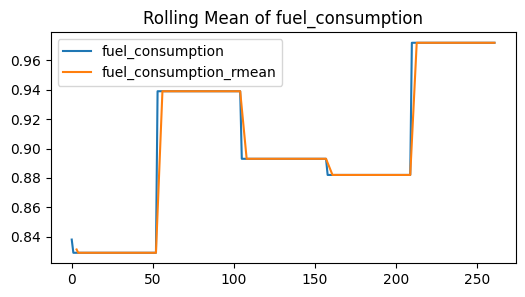

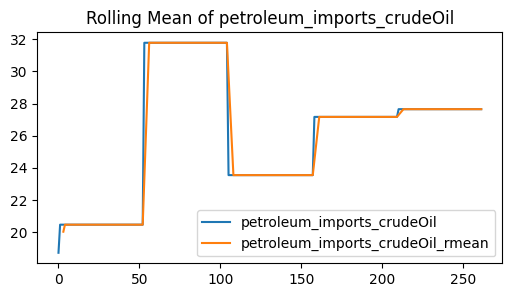

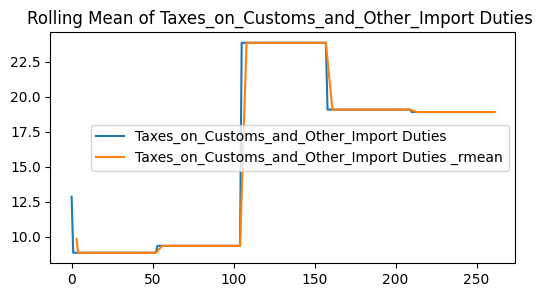

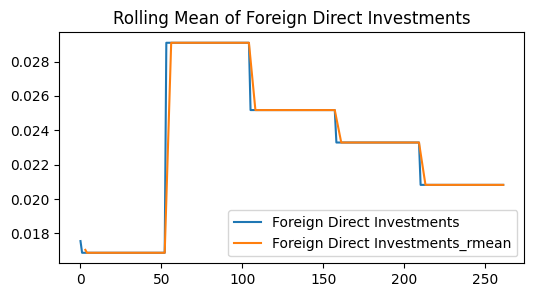

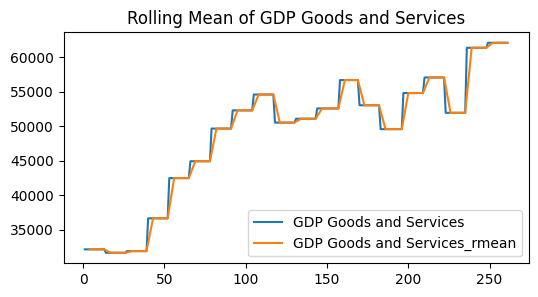

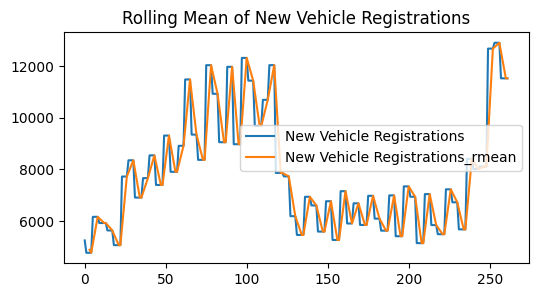

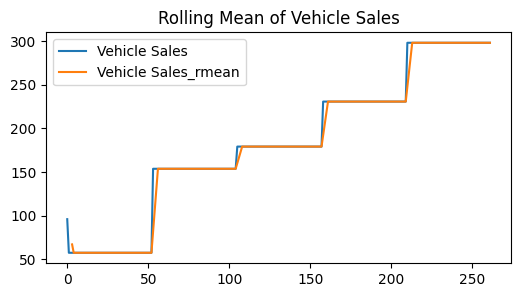

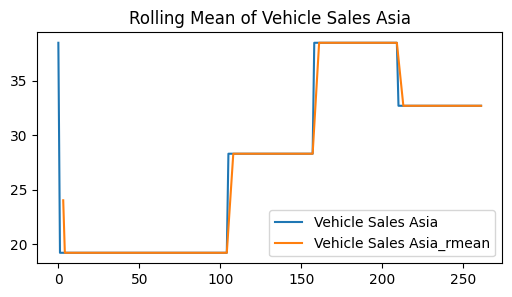

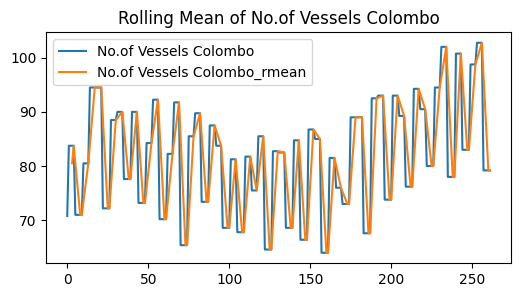

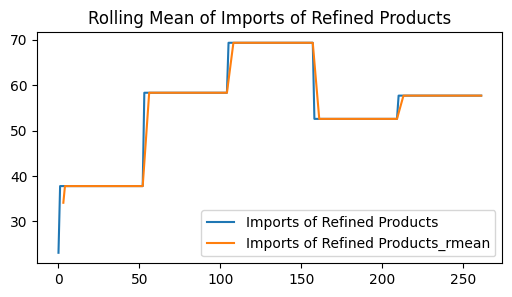

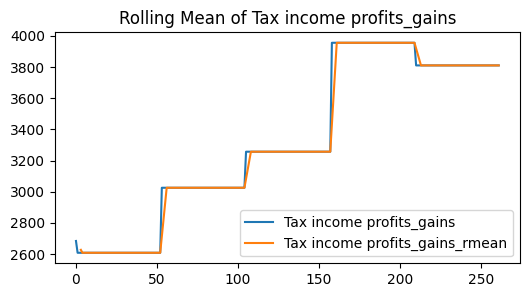

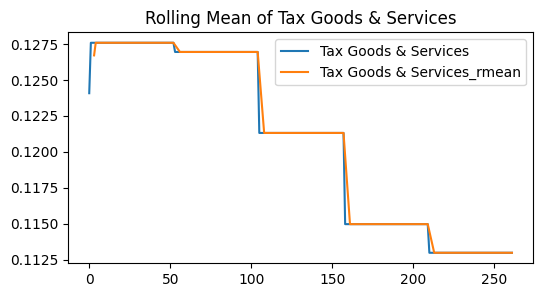

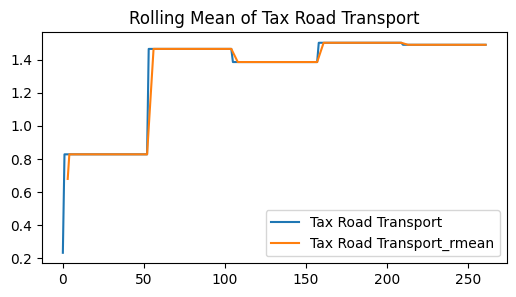

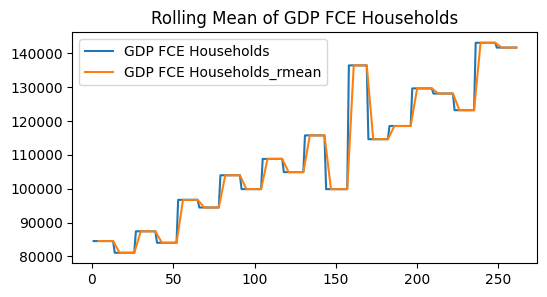

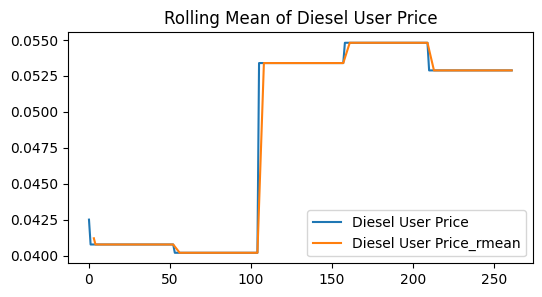

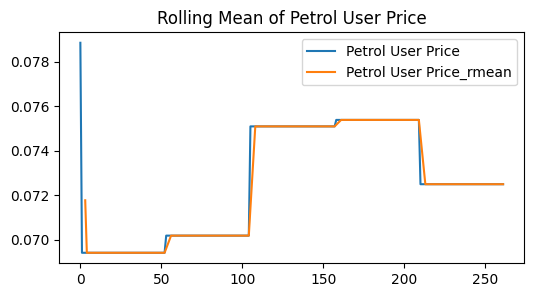

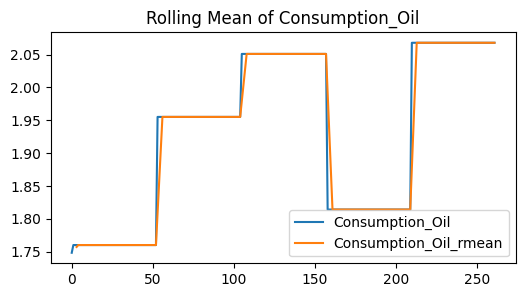

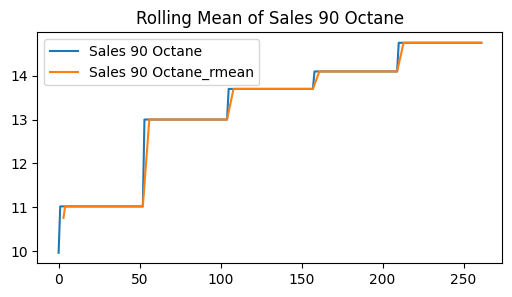

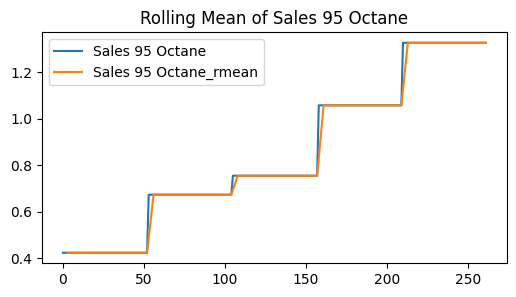

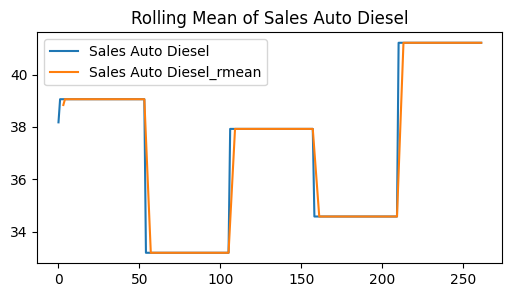

In [136]:
# Iterate only over numeric columns
for feature in df.select_dtypes(include=['number']).columns:
    rolling_stats(df, feature,window=4)

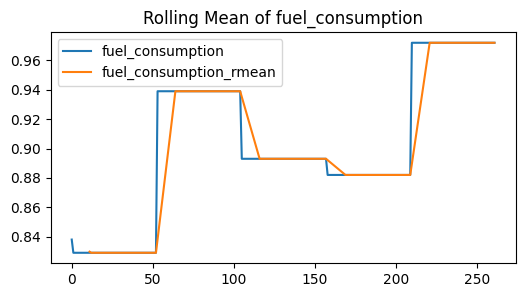

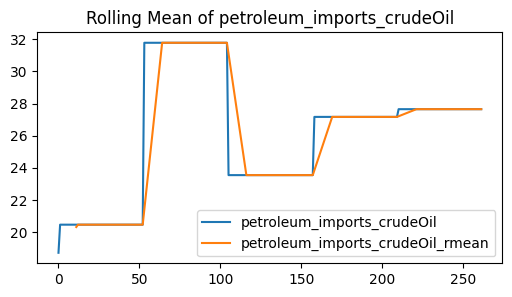

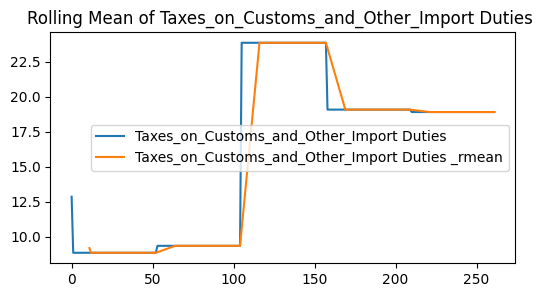

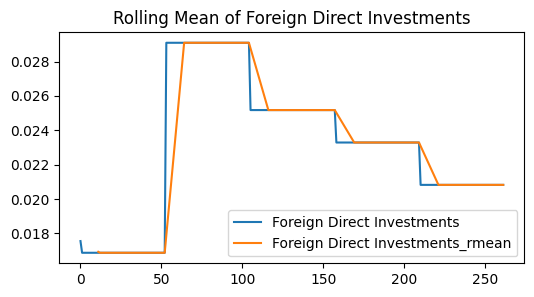

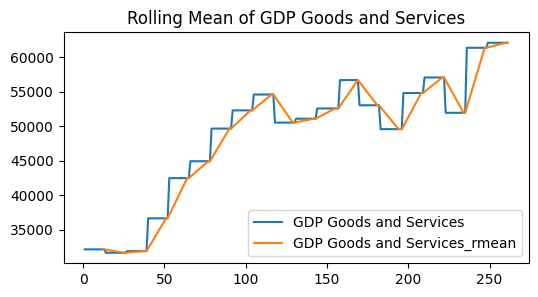

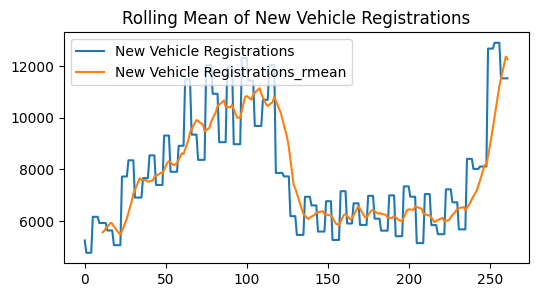

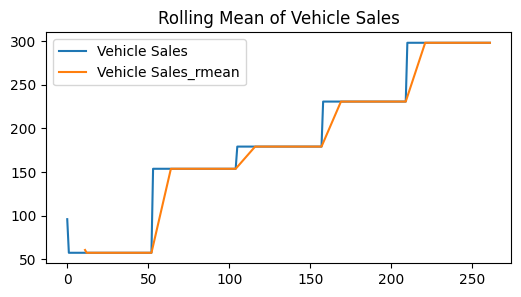

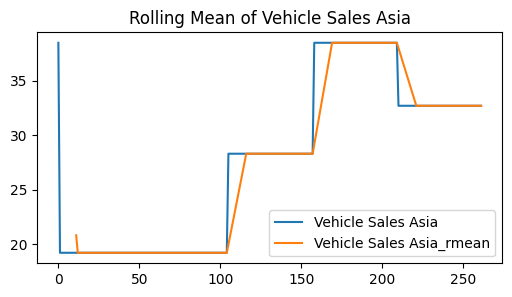

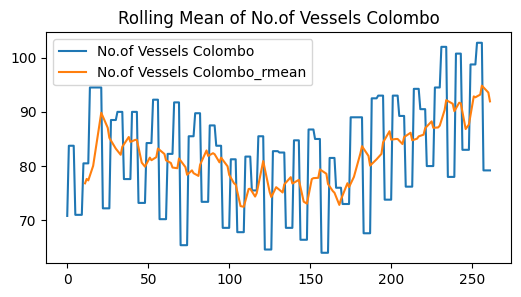

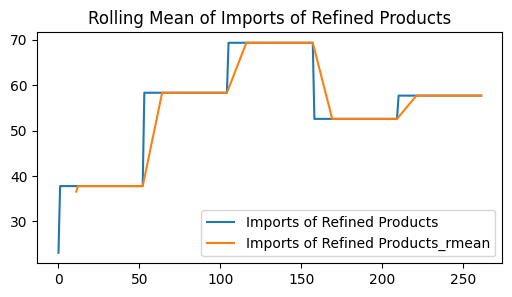

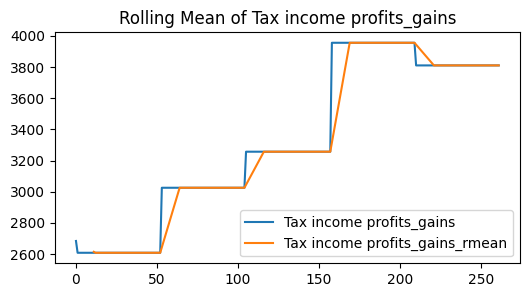

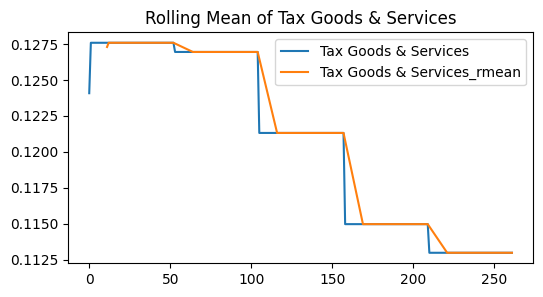

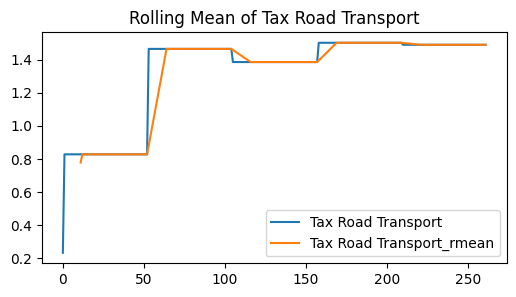

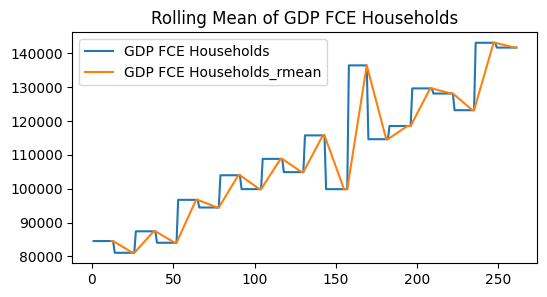

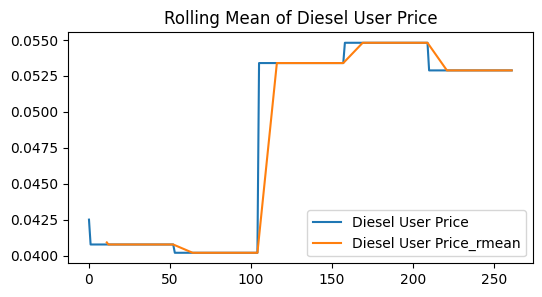

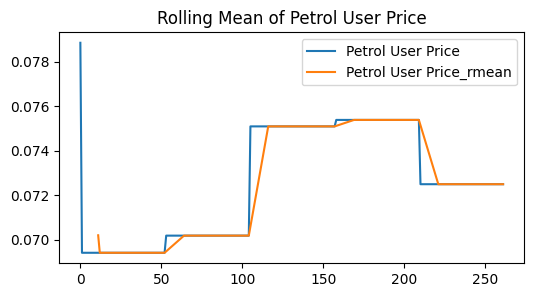

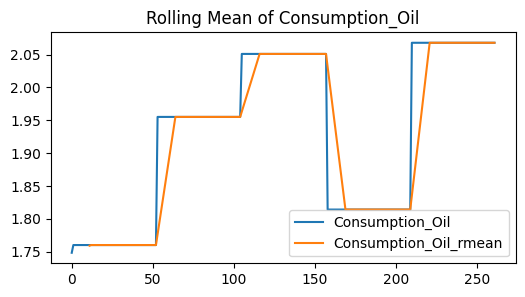

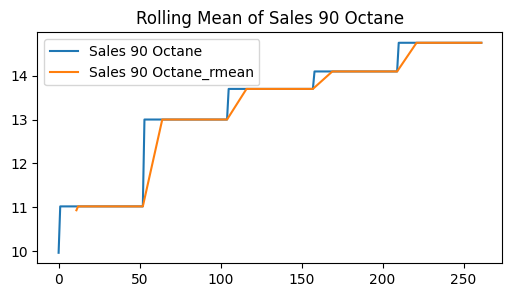

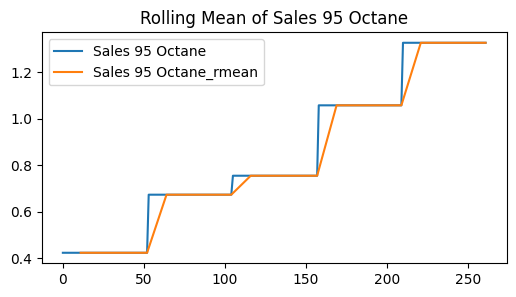

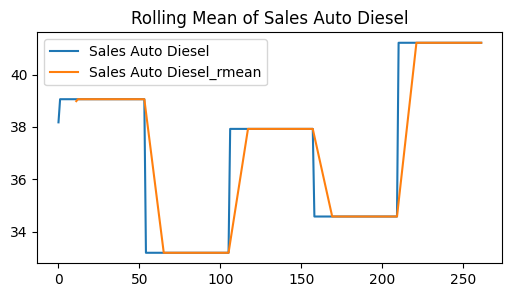

In [137]:
for feature in df.select_dtypes(include=['number']).columns:
    rolling_stats(df, feature,window=12)

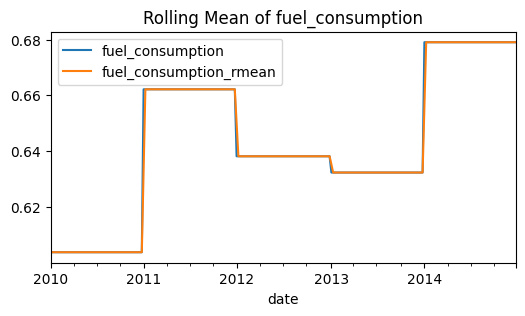

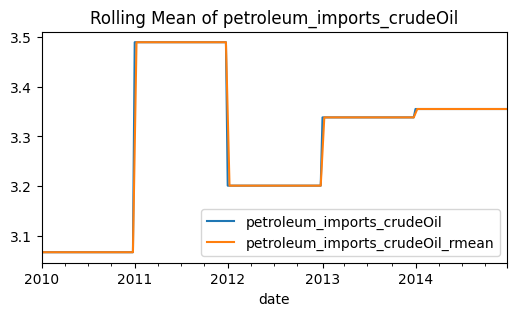

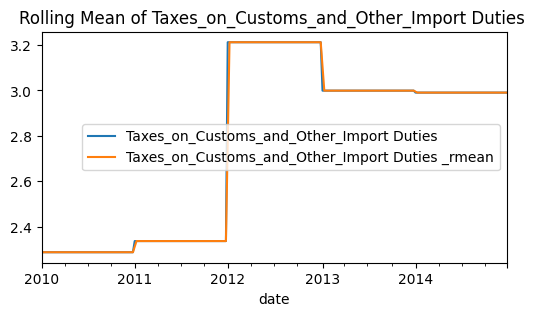

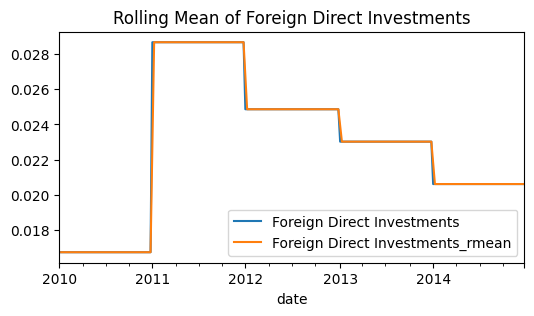

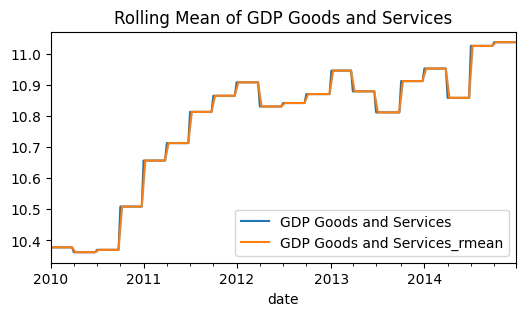

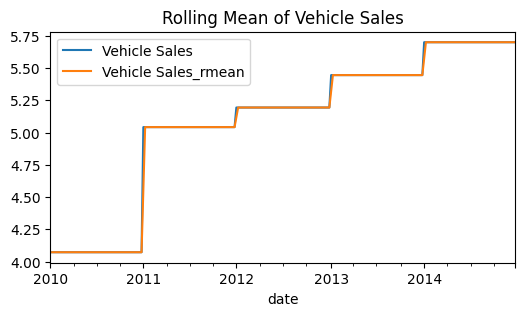

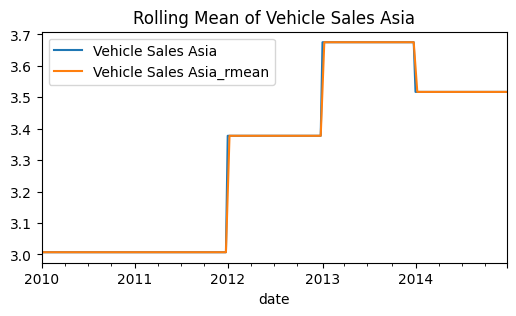

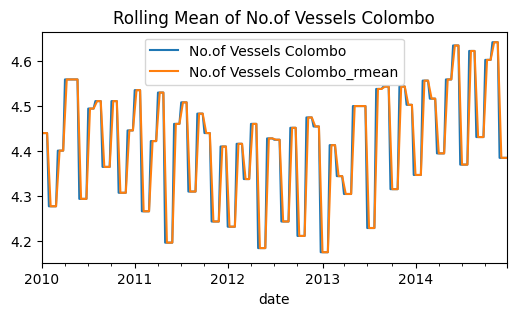

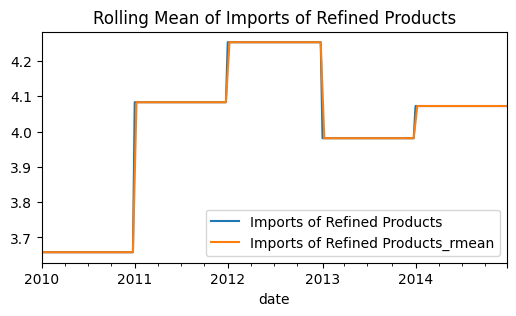

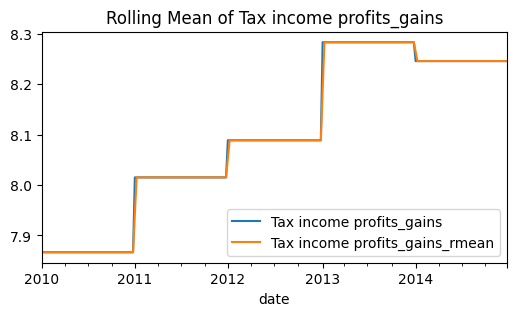

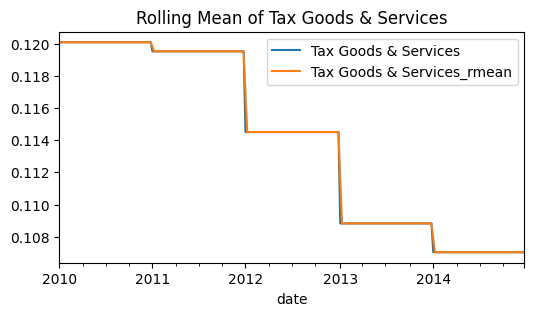

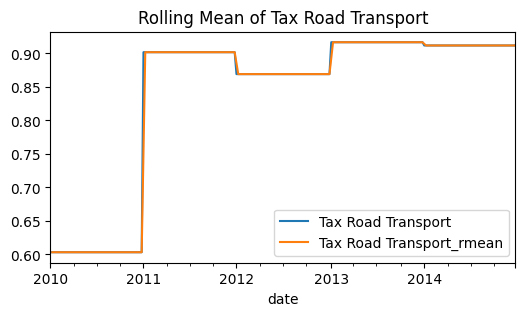

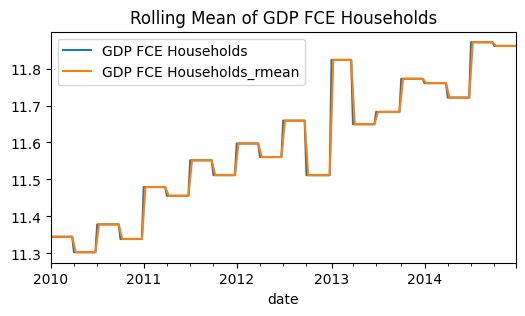

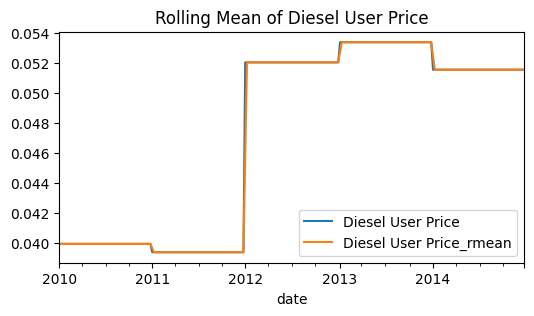

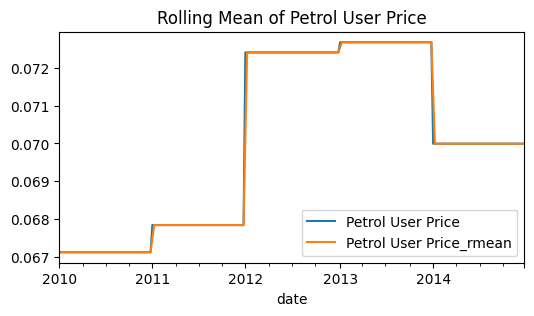

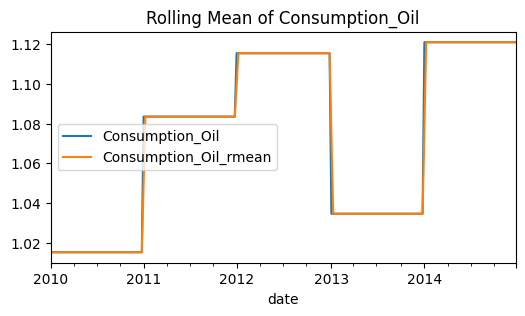

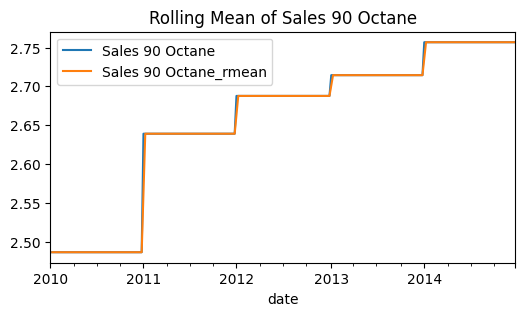

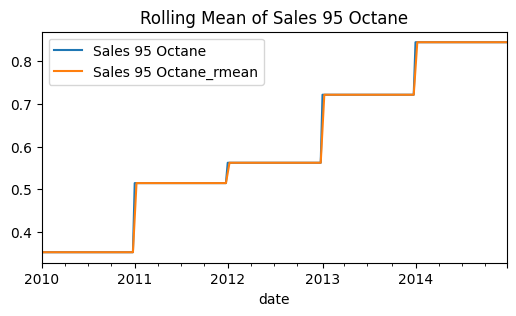

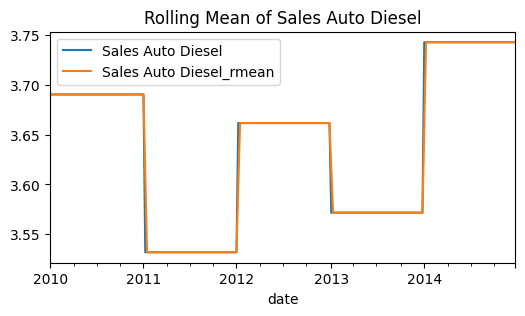

In [138]:
for feature in stationary_df.select_dtypes(include=['number']).columns:
    rolling_stats(stationary_df, feature,window=2)

### **Augmenting and Transforming the stationary dataset according to rolling statistics**

In [139]:
stationary_df.columns

Index(['fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties ',
       'Foreign Direct Investments', 'GDP Goods and Services', 'Vehicle Sales',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Tax income profits_gains',
       'Tax Goods & Services', 'Tax Road Transport', 'GDP FCE Households',
       'Diesel User Price', 'Petrol User Price', 'Consumption_Oil',
       'Sales 90 Octane', 'Sales 95 Octane', 'Sales Auto Diesel'],
      dtype='object')

In [140]:
for feature in stationary_df.columns:
    if feature != 'fuel_consumption':  # Skip self-correlation
        corr_value = stationary_df['fuel_consumption'].corr(stationary_df[feature])
        print(f"Correlation with {feature}: {corr_value:.4f}")

Correlation with petroleum_imports_crudeOil: 0.7954
Correlation with Taxes_on_Customs_and_Other_Import Duties : 0.2840
Correlation with Foreign Direct Investments: 0.4995
Correlation with GDP Goods and Services: 0.7355
Correlation with Vehicle Sales: 0.7882
Correlation with Vehicle Sales Asia: 0.2669
Correlation with No.of Vessels Colombo: 0.1704
Correlation with Imports of Refined Products: 0.6501
Correlation with Tax income profits_gains: 0.5511
Correlation with Tax Goods & Services: -0.4791
Correlation with Tax Road Transport: 0.7811
Correlation with GDP FCE Households: 0.6401
Correlation with Diesel User Price: 0.2503
Correlation with Petrol User Price: 0.1045
Correlation with Consumption_Oil: 0.7992
Correlation with Sales 90 Octane: 0.7601
Correlation with Sales 95 Octane: 0.7175
Correlation with Sales Auto Diesel: 0.0351


In [141]:
stationary_df.head()

fuel_consumption  petroleum_imports_crudeOil  \
date                                                       
2010-01-04          0.603769                    3.066262   
2010-01-11          0.603769                    3.066262   
2010-01-18          0.603769                    3.066262   
2010-01-25          0.603769                    3.066262   
2010-02-01          0.603769                    3.066262   

            Taxes_on_Customs_and_Other_Import Duties   \
date                                                    
2010-01-04                                   2.287793   
2010-01-11                                   2.287793   
2010-01-18                                   2.287793   
2010-01-25                                   2.287793   
2010-02-01                                   2.287793   

            Foreign Direct Investments  GDP Goods and Services  Vehicle Sales  \
date                                                                            
2010-01-04                    0.016726               10.377642       4.072309   
2010-01-11                    0.016726               10.377642       4.072309   
2010-01-18                    0.016726               10.377642       4.072309   
2010-01-25                    0.016726               10.377642       4.072309   
2010-02-01                    0.016726               10.377642       4.072309   

            Vehicle Sales Asia  No.of Vessels Colombo  \
date                                                    
2010-01-04            3.007205               4.439706   
2010-01-11            3.007205               4.439706   
2010-01-18            3.007205               4.439706   
2010-01-25            3.007205               4.439706   
2010-02-01            3.007205               4.276666   

            Imports of Refined Products  Tax income profits_gains  \
date                                                                
2010-01-04                     3.658123                   7.86677   
2010-01-11                     3.658123                   7.86677   
2010-01-18                     3.658123                   7.86677   
2010-01-25                     3.658123                   7.86677   
2010-02-01                     3.658123                   7.86677   

            Tax Goods & Services  Tax Road Transport  GDP FCE Households  \
date                                                                       
2010-01-04              0.120079            0.603265           11.344968   
2010-01-11              0.120079            0.603265           11.344968   
2010-01-18              0.120079            0.603265           11.344968   
2010-01-25              0.120079            0.603265           11.344968   
2010-02-01              0.120079            0.603265           11.344968   

            Diesel User Price  Petrol User Price  Consumption_Oil  \
date                                                                
2010-01-04            0.03996           0.067119         1.015273   
2010-01-11            0.03996           0.067119         1.015273   
2010-01-18            0.03996           0.067119         1.015273   
2010-01-25            0.03996           0.067119         1.015273   
2010-02-01            0.03996           0.067119         1.015273   

            Sales 90 Octane  Sales 95 Octane  Sales Auto Diesel  
date                                                             
2010-01-04         2.486508         0.352821           3.690294  
2010-01-11         2.486508         0.352821           3.690294  
2010-01-18         2.486508         0.352821           3.690294  
2010-01-25         2.486508         0.352821           3.690294  
2010-02-01         2.486508         0.352821           3.690294

In [142]:
from scipy.stats import boxcox
def rolling_stats_transformation(df, target_col='fuel_consumption'):
    df = df.copy()

    # # Ensure 'date' is datetime type
    # df['date'] = pd.to_datetime(df['date'])
    # df = df.set_index('date')  # Set date as index for time-based calculations

    # 1. Rolling Statistics Features
    df['rolling_mean_7'] = df[target_col].rolling(window=7).mean()
    df['rolling_std_7'] = df[target_col].rolling(window=7).std()
    df['rolling_median_7'] = df[target_col].rolling(window=7).median()

    # 2. Exponential Moving Average (EMA)
    df['ema_0.1'] = df[target_col].ewm(alpha=0.1).mean()
    df['ema_0.3'] = df[target_col].ewm(alpha=0.3).mean()

    # 3. Time-Based Features
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)  # 1 if weekend, 0 otherwise

    # 4. Target Variable Transformation
    df['log_fuel_consumption'] = np.log1p(df[target_col])  # Log transformation
    df['boxcox_fuel_consumption'], lambda_bc = boxcox(df[target_col] + 1)  # Box-Cox transformation

    # 5. Interaction Terms
    if 'fuel_price' in df.columns:  # Example: Check if 'fuel_price' exists in the dataset
        df['price_per_demand'] = df['fuel_price'] / (df[target_col] + 1)  # Avoid division by zero

    return df

In [143]:
s_df = rolling_stats_transformation(stationary_df)

In [144]:
s_df.head()

fuel_consumption  petroleum_imports_crudeOil  \
date                                                       
2010-01-04          0.603769                    3.066262   
2010-01-11          0.603769                    3.066262   
2010-01-18          0.603769                    3.066262   
2010-01-25          0.603769                    3.066262   
2010-02-01          0.603769                    3.066262   

            Taxes_on_Customs_and_Other_Import Duties   \
date                                                    
2010-01-04                                   2.287793   
2010-01-11                                   2.287793   
2010-01-18                                   2.287793   
2010-01-25                                   2.287793   
2010-02-01                                   2.287793   

            Foreign Direct Investments  GDP Goods and Services  Vehicle Sales  \
date                                                                            
2010-01-04                    0.016726               10.377642       4.072309   
2010-01-11                    0.016726               10.377642       4.072309   
2010-01-18                    0.016726               10.377642       4.072309   
2010-01-25                    0.016726               10.377642       4.072309   
2010-02-01                    0.016726               10.377642       4.072309   

            Vehicle Sales Asia  No.of Vessels Colombo  \
date                                                    
2010-01-04            3.007205               4.439706   
2010-01-11            3.007205               4.439706   
2010-01-18            3.007205               4.439706   
2010-01-25            3.007205               4.439706   
2010-02-01            3.007205               4.276666   

            Imports of Refined Products  Tax income profits_gains  ...  \
date                                                               ...   
2010-01-04                     3.658123                   7.86677  ...   
2010-01-11                     3.658123                   7.86677  ...   
2010-01-18                     3.658123                   7.86677  ...   
2010-01-25                     3.658123                   7.86677  ...   
2010-02-01                     3.658123                   7.86677  ...   

            rolling_std_7  rolling_median_7   ema_0.1   ema_0.3  dayofweek  \
date                                                                         
2010-01-04            NaN               NaN  0.603769  0.603769          0   
2010-01-11            NaN               NaN  0.603769  0.603769          0   
2010-01-18            NaN               NaN  0.603769  0.603769          0   
2010-01-25            NaN               NaN  0.603769  0.603769          0   
2010-02-01            NaN               NaN  0.603769  0.603769          0   

            month  quarter  is_weekend  log_fuel_consumption  \
date                                                           
2010-01-04      1        1           0              0.472357   
2010-01-11      1        1           0              0.472357   
2010-01-18      1        1           0              0.472357   
2010-01-25      1        1           0              0.472357   
2010-02-01      2        1           0              0.472357   

            boxcox_fuel_consumption  
date                                 
2010-01-04                   1.6569  
2010-01-11                   1.6569  
2010-01-18                   1.6569  
2010-01-25                   1.6569  
2010-02-01                   1.6569  

[5 rows x 30 columns]

In [145]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox

def transform_features(df):
    # Make a copy of the original DataFrame
    df_transformed = df.copy()

    # Ensure 'date' is datetime type if it's not already
    # df_transformed['date'] = pd.to_datetime(df_transformed['date'])
    # df_transformed = df_transformed.set_index('date')  # Set 'date' as the index for time-based calculations

    # Features to transform
    features_to_transform = ['fuel_consumption', 'petroleum_imports_crudeOil', 'Vehicle Sales']

    # 1. Rolling Mean & Rolling Standard Deviation
    window_size = 4  # Adjust based on data frequency
    for feature in features_to_transform:
        df_transformed[f"{feature}_rolling_mean"] = df_transformed[feature].rolling(window=window_size, min_periods=1).mean()
        df_transformed[f"{feature}_rolling_std"] = df_transformed[feature].rolling(window=window_size, min_periods=1).std()

    # 2. Exponential Moving Average (EMA)
    span = 4
    for feature in features_to_transform:
        df_transformed[f"{feature}_ema"] = df_transformed[feature].ewm(span=span, adjust=False).mean()

    # 3. Time-based Features (Extracting time components)
    df_transformed['month'] = df_transformed.index.month
    df_transformed['quarter'] = df_transformed.index.quarter
    df_transformed['year'] = df_transformed.index.year
    df_transformed['day_of_week'] = df_transformed.index.dayofweek

    # 4. Target Variable Transformations (Log & Box-Cox)
    for feature in features_to_transform:
        df_transformed[f"{feature}_log"] = np.log1p(df_transformed[feature])  # log(x + 1) to avoid log(0)

        # Box-Cox transformation (only if feature is strictly positive)
        if (df_transformed[feature] > 0).all():
            df_transformed[f"{feature}_boxcox"], _ = boxcox(df_transformed[feature] + 1)  # Shift to avoid zero values

    # 5. Interaction Terms (Multiplications & Ratios)
    df_transformed['fuel_x_petroleum'] = df_transformed['fuel_consumption'] * df_transformed['petroleum_imports_crudeOil']
    df_transformed['fuel_x_sales'] = df_transformed['fuel_consumption'] * df_transformed['Vehicle Sales']
    df_transformed['petroleum_x_sales'] = df_transformed['petroleum_imports_crudeOil'] * df_transformed['Vehicle Sales']

    df_transformed['fuel_ratio_petroleum'] = df_transformed['fuel_consumption'] / (df_transformed['petroleum_imports_crudeOil'] + 1)
    df_transformed['fuel_ratio_vessels'] = df_transformed['fuel_consumption'] / (df_transformed['Vehicle Sales'] + 1)

    return df_transformed


In [146]:
# Example usage
df_transformed = transform_features(s_df)

# Display transformed data
df_transformed.head()


fuel_consumption  petroleum_imports_crudeOil  \
date                                                       
2010-01-04          0.603769                    3.066262   
2010-01-11          0.603769                    3.066262   
2010-01-18          0.603769                    3.066262   
2010-01-25          0.603769                    3.066262   
2010-02-01          0.603769                    3.066262   

            Taxes_on_Customs_and_Other_Import Duties   \
date                                                    
2010-01-04                                   2.287793   
2010-01-11                                   2.287793   
2010-01-18                                   2.287793   
2010-01-25                                   2.287793   
2010-02-01                                   2.287793   

            Foreign Direct Investments  GDP Goods and Services  Vehicle Sales  \
date                                                                            
2010-01-04                    0.016726               10.377642       4.072309   
2010-01-11                    0.016726               10.377642       4.072309   
2010-01-18                    0.016726               10.377642       4.072309   
2010-01-25                    0.016726               10.377642       4.072309   
2010-02-01                    0.016726               10.377642       4.072309   

            Vehicle Sales Asia  No.of Vessels Colombo  \
date                                                    
2010-01-04            3.007205               4.439706   
2010-01-11            3.007205               4.439706   
2010-01-18            3.007205               4.439706   
2010-01-25            3.007205               4.439706   
2010-02-01            3.007205               4.276666   

            Imports of Refined Products  Tax income profits_gains  ...  \
date                                                               ...   
2010-01-04                     3.658123                   7.86677  ...   
2010-01-11                     3.658123                   7.86677  ...   
2010-01-18                     3.658123                   7.86677  ...   
2010-01-25                     3.658123                   7.86677  ...   
2010-02-01                     3.658123                   7.86677  ...   

            fuel_consumption_boxcox  petroleum_imports_crudeOil_log  \
date                                                                  
2010-01-04                   1.6569                        1.402724   
2010-01-11                   1.6569                        1.402724   
2010-01-18                   1.6569                        1.402724   
2010-01-25                   1.6569                        1.402724   
2010-02-01                   1.6569                        1.402724   

            petroleum_imports_crudeOil_boxcox  Vehicle Sales_log  \
date                                                               
2010-01-04                         169.037046           1.623796   
2010-01-11                         169.037046           1.623796   
2010-01-18                         169.037046           1.623796   
2010-01-25                         169.037046           1.623796   
2010-02-01                         169.037046           1.623796   

            Vehicle Sales_boxcox  fuel_x_petroleum  fuel_x_sales  \
date                                                               
2010-01-04           5825.541452          1.851315      2.458735   
2010-01-11           5825.541452          1.851315      2.458735   
2010-01-18           5825.541452          1.851315      2.458735   
2010-01-25           5825.541452          1.851315      2.458735   
2010-02-01           5825.541452          1.851315      2.458735   

            petroleum_x_sales  fuel_ratio_petroleum  fuel_ratio_vessels  
date                                                                     
2010-01-04          12.486767              0.148483            0.119032  
2010-01-11          12.486767 

### **Training a Data Model**

In [147]:
arima_mae, arima_rmse,arima_r2, arima_forecast = train_arima(df_transformed, target_col='fuel_consumption', order=(5, 1, 0), train_ratio=0.8)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


ARIMA MAE: 0.0458
ARIMA RMSE: 0.0463
ARIMA R² Score: -52.0000

Residual Analysis:
count    53.000000
mean      0.045832
std       0.006417
min       0.000000
25%       0.046713
50%       0.046713
75%       0.046713
max       0.046713
dtype: float64


In [152]:
prophet_mae,prophet_rmse,prophet_r2,prophet_forecast = train_prophet(df_transformed, target_col='fuel_consumption', train_ratio=0.8)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/w9o7a901.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/5r1qh2zc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22396', 'data', 'file=/tmp/tmpzuioq736/w9o7a901.json', 'init=/tmp/tmpzuioq736/5r1qh2zc.json', 'output', 'file=/tmp/tmpzuioq736/prophet_modelsbgnvtgg/prophet_model-20250318170411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 0.0493
Prophet RMSE: 0.0498
Prophet R² Score: -60.3120


In [153]:
rf_mae, rf_rmse,rf_r2, feature_importances = train_random_forest(df_transformed, target_col='fuel_consumption', train_ratio=0.8, n_estimators=100)

RandomForest MAE: 0.0385
RandomForest RMSE: 0.0389
RandomForest R² Score: -36.3746

Top 10 Important Features:
Tax Goods & Services                         0.107975
fuel_ratio_vessels                           0.081652
Taxes_on_Customs_and_Other_Import Duties     0.047943
Vehicle Sales_ema                            0.047479
Sales 90 Octane                              0.044729
boxcox_fuel_consumption                      0.038687
Vehicle Sales_rolling_mean                   0.037344
GDP FCE Households                           0.036121
Sales Auto Diesel                            0.035128
Vehicle Sales_boxcox                         0.033774
dtype: float64


## **ACF/PACF Strength test**

In [150]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

def acf_pacf_strength(df, feature, nlags=10):
    acf_values = acf(df[feature].dropna(), nlags=nlags)
    pacf_values = pacf(df[feature].dropna(), nlags=nlags)

    # Compute how quickly ACF declines (higher means strong trend)
    acf_strength = np.sum(np.abs(acf_values[1:])) / nlags  # Ignore lag 0 (always 1)

    # Check if PACF drops off after the first lag (higher means trend)
    pacf_strength = abs(pacf_values[1])  # PACF at lag 1 shows direct correlation

    print(f"{feature}: ACF Strength = {acf_strength:.4f}, PACF Strength = {pacf_strength:.4f}")

    return acf_strength, pacf_strength

# Run for all columns
for feature in df.columns:
    acf_pacf_strength(df, feature)

date: ACF Strength = 0.9371, PACF Strength = 0.9923
fuel_consumption: ACF Strength = 0.8588, PACF Strength = 0.9788
petroleum_imports_crudeOil: ACF Strength = 0.8258, PACF Strength = 0.9693
Taxes_on_Customs_and_Other_Import Duties : ACF Strength = 0.9134, PACF Strength = 0.9892
Foreign Direct Investments: ACF Strength = 0.8655, PACF Strength = 0.9800
GDP Goods and Services: ACF Strength = 0.9027, PACF Strength = 0.9861
New Vehicle Registrations: ACF Strength = 0.6791, PACF Strength = 0.9266
Vehicle Sales: ACF Strength = 0.9265, PACF Strength = 0.9921
Vehicle Sales Asia: ACF Strength = 0.9279, PACF Strength = 0.9792
No.of Vessels Colombo: ACF Strength = 0.2333, PACF Strength = 0.7485
Imports of Refined Products: ACF Strength = 0.8723, PACF Strength = 0.9670
Tax income profits_gains: ACF Strength = 0.9378, PACF Strength = 0.9931
Tax Goods & Services: ACF Strength = 0.9472, PACF Strength = 0.9952
Tax Road Transport: ACF Strength = 0.8585, PACF Strength = 0.9487
GDP FCE Households: ACF Str

In [151]:
for feature in stationary_df.columns:
    acf_pacf_strength(stationary_df, feature)

fuel_consumption: ACF Strength = 0.8570, PACF Strength = 0.9777
petroleum_imports_crudeOil: ACF Strength = 0.8300, PACF Strength = 0.9728
Taxes_on_Customs_and_Other_Import Duties : ACF Strength = 0.9197, PACF Strength = 0.9892
Foreign Direct Investments: ACF Strength = 0.8635, PACF Strength = 0.9789
GDP Goods and Services: ACF Strength = 0.9116, PACF Strength = 0.9877
Vehicle Sales: ACF Strength = 0.9145, PACF Strength = 0.9882
Vehicle Sales Asia: ACF Strength = 0.9438, PACF Strength = 0.9936
No.of Vessels Colombo: ACF Strength = 0.2397, PACF Strength = 0.7490
Imports of Refined Products: ACF Strength = 0.8856, PACF Strength = 0.9830
Tax income profits_gains: ACF Strength = 0.9354, PACF Strength = 0.9921
Tax Goods & Services: ACF Strength = 0.9459, PACF Strength = 0.9940
Tax Road Transport: ACF Strength = 0.8866, PACF Strength = 0.9831
GDP FCE Households: ACF Strength = 0.8669, PACF Strength = 0.9796
Diesel User Price: ACF Strength = 0.9355, PACF Strength = 0.9921
Petrol User Price: AC

In [155]:
for feature in df_transformed.columns:
  acf_pacf_strength(df_transformed, feature)

fuel_consumption: ACF Strength = 0.8570, PACF Strength = 0.9777
petroleum_imports_crudeOil: ACF Strength = 0.8300, PACF Strength = 0.9728
Taxes_on_Customs_and_Other_Import Duties : ACF Strength = 0.9197, PACF Strength = 0.9892
Foreign Direct Investments: ACF Strength = 0.8635, PACF Strength = 0.9789
GDP Goods and Services: ACF Strength = 0.9116, PACF Strength = 0.9877
Vehicle Sales: ACF Strength = 0.9145, PACF Strength = 0.9882
Vehicle Sales Asia: ACF Strength = 0.9438, PACF Strength = 0.9936
No.of Vessels Colombo: ACF Strength = 0.2397, PACF Strength = 0.7490
Imports of Refined Products: ACF Strength = 0.8856, PACF Strength = 0.9830
Tax income profits_gains: ACF Strength = 0.9354, PACF Strength = 0.9921
Tax Goods & Services: ACF Strength = 0.9459, PACF Strength = 0.9940
Tax Road Transport: ACF Strength = 0.8866, PACF Strength = 0.9831
GDP FCE Households: ACF Strength = 0.8669, PACF Strength = 0.9796
Diesel User Price: ACF Strength = 0.9355, PACF Strength = 0.9921
Petrol User Price: AC

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pinv.
  warnings.warn("Matrix is singular. Using pinv.", ValueWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1490: ValueWarning: Matrix is singular. Using pin

### **Augmentation and transformation on the dataset**

In [157]:
def time_based_transformations(df):
  df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
  df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

  df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
  df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

  df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
  df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

  return df


In [158]:
tb_df = time_based_transformations(df_transformed)

## **Lag Analysis**

In [159]:
def lag_analysis(df,feature):
  df[feature+'lag1'] = df[feature].shift(1)

  # Show numerical correlation
  lag_corr = df[[feature,feature+'lag1']].corr().iloc[0,1]
  print("Correlation between",feature,"and its 1-day lag:",lag_corr)

In [160]:
for feature in df.columns:
  lag_analysis(df,feature)

Correlation between date and its 1-day lag: 0.17579594208115323
Correlation between fuel_consumption and its 1-day lag: 0.9821162991049553
Correlation between petroleum_imports_crudeOil and its 1-day lag: 0.9727459314822664
Correlation between Taxes_on_Customs_and_Other_Import Duties  and its 1-day lag: 0.9863866979244805
Correlation between Foreign Direct Investments and its 1-day lag: 0.9801308220815255
Correlation between GDP Goods and Services and its 1-day lag: 0.9928739874919144
Correlation between New Vehicle Registrations and its 1-day lag: 0.9306313403748379
Correlation between Vehicle Sales and its 1-day lag: 0.9944787355375321
Correlation between Vehicle Sales Asia and its 1-day lag: 0.9801767529519859
Correlation between No.of Vessels Colombo and its 1-day lag: 0.7474403394024445
Correlation between Imports of Refined Products and its 1-day lag: 0.981255261727274
Correlation between Tax income profits_gains and its 1-day lag: 0.9942931805571777
Correlation between Tax Goods

In [161]:
for feature in tb_df.columns:
  lag_analysis(tb_df,feature)

Correlation between fuel_consumption and its 1-day lag: 0.9820767144726389
Correlation between petroleum_imports_crudeOil and its 1-day lag: 0.9739811895874573
Correlation between Taxes_on_Customs_and_Other_Import Duties  and its 1-day lag: 0.9891216478939664
Correlation between Foreign Direct Investments and its 1-day lag: 0.980047947469228
Correlation between GDP Goods and Services and its 1-day lag: 0.9941843857729068
Correlation between Vehicle Sales and its 1-day lag: 0.9932293019160023
Correlation between Vehicle Sales Asia and its 1-day lag: 0.9933815828130612
Correlation between No.of Vessels Colombo and its 1-day lag: 0.7462915682628666
Correlation between Imports of Refined Products and its 1-day lag: 0.9855047032484765
Correlation between Tax income profits_gains and its 1-day lag: 0.9945180194127937
Correlation between Tax Goods & Services and its 1-day lag: 0.9959255622471257
Correlation between Tax Road Transport and its 1-day lag: 0.9875778993063432
Correlation between G

In [163]:
# Function to create lag features and compute correlations
def create_lag_features(df, features, lags=[1, 7, 30, 90], threshold=0.99):
    lagged_features = {}

    for feature in features:
        print(f"\nFeature: {feature}")
        for lag in lags:
            lag_col = f"{feature}_lag{lag}"
            df[lag_col] = df[feature].shift(lag)

            # Compute correlation between original and lagged feature
            corr = df[[feature, lag_col]].corr().iloc[0, 1]
            print(f"  → Lag {lag}: Correlation = {corr:.4f}")

            # Store correlations
            lagged_features[lag_col] = corr

    return df, lagged_features


In [168]:
def drop_redundant_lags(df, lagged_features, threshold=0.85): # threshold = 0.99
    to_drop = [feature for feature, corr in lagged_features.items() if abs(corr) >= threshold]

    print("\nDropping redundant lag features with correlation >=",threshold)
    print(to_drop)

    df = df.drop(columns=to_drop, errors="ignore")

    return df


In [169]:
# Select numeric features only (exclude categorical/time-based features)
numeric_features = tb_df.select_dtypes(include=['number']).columns.tolist()

# Compute lag features
lag_df, lagged_features = create_lag_features(tb_df, numeric_features)



Feature: fuel_consumption
  → Lag 1: Correlation = 0.9821
  → Lag 7: Correlation = 0.8707
  → Lag 30: Correlation = 0.3480
  → Lag 90: Correlation = -0.1548

Feature: petroleum_imports_crudeOil
  → Lag 1: Correlation = 0.9740
  → Lag 7: Correlation = 0.8137
  → Lag 30: Correlation = 0.1018
  → Lag 90: Correlation = 0.0418

Feature: Taxes_on_Customs_and_Other_Import Duties 
  → Lag 1: Correlation = 0.9891
  → Lag 7: Correlation = 0.9233
  → Lag 30: Correlation = 0.6591
  → Lag 90: Correlation = -0.0497

Feature: Foreign Direct Investments
  → Lag 1: Correlation = 0.9800
  → Lag 7: Correlation = 0.8565
  → Lag 30: Correlation = 0.2959
  → Lag 90: Correlation = -0.5154

Feature: GDP Goods and Services
  → Lag 1: Correlation = 0.9942
  → Lag 7: Correlation = 0.9604
  → Lag 30: Correlation = 0.8294
  → Lag 90: Correlation = 0.4490

Feature: Vehicle Sales
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.9532
  → Lag 30: Correlation = 0.8184
  → Lag 90: Correlation = 0.8291

Featur

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8214
  → Lag 30: Correlation = 0.1560
  → Lag 90: Correlation = -0.2245

Feature: fuel_consumption_lag1_lag90
  → Lag 1: Correlation = 0.9775
  → Lag 7: Correlation = 0.8389
  → Lag 30: Correlation = 0.2212
  → Lag 90: Correlation = -0.4468

Feature: fuel_consumption_lag7_lag1
  → Lag 1: Correlation = 0.9809
  → Lag 7: Correlation = 0.8618
  → Lag 30: Correlation = 0.2901
  → Lag 90: Correlation = -0.1560

Feature: fuel_consumption_lag7_lag7
  → Lag 1: Correlation = 0.9798
  → Lag 7: Correlation = 0.8538
  → Lag 30: Correlation = 0.2355
  → Lag 90: Correlation = -0.1574

Feature: fuel_consumption_lag7_lag30
  → Lag 1: Correlation = 0.9735
  → Lag 7: Correlation = 0.8046
  → Lag 30: Correlation = 0.1684
  → Lag 90: Correlation = -0.2652

Feature: fuel_consumption_lag7_lag90
  → Lag 1: Correlation = 0.9775
  → Lag 7: Correlation = 0.8388
  → Lag 30: Correlation = 0.2253
  → Lag 90: Correlation = -0.3874

Feature: fuel_consumption_lag30_lag1
  → Lag 1: Correlati

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_lag1_lag1
  → Lag 1: Correlation = 0.9739
  → Lag 7: Correlation = 0.8134
  → Lag 30: Correlation = 0.1007
  → Lag 90: Correlation = 0.0392

Feature: petroleum_imports_crudeOil_lag1_lag7
  → Lag 1: Correlation = 0.9738
  → Lag 7: Correlation = 0.8126
  → Lag 30: Correlation = 0.0973
  → Lag 90: Correlation = 0.0309

Feature: petroleum_imports_crudeOil_lag1_lag30
  → Lag 1: Correlation = 0.9732
  → Lag 7: Correlation = 0.8087
  → Lag 30: Correlation = 0.0835
  → Lag 90: Correlation = 0.0411

Feature: petroleum_imports_crudeOil_lag1_lag90
  → Lag 1: Correlation = 0.9715
  → Lag 7: Correlation = 0.7972
  → Lag 30: Correlation = 0.0654
  → Lag 90: Correlation = -0.0598

Feature: petroleum_imports_crudeOil_lag7_lag1
  → Lag 1: Correlation = 0.9738
  → Lag 7: Correlation = 0.8126
  → Lag 30: Correlation = 0.0973
  → Lag 90: Correlation = 0.0309

Feature: petroleum_imports_crudeOil_lag7_lag7
  → L

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.0867

Feature: petroleum_imports_crudeOil_lag30_lag90
  → Lag 1: Correlation = 0.9727
  → Lag 7: Correlation = 0.8043
  → Lag 30: Correlation = 0.0484
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_lag90_lag1
  → Lag 1: Correlation = 0.9715
  → Lag 7: Correlation = 0.7972
  → Lag 30: Correlation = 0.0654
  → Lag 90: Correlation = -0.0598

Feature: petroleum_imports_crudeOil_lag90_lag7
  → Lag 1: Correlation = 0.9713
  → Lag 7: Correlation = 0.7956
  → Lag 30: Correlation = 0.0690
  → Lag 90: Correlation = -0.1364

Feature: petroleum_imports_crudeOil_lag90_lag30
  → Lag 1: Correlation = 0.9727
  → Lag 7: Correlation = 0.8043
  → Lag 30: Correlation = 0.0484
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Taxes_on_Customs_and_Other_Import Duties _lag1_lag1
  → Lag 1: Correlation

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.0309

Feature: Taxes_on_Customs_and_Other_Import Duties _lag30_lag30
  → Lag 1: Correlation = 0.9879
  → Lag 7: Correlation = 0.9146
  → Lag 30: Correlation = 0.6251
  → Lag 90: Correlation = -0.0012

Feature: Taxes_on_Customs_and_Other_Import Duties _lag30_lag90
  → Lag 1: Correlation = 0.9826
  → Lag 7: Correlation = 0.8771
  → Lag 30: Correlation = 0.4299
  → Lag 90: Correlation = nan

Feature: Taxes_on_Customs_and_Other_Import Duties _lag90_lag1
  → Lag 1: Correlation = 0.9865
  → Lag 7: Correlation = 0.9055
  → Lag 30: Correlation = 0.5962
  → Lag 90: Correlation = 0.2001

Feature: Taxes_on_Customs_and_Other_Import Duties _lag90_lag7
  → Lag 1: Correlation = 0.9862
  → Lag 7: Correlation = 0.9030
  → Lag 30: Correlation = 0.5917
  → Lag 90: Correlation = 0.2265

Feature: Taxes_on_Customs_and_Other_Import Duties _lag90_lag30
  → Lag 1: Correlation = 0.9826
  → Lag 7: Correlation = 0.8771
  → Lag 30: Correlation = 0.4299
  → Lag 90: Correlation = nan

Fe

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9792
  → Lag 7: Correlation = 0.8497
  → Lag 30: Correlation = 0.2605
  → Lag 90: Correlation = -0.5798

Feature: Foreign Direct Investments_lag30_lag7
  → Lag 1: Correlation = 0.9790
  → Lag 7: Correlation = 0.8481
  → Lag 30: Correlation = 0.2620
  → Lag 90: Correlation = -0.5926

Feature: Foreign Direct Investments_lag30_lag30
  → Lag 1: Correlation = 0.9792
  → Lag 7: Correlation = 0.8510
  → Lag 30: Correlation = 0.2663
  → Lag 90: Correlation = -0.6594

Feature: Foreign Direct Investments_lag30_lag90
  → Lag 1: Correlation = 0.9795
  → Lag 7: Correlation = 0.8541
  → Lag 30: Correlation = 0.3076
  → Lag 90: Correlation = nan

Feature: Foreign Direct Investments_lag90_lag1
  → Lag 1: Correlation = 0.9792
  → Lag 7: Correlation = 0.8510
  → Lag 30: Correlation = 0.2847
  → Lag 90: Correlation = -0.5218

Feature: Foreign Direct Investments_lag90_lag7
  → Lag 1: Correlation = 0.9792
  → Lag 7: Correlation = 0.8510
  → Lag 30: Correlation = 0.2929
  → Lag 90

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.8309
  → Lag 90: Correlation = 0.3283

Feature: GDP Goods and Services_lag7_lag30
  → Lag 1: Correlation = 0.9944
  → Lag 7: Correlation = 0.9655
  → Lag 30: Correlation = 0.8233
  → Lag 90: Correlation = 0.2492

Feature: GDP Goods and Services_lag7_lag90
  → Lag 1: Correlation = 0.9950
  → Lag 7: Correlation = 0.9693
  → Lag 30: Correlation = 0.8294
  → Lag 90: Correlation = 0.3208

Feature: GDP Goods and Services_lag30_lag1
  → Lag 1: Correlation = 0.9945
  → Lag 7: Correlation = 0.9630
  → Lag 30: Correlation = 0.8222
  → Lag 90: Correlation = 0.2246

Feature: GDP Goods and Services_lag30_lag7
  → Lag 1: Correlation = 0.9944
  → Lag 7: Correlation = 0.9655
  → Lag 30: Correlation = 0.8233
  → Lag 90: Correlation = 0.2492

Feature: GDP Goods and Services_lag30_lag30
  → Lag 1: Correlation = 0.9945
  → Lag 7: Correlation = 0.9647
  → Lag 30: Correlation = 0.8174
  → Lag 90: Correlation = 0.0346

Feature: GDP Goods and Services_lag30_lag90
  → Lag 1: Correla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.9513
  → Lag 30: Correlation = 0.8096
  → Lag 90: Correlation = 0.8152

Feature: Vehicle Sales_lag7_lag7
  → Lag 1: Correlation = 0.9927
  → Lag 7: Correlation = 0.9497
  → Lag 30: Correlation = 0.8020
  → Lag 90: Correlation = 0.8020

Feature: Vehicle Sales_lag7_lag30
  → Lag 1: Correlation = 0.9915
  → Lag 7: Correlation = 0.9411
  → Lag 30: Correlation = 0.7709
  → Lag 90: Correlation = 0.7873

Feature: Vehicle Sales_lag7_lag90
  → Lag 1: Correlation = 0.9877
  → Lag 7: Correlation = 0.9138
  → Lag 30: Correlation = 0.6582
  → Lag 90: Correlation = 0.5439

Feature: Vehicle Sales_lag30_lag1
  → Lag 1: Correlation = 0.9919
  → Lag 7: Correlation = 0.9438
  → Lag 30: Correlation = 0.7793
  → Lag 90: Correlation = 0.7905

Feature: Vehicle Sales_lag30_lag7
  → Lag 1: Correlation = 0.9915
  → Lag 7: Correlation = 0.9411
  → Lag 30: Correlation = 0.7709
  → Lag 90: Correlation = 0.7873

Feature: Vehicle Sales_lag30_lag30
  → Lag 1:

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Vehicle Sales Asia_lag1_lag1
  → Lag 1: Correlation = 0.9934
  → Lag 7: Correlation = 0.9536
  → Lag 30: Correlation = 0.8049
  → Lag 90: Correlation = 0.2804

Feature: Vehicle Sales Asia_lag1_lag7
  → Lag 1: Correlation = 0.9933
  → Lag 7: Correlation = 0.9530
  → Lag 30: Correlation = 0.8026
  → Lag 90: Correlation = 0.2937

Feature: Vehicle Sales Asia_lag1_lag30
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.9502
  → Lag 30: Correlation = 0.8002
  → Lag 90: Correlation = 0.3240

Feature: Vehicle Sales Asia_lag1_lag90
  → Lag 1: Correlation = 0.9865
  → Lag 7: Correlation = 0.9071
  → Lag 30: Correlation = 0.7079
  → Lag 90: Correlation = nan

Feature: Vehicle Sales Asia_lag7_lag1
  → Lag 1: Correlation = 0.9933
  → Lag 7: Correlation = 0.9530
  → Lag 30: Correlation = 0.8026
  → Lag 90: Correlation = 0.2937

Feature: Vehicle Sales Asia_lag

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.1945
  → Lag 90: Correlation = 0.0993

Feature: No.of Vessels Colombo_lag90_lag1
  → Lag 1: Correlation = 0.7058
  → Lag 7: Correlation = -0.2537
  → Lag 30: Correlation = -0.1866
  → Lag 90: Correlation = -0.0144

Feature: No.of Vessels Colombo_lag90_lag7
  → Lag 1: Correlation = 0.7060
  → Lag 7: Correlation = -0.2712
  → Lag 30: Correlation = -0.1963
  → Lag 90: Correlation = -0.0147

Feature: No.of Vessels Colombo_lag90_lag30
  → Lag 1: Correlation = 0.7083
  → Lag 7: Correlation = -0.2751
  → Lag 30: Correlation = -0.1945
  → Lag 90: Correlation = 0.0993

Feature: No.of Vessels Colombo_lag90_lag90
  → Lag 1: Correlation = 0.7100
  → Lag 7: Correlation = -0.4589
  → Lag 30: Correlation = -0.4205
  → Lag 90: Correlation = nan

Feature: Imports of Refined Products_lag1_lag1
  → Lag 1: Correlation = 0.9855
  → Lag 7: Correlation = 0.8966
  → Lag 30: Correlation = 0.5069
  → Lag 90: Correlation = -0.6269

Feature: Imports of Refined Products_lag1_lag7
  → L

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8972
  → Lag 30: Correlation = 0.6525
  → Lag 90: Correlation = -0.1952

Feature: Imports of Refined Products_lag30_lag1
  → Lag 1: Correlation = 0.9853
  → Lag 7: Correlation = 0.8955
  → Lag 30: Correlation = 0.5072
  → Lag 90: Correlation = -0.6397

Feature: Imports of Refined Products_lag30_lag7
  → Lag 1: Correlation = 0.9853
  → Lag 7: Correlation = 0.8952
  → Lag 30: Correlation = 0.5075
  → Lag 90: Correlation = -0.6448

Feature: Imports of Refined Products_lag30_lag30
  → Lag 1: Correlation = 0.9856
  → Lag 7: Correlation = 0.8970
  → Lag 30: Correlation = 0.5091
  → Lag 90: Correlation = -0.6306

Feature: Imports of Refined Products_lag30_lag90
  → Lag 1: Correlation = 0.9880
  → Lag 7: Correlation = 0.9168
  → Lag 30: Correlation = 0.6797
  → Lag 90: Correlation = nan

Feature: Imports of Refined Products_lag90_lag1
  → Lag 1: Correlation = 0.9856
  → Lag 7: Correlation = 0.8972
  → Lag 30: Correlation = 0.6071
  → Lag 90: Correlation = -0.3563

Fe

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.6395

Feature: Tax income profits_gains_lag7_lag1
  → Lag 1: Correlation = 0.9944
  → Lag 7: Correlation = 0.9612
  → Lag 30: Correlation = 0.8512
  → Lag 90: Correlation = 0.7548

Feature: Tax income profits_gains_lag7_lag7
  → Lag 1: Correlation = 0.9942
  → Lag 7: Correlation = 0.9603
  → Lag 30: Correlation = 0.8477
  → Lag 90: Correlation = 0.8172

Feature: Tax income profits_gains_lag7_lag30
  → Lag 1: Correlation = 0.9935
  → Lag 7: Correlation = 0.9556
  → Lag 30: Correlation = 0.8353
  → Lag 90: Correlation = 0.8115

Feature: Tax income profits_gains_lag7_lag90
  → Lag 1: Correlation = 0.9829
  → Lag 7: Correlation = 0.8795
  → Lag 30: Correlation = 0.7384
  → Lag 90: Correlation = 0.5516

Feature: Tax income profits_gains_lag30_lag1
  → Lag 1: Correlation = 0.9937
  → Lag 7: Correlation = 0.9570
  → Lag 30: Correlation = 0.8382
  → Lag 90: Correlation = 0.8128

Feature: Tax income profits_gains_lag30_lag7
  → Lag 1: Correlation = 0.9935
  → Lag 7: 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9883
  → Lag 7: Correlation = 0.9193
  → Lag 30: Correlation = 0.6973
  → Lag 90: Correlation = nan

Feature: Tax income profits_gains_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Tax Goods & Services_lag1_lag1
  → Lag 1: Correlation = 0.9959
  → Lag 7: Correlation = 0.9721
  → Lag 30: Correlation = 0.9022
  → Lag 90: Correlation = 0.6815

Feature: Tax Goods & Services_lag1_lag7
  → Lag 1: Correlation = 0.9957
  → Lag 7: Correlation = 0.9709
  → Lag 30: Correlation = 0.8989
  → Lag 90: Correlation = 0.6868

Feature: Tax Goods & Services_lag1_lag30
  → Lag 1: Correlation = 0.9947
  → Lag 7: Correlation = 0.9643
  → Lag 30: Correlation = 0.8793
  → Lag 90: Correlation = 0.6574

Feature: Tax Goods & Services_lag1_lag90
  → Lag 1: Correlation = 0.9857
  → Lag 7: Correlation = 0.9019
  → Lag 30: Correlation = 0.7505
  → Lag 90: Correlation = 0.6125

Feature: Tax Go

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9496
  → Lag 30: Correlation = 0.8242
  → Lag 90: Correlation = 0.4311

Feature: Tax Goods & Services_lag30_lag90
  → Lag 1: Correlation = 0.9835
  → Lag 7: Correlation = 0.8840
  → Lag 30: Correlation = 0.4864
  → Lag 90: Correlation = nan

Feature: Tax Goods & Services_lag90_lag1
  → Lag 1: Correlation = 0.9857
  → Lag 7: Correlation = 0.9019
  → Lag 30: Correlation = 0.7505
  → Lag 90: Correlation = 0.6125

Feature: Tax Goods & Services_lag90_lag7
  → Lag 1: Correlation = 0.9815
  → Lag 7: Correlation = 0.8738
  → Lag 30: Correlation = 0.7066
  → Lag 90: Correlation = 0.5221

Feature: Tax Goods & Services_lag90_lag30
  → Lag 1: Correlation = 0.9835
  → Lag 7: Correlation = 0.8840
  → Lag 30: Correlation = 0.4864
  → Lag 90: Correlation = nan

Feature: Tax Goods & Services_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Tax Road Transport_lag1_lag1
  → Lag 1: C

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.5774
  → Lag 90: Correlation = 0.6509

Feature: Tax Road Transport_lag7_lag30
  → Lag 1: Correlation = 0.9868
  → Lag 7: Correlation = 0.9063
  → Lag 30: Correlation = 0.5620
  → Lag 90: Correlation = 0.6271

Feature: Tax Road Transport_lag7_lag90
  → Lag 1: Correlation = 0.9840
  → Lag 7: Correlation = 0.8866
  → Lag 30: Correlation = 0.4863
  → Lag 90: Correlation = 0.1665

Feature: Tax Road Transport_lag30_lag1
  → Lag 1: Correlation = 0.9870
  → Lag 7: Correlation = 0.9074
  → Lag 30: Correlation = 0.5665
  → Lag 90: Correlation = 0.6344

Feature: Tax Road Transport_lag30_lag7
  → Lag 1: Correlation = 0.9868
  → Lag 7: Correlation = 0.9063
  → Lag 30: Correlation = 0.5620
  → Lag 90: Correlation = 0.6271

Feature: Tax Road Transport_lag30_lag30
  → Lag 1: Correlation = 0.9861
  → Lag 7: Correlation = 0.9013
  → Lag 30: Correlation = 0.5393
  → Lag 90: Correlation = 0.5846

Feature: Tax Road Transport_lag30_lag90
  → Lag 1: Correlation = 0.9832
  → Lag 7:

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.8572
  → Lag 90: Correlation = 0.6087

Feature: GDP FCE Households_lag1_lag30
  → Lag 1: Correlation = 0.9798
  → Lag 7: Correlation = 0.8548
  → Lag 30: Correlation = 0.8254
  → Lag 90: Correlation = 0.5810

Feature: GDP FCE Households_lag1_lag90
  → Lag 1: Correlation = 0.9673
  → Lag 7: Correlation = 0.7844
  → Lag 30: Correlation = 0.8183
  → Lag 90: Correlation = 0.2406

Feature: GDP FCE Households_lag7_lag1
  → Lag 1: Correlation = 0.9830
  → Lag 7: Correlation = 0.8772
  → Lag 30: Correlation = 0.8572
  → Lag 90: Correlation = 0.6087

Feature: GDP FCE Households_lag7_lag7
  → Lag 1: Correlation = 0.9818
  → Lag 7: Correlation = 0.8676
  → Lag 30: Correlation = 0.8496
  → Lag 90: Correlation = 0.5514

Feature: GDP FCE Households_lag7_lag30
  → Lag 1: Correlation = 0.9791
  → Lag 7: Correlation = 0.8502
  → Lag 30: Correlation = 0.8224
  → Lag 90: Correlation = 0.5752

Feature: GDP FCE Households_lag7_lag90
  → Lag 1: Correlation = 0.9658
  → Lag 7: Cor

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9658
  → Lag 7: Correlation = 0.7359
  → Lag 30: Correlation = 0.7914
  → Lag 90: Correlation = 0.0620

Feature: GDP FCE Households_lag90_lag30
  → Lag 1: Correlation = 0.9830
  → Lag 7: Correlation = 0.8793
  → Lag 30: Correlation = 0.8580
  → Lag 90: Correlation = -0.2554

Feature: GDP FCE Households_lag90_lag90
  → Lag 1: Correlation = 0.9511
  → Lag 7: Correlation = 0.6857
  → Lag 30: Correlation = 0.4448
  → Lag 90: Correlation = nan

Feature: Diesel User Price_lag1_lag1
  → Lag 1: Correlation = 0.9918
  → Lag 7: Correlation = 0.9425
  → Lag 30: Correlation = 0.7515
  → Lag 90: Correlation = 0.1362

Feature: Diesel User Price_lag1_lag7
  → Lag 1: Correlation = 0.9917
  → Lag 7: Correlation = 0.9418
  → Lag 30: Correlation = 0.7491
  → Lag 90: Correlation = 0.1373

Feature: Diesel User Price_lag1_lag30
  → Lag 1: Correlation = 0.9913
  → Lag 7: Correlation = 0.9389
  → Lag 30: Correlation = 0.7394
  → Lag 90: Correlation = 0.1430

Feature: Diesel User Pri

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9380
  → Lag 30: Correlation = 0.7371
  → Lag 90: Correlation = 0.1461

Feature: Diesel User Price_lag7_lag90
  → Lag 1: Correlation = 0.9865
  → Lag 7: Correlation = 0.9048
  → Lag 30: Correlation = 0.5848
  → Lag 90: Correlation = -0.3482

Feature: Diesel User Price_lag30_lag1
  → Lag 1: Correlation = 0.9913
  → Lag 7: Correlation = 0.9389
  → Lag 30: Correlation = 0.7394
  → Lag 90: Correlation = 0.1430

Feature: Diesel User Price_lag30_lag7
  → Lag 1: Correlation = 0.9911
  → Lag 7: Correlation = 0.9380
  → Lag 30: Correlation = 0.7371
  → Lag 90: Correlation = 0.1461

Feature: Diesel User Price_lag30_lag30
  → Lag 1: Correlation = 0.9905
  → Lag 7: Correlation = 0.9334
  → Lag 30: Correlation = 0.7172
  → Lag 90: Correlation = 0.0975

Feature: Diesel User Price_lag30_lag90
  → Lag 1: Correlation = 0.9808
  → Lag 7: Correlation = 0.8632
  → Lag 30: Correlation = 0.3135
  → Lag 90: Correlation = nan

Feature: Diesel User Price_lag90_lag1
  → Lag 1: Correla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9251
  → Lag 30: Correlation = 0.6908
  → Lag 90: Correlation = -0.1584

Feature: Petrol User Price_lag1_lag90
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9266
  → Lag 30: Correlation = 0.6983
  → Lag 90: Correlation = 0.3675

Feature: Petrol User Price_lag7_lag1
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9251
  → Lag 30: Correlation = 0.6633
  → Lag 90: Correlation = -0.3268

Feature: Petrol User Price_lag7_lag7
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9251
  → Lag 30: Correlation = 0.6636
  → Lag 90: Correlation = -0.2926

Feature: Petrol User Price_lag7_lag30
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9251
  → Lag 30: Correlation = 0.7113
  → Lag 90: Correlation = -0.0848

Feature: Petrol User Price_lag7_lag90
  → Lag 1: Correlation = 0.9887
  → Lag 7: Correlation = 0.9214
  → Lag 30: Correlation = 0.6752
  → Lag 90: Correlation = 0.3335

Feature: Petrol User P

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9266
  → Lag 30: Correlation = 0.6983
  → Lag 90: Correlation = 0.3675

Feature: Petrol User Price_lag90_lag7
  → Lag 1: Correlation = 0.9887
  → Lag 7: Correlation = 0.9214
  → Lag 30: Correlation = 0.6752
  → Lag 90: Correlation = 0.3335

Feature: Petrol User Price_lag90_lag30
  → Lag 1: Correlation = 0.9842
  → Lag 7: Correlation = 0.8888
  → Lag 30: Correlation = 0.5247
  → Lag 90: Correlation = nan

Feature: Petrol User Price_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Consumption_Oil_lag1_lag1
  → Lag 1: Correlation = 0.9788
  → Lag 7: Correlation = 0.8481
  → Lag 30: Correlation = 0.2630
  → Lag 90: Correlation = -0.2565

Feature: Consumption_Oil_lag1_lag7
  → Lag 1: Correlation = 0.9782
  → Lag 7: Correlation = 0.8433
  → Lag 30: Correlation = 0.2363
  → Lag 90: Correlation = -0.2371

Feature: Consumption_Oil_lag1_lag30
  → Lag 1: Correlation = 0.9749

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.6926
  → Lag 90: Correlation = nan

Feature: Consumption_Oil_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Sales 90 Octane_lag1_lag1
  → Lag 1: Correlation = 0.9938
  → Lag 7: Correlation = 0.9571
  → Lag 30: Correlation = 0.8414
  → Lag 90: Correlation = 0.8213

Feature: Sales 90 Octane_lag1_lag7
  → Lag 1: Correlation = 0.9936
  → Lag 7: Correlation = 0.9559
  → Lag 30: Correlation = 0.8361
  → Lag 90: Correlation = 0.8112

Feature: Sales 90 Octane_lag1_lag30
  → Lag 1: Correlation = 0.9927
  → Lag 7: Correlation = 0.9495
  → Lag 30: Correlation = 0.8125
  → Lag 90: Correlation = 0.7724

Feature: Sales 90 Octane_lag1_lag90
  → Lag 1: Correlation = 0.9899
  → Lag 7: Correlation = 0.9298
  → Lag 30: Correlation = 0.7307
  → Lag 90: Correlation = 0.5372

Feature: Sales 90 Octane_lag7_lag1
  → Lag 1: Correlation = 0.9936
  → Lag 7: Correlation = 0.9559
  → Lag 3

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9864
  → Lag 7: Correlation = 0.9041
  → Lag 30: Correlation = 0.7101
  → Lag 90: Correlation = 0.6378

Feature: Sales 95 Octane_lag7_lag1
  → Lag 1: Correlation = 0.9951
  → Lag 7: Correlation = 0.9670
  → Lag 30: Correlation = 0.8900
  → Lag 90: Correlation = 0.8437

Feature: Sales 95 Octane_lag7_lag7
  → Lag 1: Correlation = 0.9948
  → Lag 7: Correlation = 0.9650
  → Lag 30: Correlation = 0.8839
  → Lag 90: Correlation = 0.8462

Feature: Sales 95 Octane_lag7_lag30
  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.9525
  → Lag 30: Correlation = 0.8503
  → Lag 90: Correlation = 0.8240

Feature: Sales 95 Octane_lag7_lag90
  → Lag 1: Correlation = 0.9838
  → Lag 7: Correlation = 0.8842
  → Lag 30: Correlation = 0.6982
  → Lag 90: Correlation = 0.5493

Feature: Sales 95 Octane_lag30_lag1
  → Lag 1: Correlation = 0.9936
  → Lag 7: Correlation = 0.9568
  → Lag 30: Correlation = 0.8615
  → Lag 90: Correlation = 0.8306

Feature: Sales 95 Octane_lag30_lag7


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9716
  → Lag 7: Correlation = 0.7945
  → Lag 30: Correlation = -0.0337
  → Lag 90: Correlation = 0.3403

Feature: Sales Auto Diesel_lag7_lag30
  → Lag 1: Correlation = 0.9637
  → Lag 7: Correlation = 0.7321
  → Lag 30: Correlation = -0.0840
  → Lag 90: Correlation = 0.2810

Feature: Sales Auto Diesel_lag7_lag90
  → Lag 1: Correlation = 0.9673
  → Lag 7: Correlation = 0.7666
  → Lag 30: Correlation = 0.0237
  → Lag 90: Correlation = -0.0556

Feature: Sales Auto Diesel_lag30_lag1
  → Lag 1: Correlation = 0.9663
  → Lag 7: Correlation = 0.7531
  → Lag 30: Correlation = -0.1163
  → Lag 90: Correlation = 0.3001

Feature: Sales Auto Diesel_lag30_lag7
  → Lag 1: Correlation = 0.9637
  → Lag 7: Correlation = 0.7321
  → Lag 30: Correlation = -0.0840
  → Lag 90: Correlation = 0.2810

Feature: Sales Auto Diesel_lag30_lag30
  → Lag 1: Correlation = 0.9707
  → Lag 7: Correlation = 0.7909
  → Lag 30: Correlation = 0.0139
  → Lag 90: Correlation = 0.2466

Feature: Sales Aut

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8821
  → Lag 30: Correlation = 0.1875
  → Lag 90: Correlation = -0.5912

Feature: rolling_mean_7_lag30_lag90
  → Lag 1: Correlation = 0.9966
  → Lag 7: Correlation = 0.8838
  → Lag 30: Correlation = 0.2134
  → Lag 90: Correlation = nan

Feature: rolling_mean_7_lag90_lag1
  → Lag 1: Correlation = 0.9965
  → Lag 7: Correlation = 0.8819
  → Lag 30: Correlation = 0.1975
  → Lag 90: Correlation = -0.4426

Feature: rolling_mean_7_lag90_lag7
  → Lag 1: Correlation = 0.9965
  → Lag 7: Correlation = 0.8826
  → Lag 30: Correlation = 0.2022
  → Lag 90: Correlation = -0.3644

Feature: rolling_mean_7_lag90_lag30
  → Lag 1: Correlation = 0.9966
  → Lag 7: Correlation = 0.8838
  → Lag 30: Correlation = 0.2134
  → Lag 90: Correlation = nan

Feature: rolling_mean_7_lag90_lag90
  → Lag 1: Correlation = 0.9959
  → Lag 7: Correlation = 0.8578
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: rolling_std_7_lag1_lag1
  → Lag 1: Correlation = 0.8735
  → Lag 7: C

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.8726
  → Lag 7: Correlation = -0.0849
  → Lag 30: Correlation = -0.1055
  → Lag 90: Correlation = nan

Feature: rolling_std_7_lag90_lag90
  → Lag 1: Correlation = 0.8720
  → Lag 7: Correlation = -0.0947
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: rolling_median_7_lag1_lag1
  → Lag 1: Correlation = 0.9808
  → Lag 7: Correlation = 0.8614
  → Lag 30: Correlation = 0.2871
  → Lag 90: Correlation = -0.1433

Feature: rolling_median_7_lag1_lag7
  → Lag 1: Correlation = 0.9798
  → Lag 7: Correlation = 0.8537
  → Lag 30: Correlation = 0.2352
  → Lag 90: Correlation = -0.1424

Feature: rolling_median_7_lag1_lag30
  → Lag 1: Correlation = 0.9739
  → Lag 7: Correlation = 0.8076
  → Lag 30: Correlation = 0.1255
  → Lag 90: Correlation = -0.2192

Feature: rolling_median_7_lag1_lag90
  → Lag 1: Correlation = 0.9767
  → Lag 7: Correlation = 0.8330
  → Lag 30: Correlation = 0.1833
  → Lag 90: Correlation = -0.4019

Feature: rolling_median_7_lag7_lag1

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9528
  → Lag 30: Correlation = 0.3961
  → Lag 90: Correlation = -0.2392

Feature: ema_0.1_lag7_lag7
  → Lag 1: Correlation = 0.9988
  → Lag 7: Correlation = 0.9490
  → Lag 30: Correlation = 0.3486
  → Lag 90: Correlation = -0.2690

Feature: ema_0.1_lag7_lag30
  → Lag 1: Correlation = 0.9983
  → Lag 7: Correlation = 0.9299
  → Lag 30: Correlation = 0.3681
  → Lag 90: Correlation = -0.5438

Feature: ema_0.1_lag7_lag90
  → Lag 1: Correlation = 0.9987
  → Lag 7: Correlation = 0.9487
  → Lag 30: Correlation = 0.4186
  → Lag 90: Correlation = -0.5035

Feature: ema_0.1_lag30_lag1
  → Lag 1: Correlation = 0.9984
  → Lag 7: Correlation = 0.9344
  → Lag 30: Correlation = 0.3473
  → Lag 90: Correlation = -0.4409

Feature: ema_0.1_lag30_lag7
  → Lag 1: Correlation = 0.9983
  → Lag 7: Correlation = 0.9299
  → Lag 30: Correlation = 0.3681
  → Lag 90: Correlation = -0.5438

Feature: ema_0.1_lag30_lag30
  → Lag 1: Correlation = 0.9987
  → Lag 7: Correlation = 0.9476
  → Lag 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.2708
  → Lag 90: Correlation = -0.4817

Feature: ema_0.3_lag7_lag1
  → Lag 1: Correlation = 0.9965
  → Lag 7: Correlation = 0.9077
  → Lag 30: Correlation = 0.3139
  → Lag 90: Correlation = -0.1780

Feature: ema_0.3_lag7_lag7
  → Lag 1: Correlation = 0.9963
  → Lag 7: Correlation = 0.9019
  → Lag 30: Correlation = 0.2554
  → Lag 90: Correlation = -0.1877

Feature: ema_0.3_lag7_lag30
  → Lag 1: Correlation = 0.9950
  → Lag 7: Correlation = 0.8646
  → Lag 30: Correlation = 0.2177
  → Lag 90: Correlation = -0.3365

Feature: ema_0.3_lag7_lag90
  → Lag 1: Correlation = 0.9959
  → Lag 7: Correlation = 0.8940
  → Lag 30: Correlation = 0.2755
  → Lag 90: Correlation = -0.4144

Feature: ema_0.3_lag30_lag1
  → Lag 1: Correlation = 0.9954
  → Lag 7: Correlation = 0.8775
  → Lag 30: Correlation = 0.2019
  → Lag 90: Correlation = -0.2777

Feature: ema_0.3_lag30_lag7
  → Lag 1: Correlation = 0.9950
  → Lag 7: Correlation = 0.8646
  → Lag 30: Correlation = 0.2177
  → Lag 9

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_lag7_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_lag30_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_lag30_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_lag30_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_lag30_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_lag90_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Corr

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.2712

Feature: month_lag30_lag90
  → Lag 1: Correlation = 0.9109
  → Lag 7: Correlation = 0.3771
  → Lag 30: Correlation = -0.4824
  → Lag 90: Correlation = -0.2095

Feature: month_lag90_lag1
  → Lag 1: Correlation = 0.9051
  → Lag 7: Correlation = 0.3431
  → Lag 30: Correlation = -0.4954
  → Lag 90: Correlation = -0.3043

Feature: month_lag90_lag7
  → Lag 1: Correlation = 0.9022
  → Lag 7: Correlation = 0.3077
  → Lag 30: Correlation = -0.4849
  → Lag 90: Correlation = -0.2988

Feature: month_lag90_lag30
  → Lag 1: Correlation = 0.9109
  → Lag 7: Correlation = 0.3771
  → Lag 30: Correlation = -0.4824
  → Lag 90: Correlation = -0.2095

Feature: month_lag90_lag90
  → Lag 1: Correlation = 0.9186
  → Lag 7: Correlation = 0.4210
  → Lag 30: Correlation = -0.4915
  → Lag 90: Correlation = nan

Feature: quarter_lag1_lag1
  → Lag 1: Correlation = 0.9200
  → Lag 7: Correlation = 0.4168
  → Lag 30: Correlation = -0.5004
  → Lag 90: Correlation = -0.3236

Feature: qu

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: is_weekend_lag1_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekend_lag1_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekend_lag1_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekend_lag1_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekend_lag7_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekend_lag7_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekend_lag7_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Co

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: log_fuel_consumption_lag1_lag1
  → Lag 1: Correlation = 0.9818
  → Lag 7: Correlation = 0.8688
  → Lag 30: Correlation = 0.3356
  → Lag 90: Correlation = -0.1528

Feature: log_fuel_consumption_lag1_lag7
  → Lag 1: Correlation = 0.9809
  → Lag 7: Correlation = 0.8620
  → Lag 30: Correlation = 0.2916
  → Lag 90: Correlation = -0.1540

Feature: log_fuel_consumption_lag1_lag30
  → Lag 1: Correlation = 0.9758
  → Lag 7: Correlation = 0.8225
  → Lag 30: Correlation = 0.1601
  → Lag 90: Correlation = -0.2240

Feature: log_fuel_consumption_lag1_lag90
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8395
  → Lag 30: Correlation = 0.2242
  → Lag 90: Correlation = -0.4477

Feature: log_fuel_consumption_lag7_lag1
  → Lag 1: Correlation = 0.9809
  → Lag 7: Correlation = 0.8620
  → Lag 30: Correlation = 0.2916
  → Lag 90: Correlation = -0.1540

Feature: log_fuel_c

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.4477

Feature: log_fuel_consumption_lag90_lag7
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8395
  → Lag 30: Correlation = 0.2285
  → Lag 90: Correlation = -0.3879

Feature: log_fuel_consumption_lag90_lag30
  → Lag 1: Correlation = 0.9777
  → Lag 7: Correlation = 0.8414
  → Lag 30: Correlation = 0.2394
  → Lag 90: Correlation = nan

Feature: log_fuel_consumption_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: boxcox_fuel_consumption_lag1_lag1
  → Lag 1: Correlation = 0.9817
  → Lag 7: Correlation = 0.8681
  → Lag 30: Correlation = 0.3325
  → Lag 90: Correlation = -0.1632

Feature: boxcox_fuel_consumption_lag1_lag7
  → Lag 1: Correlation = 0.9808
  → Lag 7: Correlation = 0.8609
  → Lag 30: Correlation = 0.2853
  → Lag 90: Correlation = -0.1631

Feature: boxcox_fuel_consumption_lag1_lag30
  → Lag 1: Correlation = 0.9752
  → Lag 7: Correlation = 0.81

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.3032

Feature: fuel_consumption_rolling_mean_lag30_lag30
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8664
  → Lag 30: Correlation = 0.2386
  → Lag 90: Correlation = -0.5891

Feature: fuel_consumption_rolling_mean_lag30_lag90
  → Lag 1: Correlation = 0.9944
  → Lag 7: Correlation = 0.8681
  → Lag 30: Correlation = 0.2636
  → Lag 90: Correlation = nan

Feature: fuel_consumption_rolling_mean_lag90_lag1
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8664
  → Lag 30: Correlation = 0.2488
  → Lag 90: Correlation = -0.4609

Feature: fuel_consumption_rolling_mean_lag90_lag7
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8667
  → Lag 30: Correlation = 0.2533
  → Lag 90: Correlation = -0.3956

Feature: fuel_consumption_rolling_mean_lag90_lag30
  → Lag 1: Correlation = 0.9944
  → Lag 7: Correlation = 0.8681
  → Lag 30: Correlation = 0.2636
  → Lag 90: Correlation = nan

Feature: fuel_consumption_rolling_mean_lag90_lag90
  → Lag 1

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.6815
  → Lag 7: Correlation = -0.0360
  → Lag 30: Correlation = -0.0425
  → Lag 90: Correlation = -0.0520

Feature: fuel_consumption_rolling_std_lag90_lag30
  → Lag 1: Correlation = 0.6812
  → Lag 7: Correlation = -0.0398
  → Lag 30: Correlation = -0.0485
  → Lag 90: Correlation = nan

Feature: fuel_consumption_rolling_std_lag90_lag90
  → Lag 1: Correlation = 0.6808
  → Lag 7: Correlation = -0.0426
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_rolling_mean_lag1_lag1
  → Lag 1: Correlation = 0.9934
  → Lag 7: Correlation = 0.8439
  → Lag 30: Correlation = 0.1205
  → Lag 90: Correlation = 0.0170

Feature: petroleum_imports_crudeOil_rolling_mean_lag1_lag7
  → Lag 1: Correlation = 0.9933
  → Lag 7: Correlation = 0.8431
  → Lag 30: Correlation = 0.1168
  → Lag 90: Correlation = 0.0083

Feature: petroleum_imports_crudeOil_rolling_mean_lag1_lag30
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.8396
  → La

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9933
  → Lag 7: Correlation = 0.8423
  → Lag 30: Correlation = 0.1130
  → Lag 90: Correlation = 0.0026

Feature: petroleum_imports_crudeOil_rolling_mean_lag7_lag30
  → Lag 1: Correlation = 0.9931
  → Lag 7: Correlation = 0.8386
  → Lag 30: Correlation = 0.0980
  → Lag 90: Correlation = 0.0287

Feature: petroleum_imports_crudeOil_rolling_mean_lag7_lag90
  → Lag 1: Correlation = 0.9927
  → Lag 7: Correlation = 0.8295
  → Lag 30: Correlation = 0.0882
  → Lag 90: Correlation = -0.1876

Feature: petroleum_imports_crudeOil_rolling_mean_lag30_lag1
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.8396
  → Lag 30: Correlation = 0.1021
  → Lag 90: Correlation = 0.0209

Feature: petroleum_imports_crudeOil_rolling_mean_lag30_lag7
  → Lag 1: Correlation = 0.9931
  → Lag 7: Correlation = 0.8386
  → Lag 30: Correlation = 0.0980
  → Lag 90: Correlation = 0.0287

Feature: petroleum_imports_crudeOil_rolling_mean_lag30_lag30
  → Lag 1: Correlation = 0.9930
  → Lag 7: 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8355
  → Lag 30: Correlation = 0.0658
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_rolling_mean_lag90_lag90
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.8378
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_rolling_std_lag1_lag1
  → Lag 1: Correlation = 0.6830
  → Lag 7: Correlation = -0.0327
  → Lag 30: Correlation = -0.0362
  → Lag 90: Correlation = -0.0410

Feature: petroleum_imports_crudeOil_rolling_std_lag1_lag7
  → Lag 1: Correlation = 0.6828
  → Lag 7: Correlation = -0.0336
  → Lag 30: Correlation = -0.0372
  → Lag 90: Correlation = -0.0426

Feature: petroleum_imports_crudeOil_rolling_std_lag1_lag30
  → Lag 1: Correlation = 0.6817
  → Lag 7: Correlation = -0.0372
  → Lag 30: Correlation = -0.0408
  → Lag 90: Correlation = -0.0431

Feature: petroleum_imports_crudeOil_rolling_std_lag1_lag90
  → Lag 1: Correlation = 0.6781
  → Lag 7: Correlation = -0.0496
  → Lag 30: Corre

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.0526
  → Lag 90: Correlation = -0.0578

Feature: petroleum_imports_crudeOil_rolling_std_lag30_lag1
  → Lag 1: Correlation = 0.6817
  → Lag 7: Correlation = -0.0372
  → Lag 30: Correlation = -0.0408
  → Lag 90: Correlation = -0.0431

Feature: petroleum_imports_crudeOil_rolling_std_lag30_lag7
  → Lag 1: Correlation = 0.6814
  → Lag 7: Correlation = -0.0382
  → Lag 30: Correlation = -0.0422
  → Lag 90: Correlation = -0.0451

Feature: petroleum_imports_crudeOil_rolling_std_lag30_lag30
  → Lag 1: Correlation = 0.6805
  → Lag 7: Correlation = -0.0413
  → Lag 30: Correlation = -0.0472
  → Lag 90: Correlation = -0.0529

Feature: petroleum_imports_crudeOil_rolling_std_lag30_lag90
  → Lag 1: Correlation = 0.6795
  → Lag 7: Correlation = -0.0453
  → Lag 30: Correlation = -0.0553
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_rolling_std_lag90_lag1
  → Lag 1: Correlation = 0.6781
  → Lag 7: Correlation = -0.0496
  → Lag 30: Correlation = -0.0502
  →

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9977
  → Lag 7: Correlation = 0.9469
  → Lag 30: Correlation = 0.7488
  → Lag 90: Correlation = 0.8010

Feature: Vehicle Sales_rolling_mean_lag30_lag90
  → Lag 1: Correlation = 0.9967
  → Lag 7: Correlation = 0.9228
  → Lag 30: Correlation = 0.6260
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_rolling_mean_lag90_lag1
  → Lag 1: Correlation = 0.9972
  → Lag 7: Correlation = 0.9338
  → Lag 30: Correlation = 0.6919
  → Lag 90: Correlation = 0.6476

Feature: Vehicle Sales_rolling_mean_lag90_lag7
  → Lag 1: Correlation = 0.9970
  → Lag 7: Correlation = 0.9303
  → Lag 30: Correlation = 0.6762
  → Lag 90: Correlation = 0.5487

Feature: Vehicle Sales_rolling_mean_lag90_lag30
  → Lag 1: Correlation = 0.9967
  → Lag 7: Correlation = 0.9228
  → Lag 30: Correlation = 0.6260
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_rolling_mean_lag90_lag90
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.8378
  → Lag 30: Correlation = nan
  → Lag 90: Correla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.6827
  → Lag 7: Correlation = -0.0337
  → Lag 30: Correlation = -0.0327
  → Lag 90: Correlation = -0.0435

Feature: Vehicle Sales_rolling_std_lag1_lag90
  → Lag 1: Correlation = 0.6825
  → Lag 7: Correlation = -0.0350
  → Lag 30: Correlation = -0.0344
  → Lag 90: Correlation = -0.0549

Feature: Vehicle Sales_rolling_std_lag7_lag1
  → Lag 1: Correlation = 0.6837
  → Lag 7: Correlation = -0.0305
  → Lag 30: Correlation = -0.0337
  → Lag 90: Correlation = -0.0442

Feature: Vehicle Sales_rolling_std_lag7_lag7
  → Lag 1: Correlation = 0.6835
  → Lag 7: Correlation = -0.0313
  → Lag 30: Correlation = -0.0347
  → Lag 90: Correlation = -0.0386

Feature: Vehicle Sales_rolling_std_lag7_lag30
  → Lag 1: Correlation = 0.6825
  → Lag 7: Correlation = -0.0347
  → Lag 30: Correlation = -0.0338
  → Lag 90: Correlation = -0.0456

Feature: Vehicle Sales_rolling_std_lag7_lag90
  → Lag 1: Correlation = 0.6821
  → Lag 7: Correlation = -0.0306
  → Lag 30: Correlation = -0.0360
  →

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.0333
  → Lag 90: Correlation = -0.0445

Feature: Vehicle Sales_rolling_std_lag30_lag90
  → Lag 1: Correlation = 0.6840
  → Lag 7: Correlation = -0.0302
  → Lag 30: Correlation = -0.0367
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_rolling_std_lag90_lag1
  → Lag 1: Correlation = 0.6825
  → Lag 7: Correlation = -0.0350
  → Lag 30: Correlation = -0.0344
  → Lag 90: Correlation = -0.0549

Feature: Vehicle Sales_rolling_std_lag90_lag7
  → Lag 1: Correlation = 0.6821
  → Lag 7: Correlation = -0.0306
  → Lag 30: Correlation = -0.0360
  → Lag 90: Correlation = -0.0597

Feature: Vehicle Sales_rolling_std_lag90_lag30
  → Lag 1: Correlation = 0.6840
  → Lag 7: Correlation = -0.0302
  → Lag 30: Correlation = -0.0367
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_rolling_std_lag90_lag90
  → Lag 1: Correlation = 0.6808
  → Lag 7: Correlation = -0.0426
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: fuel_consumption_ema_lag1_lag1
  → 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8781
  → Lag 30: Correlation = 0.2536
  → Lag 90: Correlation = -0.4710

Feature: fuel_consumption_ema_lag7_lag1
  → Lag 1: Correlation = 0.9951
  → Lag 7: Correlation = 0.8948
  → Lag 30: Correlation = 0.3060
  → Lag 90: Correlation = -0.1700

Feature: fuel_consumption_ema_lag7_lag7
  → Lag 1: Correlation = 0.9948
  → Lag 7: Correlation = 0.8883
  → Lag 30: Correlation = 0.2483
  → Lag 90: Correlation = -0.1768

Feature: fuel_consumption_ema_lag7_lag30
  → Lag 1: Correlation = 0.9931
  → Lag 7: Correlation = 0.8474
  → Lag 30: Correlation = 0.2001
  → Lag 90: Correlation = -0.3101

Feature: fuel_consumption_ema_lag7_lag90
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8784
  → Lag 30: Correlation = 0.2581
  → Lag 90: Correlation = -0.4058

Feature: fuel_consumption_ema_lag30_lag1
  → Lag 1: Correlation = 0.9937
  → Lag 7: Correlation = 0.8616
  → Lag 30: Correlation = 0.1855
  → Lag 90: Correlation = -0.2582

Feature: fuel_consumption_ema_lag30_l

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.1193
  → Lag 90: Correlation = 0.0087

Feature: petroleum_imports_crudeOil_ema_lag7_lag7
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.8557
  → Lag 30: Correlation = 0.1154
  → Lag 90: Correlation = 0.0027

Feature: petroleum_imports_crudeOil_ema_lag7_lag30
  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.8522
  → Lag 30: Correlation = 0.1001
  → Lag 90: Correlation = 0.0294

Feature: petroleum_imports_crudeOil_ema_lag7_lag90
  → Lag 1: Correlation = 0.9925
  → Lag 7: Correlation = 0.8434
  → Lag 30: Correlation = 0.0900
  → Lag 90: Correlation = -0.1917

Feature: petroleum_imports_crudeOil_ema_lag30_lag1
  → Lag 1: Correlation = 0.9931
  → Lag 7: Correlation = 0.8532
  → Lag 30: Correlation = 0.1042
  → Lag 90: Correlation = 0.0214

Feature: petroleum_imports_crudeOil_ema_lag30_lag7
  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.8522
  → Lag 30: Correlation = 0.1001
  → Lag 90: Correlation = 0.0294

Feature: petroleum_impo

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_ema_lag90_lag1
  → Lag 1: Correlation = 0.9926
  → Lag 7: Correlation = 0.8436
  → Lag 30: Correlation = 0.0861
  → Lag 90: Correlation = -0.1063

Feature: petroleum_imports_crudeOil_ema_lag90_lag7
  → Lag 1: Correlation = 0.9925
  → Lag 7: Correlation = 0.8434
  → Lag 30: Correlation = 0.0900
  → Lag 90: Correlation = -0.1917

Feature: petroleum_imports_crudeOil_ema_lag90_lag30
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.8493
  → Lag 30: Correlation = 0.0676
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_ema_lag90_lag90
  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.8534
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_ema_lag1_lag1
  → Lag 1: Correlation = 0.9983
  → Lag 7: Correlation = 0.9660
  → Lag 30: Correlation = 0.8336
  → Lag 90: Correlation = 0.8430

Feature: Vehicle Sales_ema_lag1_lag7
  → Lag 1: Correlation = 0.9983
  → Lag 7

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.7994
  → Lag 90: Correlation = 0.8143

Feature: Vehicle Sales_ema_lag30_lag7
  → Lag 1: Correlation = 0.9979
  → Lag 7: Correlation = 0.9574
  → Lag 30: Correlation = 0.7916
  → Lag 90: Correlation = 0.8136

Feature: Vehicle Sales_ema_lag30_lag30
  → Lag 1: Correlation = 0.9977
  → Lag 7: Correlation = 0.9524
  → Lag 30: Correlation = 0.7557
  → Lag 90: Correlation = 0.8102

Feature: Vehicle Sales_ema_lag30_lag90
  → Lag 1: Correlation = 0.9966
  → Lag 7: Correlation = 0.9306
  → Lag 30: Correlation = 0.6345
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_ema_lag90_lag1
  → Lag 1: Correlation = 0.9971
  → Lag 7: Correlation = 0.9406
  → Lag 30: Correlation = 0.6996
  → Lag 90: Correlation = 0.6623

Feature: Vehicle Sales_ema_lag90_lag7
  → Lag 1: Correlation = 0.9970
  → Lag 7: Correlation = 0.9373
  → Lag 30: Correlation = 0.6842
  → Lag 90: Correlation = 0.5669

Feature: Vehicle Sales_ema_lag90_lag30
  → Lag 1: Correlation = 0.9966
  → Lag 7: Correla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9948
  → Lag 7: Correlation = 0.9652
  → Lag 30: Correlation = 0.9064
  → Lag 90: Correlation = 0.8454

Feature: year_lag30_lag7
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.9621
  → Lag 30: Correlation = 0.9000
  → Lag 90: Correlation = 0.8285

Feature: year_lag30_lag30
  → Lag 1: Correlation = 0.9938
  → Lag 7: Correlation = 0.9584
  → Lag 30: Correlation = 0.8691
  → Lag 90: Correlation = 0.7354

Feature: year_lag30_lag90
  → Lag 1: Correlation = 0.9886
  → Lag 7: Correlation = 0.9218
  → Lag 30: Correlation = 0.7280
  → Lag 90: Correlation = nan

Feature: year_lag90_lag1
  → Lag 1: Correlation = 0.9902
  → Lag 7: Correlation = 0.9339
  → Lag 30: Correlation = 0.8196
  → Lag 90: Correlation = 0.6024

Feature: year_lag90_lag7
  → Lag 1: Correlation = 0.9886
  → Lag 7: Correlation = 0.9230
  → Lag 30: Correlation = 0.7998
  → Lag 90: Correlation = 0.5121

Feature: year_lag90_lag30
  → Lag 1: Correlation = 0.9886
  → Lag 7: Correlation = 0.9218


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.2916
  → Lag 90: Correlation = -0.1540

Feature: fuel_consumption_log_lag7_lag7
  → Lag 1: Correlation = 0.9799
  → Lag 7: Correlation = 0.8542
  → Lag 30: Correlation = 0.2380
  → Lag 90: Correlation = -0.1557

Feature: fuel_consumption_log_lag7_lag30
  → Lag 1: Correlation = 0.9737
  → Lag 7: Correlation = 0.8060
  → Lag 30: Correlation = 0.1722
  → Lag 90: Correlation = -0.2654

Feature: fuel_consumption_log_lag7_lag90
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8395
  → Lag 30: Correlation = 0.2285
  → Lag 90: Correlation = -0.3879

Feature: fuel_consumption_log_lag30_lag1
  → Lag 1: Correlation = 0.9758
  → Lag 7: Correlation = 0.8225
  → Lag 30: Correlation = 0.1601
  → Lag 90: Correlation = -0.2240

Feature: fuel_consumption_log_lag30_lag7
  → Lag 1: Correlation = 0.9737
  → Lag 7: Correlation = 0.8060
  → Lag 30: Correlation = 0.1722
  → Lag 90: Correlation = -0.2654

Feature: fuel_consumption_log_lag30_lag30
  → Lag 1: Correlation = 0

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: fuel_consumption_boxcox_lag1_lag1
  → Lag 1: Correlation = 0.9817
  → Lag 7: Correlation = 0.8681
  → Lag 30: Correlation = 0.3325
  → Lag 90: Correlation = -0.1632

Feature: fuel_consumption_boxcox_lag1_lag7
  → Lag 1: Correlation = 0.9808
  → Lag 7: Correlation = 0.8609
  → Lag 30: Correlation = 0.2853
  → Lag 90: Correlation = -0.1631

Feature: fuel_consumption_boxcox_lag1_lag30
  → Lag 1: Correlation = 0.9752
  → Lag 7: Correlation = 0.8179
  → Lag 30: Correlation = 0.1416
  → Lag 90: Correlation = -0.2262

Feature: fuel_consumption_boxcox_lag1_lag90
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8366
  → Lag 30: Correlation = 0.2105
  → Lag 90: Correlation = -0.4439

Feature: fuel_consumption_boxcox_lag7_lag1
  → Lag 1: Correlation = 0.9808
  → Lag 7: Correlation = 0.8609
  → Lag 30: Correlation = 0.2853
  → Lag 90: Correlation = -0.1631

Feature: fuel_consumption_boxcox_lag7_lag7
  → Lag 1: Correlat

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8385
  → Lag 30: Correlation = 0.2243
  → Lag 90: Correlation = nan

Feature: fuel_consumption_boxcox_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_log_lag1_lag1
  → Lag 1: Correlation = 0.9742
  → Lag 7: Correlation = 0.8155
  → Lag 30: Correlation = 0.1081
  → Lag 90: Correlation = 0.0501

Feature: petroleum_imports_crudeOil_log_lag1_lag7
  → Lag 1: Correlation = 0.9741
  → Lag 7: Correlation = 0.8146
  → Lag 30: Correlation = 0.1046
  → Lag 90: Correlation = 0.0414

Feature: petroleum_imports_crudeOil_log_lag1_lag30
  → Lag 1: Correlation = 0.9735
  → Lag 7: Correlation = 0.8105
  → Lag 30: Correlation = 0.0898
  → Lag 90: Correlation = 0.0507

Feature: petroleum_imports_crudeOil_log_lag1_lag90
  → Lag 1: Correlation = 0.9717
  → Lag 7: Correlation = 0.7982
  → Lag 30: Correlation = 0.0694
  → Lag 90: Correlation = -0.0549

Feature

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8055
  → Lag 30: Correlation = 0.0547
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_log_lag90_lag1
  → Lag 1: Correlation = 0.9717
  → Lag 7: Correlation = 0.7982
  → Lag 30: Correlation = 0.0694
  → Lag 90: Correlation = -0.0549

Feature: petroleum_imports_crudeOil_log_lag90_lag7
  → Lag 1: Correlation = 0.9714
  → Lag 7: Correlation = 0.7966
  → Lag 30: Correlation = 0.0730
  → Lag 90: Correlation = -0.1332

Feature: petroleum_imports_crudeOil_log_lag90_lag30
  → Lag 1: Correlation = 0.9728
  → Lag 7: Correlation = 0.8055
  → Lag 30: Correlation = 0.0547
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_log_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_boxcox_lag1_lag1
  → Lag 1: Correlation = 0.9729
  → Lag 7: Correlation = 0.8063
  → Lag 30: Correlation = 0.0764
  → Lag 90: Correlation = -0.00

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9722
  → Lag 7: Correlation = 0.8015
  → Lag 30: Correlation = 0.0607
  → Lag 90: Correlation = 0.0152

Feature: petroleum_imports_crudeOil_boxcox_lag7_lag90
  → Lag 1: Correlation = 0.9708
  → Lag 7: Correlation = 0.7928
  → Lag 30: Correlation = 0.0560
  → Lag 90: Correlation = -0.1486

Feature: petroleum_imports_crudeOil_boxcox_lag30_lag1
  → Lag 1: Correlation = 0.9723
  → Lag 7: Correlation = 0.8024
  → Lag 30: Correlation = 0.0634
  → Lag 90: Correlation = 0.0062

Feature: petroleum_imports_crudeOil_boxcox_lag30_lag7
  → Lag 1: Correlation = 0.9722
  → Lag 7: Correlation = 0.8015
  → Lag 30: Correlation = 0.0607
  → Lag 90: Correlation = 0.0152

Feature: petroleum_imports_crudeOil_boxcox_lag30_lag30
  → Lag 1: Correlation = 0.9717
  → Lag 7: Correlation = 0.7982
  → Lag 30: Correlation = 0.0506
  → Lag 90: Correlation = 0.0553

Feature: petroleum_imports_crudeOil_boxcox_lag30_lag90
  → Lag 1: Correlation = 0.9721
  → Lag 7: Correlation = 0.8000
  → Lag 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9926
  → Lag 7: Correlation = 0.9486
  → Lag 30: Correlation = 0.7955
  → Lag 90: Correlation = 0.8137

Feature: Vehicle Sales_log_lag1_lag30
  → Lag 1: Correlation = 0.9916
  → Lag 7: Correlation = 0.9416
  → Lag 30: Correlation = 0.7664
  → Lag 90: Correlation = 0.7904

Feature: Vehicle Sales_log_lag1_lag90
  → Lag 1: Correlation = 0.9882
  → Lag 7: Correlation = 0.9178
  → Lag 30: Correlation = 0.6653
  → Lag 90: Correlation = 0.6319

Feature: Vehicle Sales_log_lag7_lag1
  → Lag 1: Correlation = 0.9926
  → Lag 7: Correlation = 0.9486
  → Lag 30: Correlation = 0.7955
  → Lag 90: Correlation = 0.8137

Feature: Vehicle Sales_log_lag7_lag7
  → Lag 1: Correlation = 0.9924
  → Lag 7: Correlation = 0.9470
  → Lag 30: Correlation = 0.7882
  → Lag 90: Correlation = 0.8015

Feature: Vehicle Sales_log_lag7_lag30
  → Lag 1: Correlation = 0.9913
  → Lag 7: Correlation = 0.9392
  → Lag 30: Correlation = 0.7583
  → Lag 90: Correlation = 0.7874

Feature: Vehicle Sales_log

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9876
  → Lag 7: Correlation = 0.9133
  → Lag 30: Correlation = 0.6503
  → Lag 90: Correlation = 0.5426

Feature: Vehicle Sales_log_lag90_lag30
  → Lag 1: Correlation = 0.9863
  → Lag 7: Correlation = 0.9044
  → Lag 30: Correlation = 0.5996
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_log_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_boxcox_lag1_lag1
  → Lag 1: Correlation = 0.9948
  → Lag 7: Correlation = 0.9644
  → Lag 30: Correlation = 0.8747
  → Lag 90: Correlation = 0.8364

Feature: Vehicle Sales_boxcox_lag1_lag7
  → Lag 1: Correlation = 0.9945
  → Lag 7: Correlation = 0.9626
  → Lag 30: Correlation = 0.8677
  → Lag 90: Correlation = 0.8234

Feature: Vehicle Sales_boxcox_lag1_lag30
  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.9519
  → Lag 30: Correlation = 0.8354
  → Lag 90: Correlation = 0.7915

Feature: Vehicle Sales_b

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.7867

Feature: Vehicle Sales_boxcox_lag30_lag30
  → Lag 1: Correlation = 0.9919
  → Lag 7: Correlation = 0.9439
  → Lag 30: Correlation = 0.7864
  → Lag 90: Correlation = 0.7891

Feature: Vehicle Sales_boxcox_lag30_lag90
  → Lag 1: Correlation = 0.9872
  → Lag 7: Correlation = 0.9112
  → Lag 30: Correlation = 0.6423
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_boxcox_lag90_lag1
  → Lag 1: Correlation = 0.9887
  → Lag 7: Correlation = 0.9209
  → Lag 30: Correlation = 0.7182
  → Lag 90: Correlation = 0.6376

Feature: Vehicle Sales_boxcox_lag90_lag7
  → Lag 1: Correlation = 0.9875
  → Lag 7: Correlation = 0.9123
  → Lag 30: Correlation = 0.7013
  → Lag 90: Correlation = 0.5492

Feature: Vehicle Sales_boxcox_lag90_lag30
  → Lag 1: Correlation = 0.9872
  → Lag 7: Correlation = 0.9112
  → Lag 30: Correlation = 0.6423
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_boxcox_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  →

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8343
  → Lag 30: Correlation = 0.1740
  → Lag 90: Correlation = -0.1493

Feature: fuel_x_petroleum_lag7_lag30
  → Lag 1: Correlation = 0.9743
  → Lag 7: Correlation = 0.8142
  → Lag 30: Correlation = 0.1296
  → Lag 90: Correlation = -0.1410

Feature: fuel_x_petroleum_lag7_lag90
  → Lag 1: Correlation = 0.9740
  → Lag 7: Correlation = 0.8149
  → Lag 30: Correlation = 0.1184
  → Lag 90: Correlation = -0.2221

Feature: fuel_x_petroleum_lag30_lag1
  → Lag 1: Correlation = 0.9751
  → Lag 7: Correlation = 0.8203
  → Lag 30: Correlation = 0.1337
  → Lag 90: Correlation = -0.1433

Feature: fuel_x_petroleum_lag30_lag7
  → Lag 1: Correlation = 0.9743
  → Lag 7: Correlation = 0.8142
  → Lag 30: Correlation = 0.1296
  → Lag 90: Correlation = -0.1410

Feature: fuel_x_petroleum_lag30_lag30
  → Lag 1: Correlation = 0.9742
  → Lag 7: Correlation = 0.8160
  → Lag 30: Correlation = 0.1181
  → Lag 90: Correlation = -0.1351

Feature: fuel_x_petroleum_lag30_lag90
  → Lag 1: Corre

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.5795

Feature: fuel_x_sales_lag1_lag7
  → Lag 1: Correlation = 0.9906
  → Lag 7: Correlation = 0.9338
  → Lag 30: Correlation = 0.7018
  → Lag 90: Correlation = 0.5608

Feature: fuel_x_sales_lag1_lag30
  → Lag 1: Correlation = 0.9886
  → Lag 7: Correlation = 0.9186
  → Lag 30: Correlation = 0.6419
  → Lag 90: Correlation = 0.5108

Feature: fuel_x_sales_lag1_lag90
  → Lag 1: Correlation = 0.9859
  → Lag 7: Correlation = 0.9007
  → Lag 30: Correlation = 0.5582
  → Lag 90: Correlation = 0.5463

Feature: fuel_x_sales_lag7_lag1
  → Lag 1: Correlation = 0.9906
  → Lag 7: Correlation = 0.9338
  → Lag 30: Correlation = 0.7018
  → Lag 90: Correlation = 0.5608

Feature: fuel_x_sales_lag7_lag7
  → Lag 1: Correlation = 0.9902
  → Lag 7: Correlation = 0.9307
  → Lag 30: Correlation = 0.6832
  → Lag 90: Correlation = 0.5384

Feature: fuel_x_sales_lag7_lag30
  → Lag 1: Correlation = 0.9878
  → Lag 7: Correlation = 0.9127
  → Lag 30: Correlation = 0.6342
  → Lag 90: Correla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9855
  → Lag 7: Correlation = 0.8975
  → Lag 30: Correlation = 0.5470
  → Lag 90: Correlation = 0.4213

Feature: fuel_x_sales_lag90_lag30
  → Lag 1: Correlation = 0.9844
  → Lag 7: Correlation = 0.8903
  → Lag 30: Correlation = 0.5137
  → Lag 90: Correlation = nan

Feature: fuel_x_sales_lag90_lag90
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8102
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_x_sales_lag1_lag1
  → Lag 1: Correlation = 0.9889
  → Lag 7: Correlation = 0.9212
  → Lag 30: Correlation = 0.6343
  → Lag 90: Correlation = 0.6293

Feature: petroleum_x_sales_lag1_lag7
  → Lag 1: Correlation = 0.9886
  → Lag 7: Correlation = 0.9192
  → Lag 30: Correlation = 0.6229
  → Lag 90: Correlation = 0.6107

Feature: petroleum_x_sales_lag1_lag30
  → Lag 1: Correlation = 0.9872
  → Lag 7: Correlation = 0.9089
  → Lag 30: Correlation = 0.5725
  → Lag 90: Correlation = 0.5859

Feature: petroleum_x_sales_lag1_lag90
  → L

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9054
  → Lag 30: Correlation = 0.5587
  → Lag 90: Correlation = 0.5872

Feature: petroleum_x_sales_lag30_lag30
  → Lag 1: Correlation = 0.9852
  → Lag 7: Correlation = 0.8947
  → Lag 30: Correlation = 0.4973
  → Lag 90: Correlation = 0.5984

Feature: petroleum_x_sales_lag30_lag90
  → Lag 1: Correlation = 0.9819
  → Lag 7: Correlation = 0.8716
  → Lag 30: Correlation = 0.4053
  → Lag 90: Correlation = nan

Feature: petroleum_x_sales_lag90_lag1
  → Lag 1: Correlation = 0.9826
  → Lag 7: Correlation = 0.8754
  → Lag 30: Correlation = 0.4343
  → Lag 90: Correlation = 0.3559

Feature: petroleum_x_sales_lag90_lag7
  → Lag 1: Correlation = 0.9818
  → Lag 7: Correlation = 0.8697
  → Lag 30: Correlation = 0.4238
  → Lag 90: Correlation = 0.1947

Feature: petroleum_x_sales_lag90_lag30
  → Lag 1: Correlation = 0.9819
  → Lag 7: Correlation = 0.8716
  → Lag 30: Correlation = 0.4053
  → Lag 90: Correlation = nan

Feature: petroleum_x_sales_lag90_lag90
  → Lag 1: Correlati

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.6686
  → Lag 30: Correlation = -0.1860
  → Lag 90: Correlation = 0.2942

Feature: fuel_ratio_petroleum_lag7_lag90
  → Lag 1: Correlation = 0.9549
  → Lag 7: Correlation = 0.6675
  → Lag 30: Correlation = 0.1659
  → Lag 90: Correlation = 0.1518

Feature: fuel_ratio_petroleum_lag30_lag1
  → Lag 1: Correlation = 0.9618
  → Lag 7: Correlation = 0.7174
  → Lag 30: Correlation = -0.2487
  → Lag 90: Correlation = 0.3798

Feature: fuel_ratio_petroleum_lag30_lag7
  → Lag 1: Correlation = 0.9558
  → Lag 7: Correlation = 0.6686
  → Lag 30: Correlation = -0.1860
  → Lag 90: Correlation = 0.2942

Feature: fuel_ratio_petroleum_lag30_lag30
  → Lag 1: Correlation = 0.9707
  → Lag 7: Correlation = 0.7909
  → Lag 30: Correlation = 0.0091
  → Lag 90: Correlation = -0.0104

Feature: fuel_ratio_petroleum_lag30_lag90
  → Lag 1: Correlation = 0.9768
  → Lag 7: Correlation = 0.8335
  → Lag 30: Correlation = 0.0852
  → Lag 90: Correlation = nan

Feature: fuel_ratio_petroleum_lag90_la

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9941
  → Lag 7: Correlation = 0.9595
  → Lag 30: Correlation = 0.8482
  → Lag 90: Correlation = 0.5628

Feature: fuel_ratio_vessels_lag1_lag30
  → Lag 1: Correlation = 0.9938
  → Lag 7: Correlation = 0.9577
  → Lag 30: Correlation = 0.8489
  → Lag 90: Correlation = 0.6359

Feature: fuel_ratio_vessels_lag1_lag90
  → Lag 1: Correlation = 0.9910
  → Lag 7: Correlation = 0.9386
  → Lag 30: Correlation = 0.8049
  → Lag 90: Correlation = 0.5736

Feature: fuel_ratio_vessels_lag7_lag1
  → Lag 1: Correlation = 0.9941
  → Lag 7: Correlation = 0.9595
  → Lag 30: Correlation = 0.8482
  → Lag 90: Correlation = 0.5628

Feature: fuel_ratio_vessels_lag7_lag7
  → Lag 1: Correlation = 0.9940
  → Lag 7: Correlation = 0.9591
  → Lag 30: Correlation = 0.8471
  → Lag 90: Correlation = 0.5936

Feature: fuel_ratio_vessels_lag7_lag30
  → Lag 1: Correlation = 0.9937
  → Lag 7: Correlation = 0.9572
  → Lag 30: Correlation = 0.8520
  → Lag 90: Correlation = 0.6573

Feature: fuel_ratio_v

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9709
  → Lag 7: Correlation = 0.6626
  → Lag 30: Correlation = -0.8863
  → Lag 90: Correlation = -0.1818

Feature: month_sin_lag1_lag30
  → Lag 1: Correlation = 0.9710
  → Lag 7: Correlation = 0.6645
  → Lag 30: Correlation = -0.8877
  → Lag 90: Correlation = -0.2188

Feature: month_sin_lag1_lag90
  → Lag 1: Correlation = 0.9710
  → Lag 7: Correlation = 0.6559
  → Lag 30: Correlation = -0.8876
  → Lag 90: Correlation = -0.2003

Feature: month_sin_lag7_lag1
  → Lag 1: Correlation = 0.9709
  → Lag 7: Correlation = 0.6626
  → Lag 30: Correlation = -0.8863
  → Lag 90: Correlation = -0.1818

Feature: month_sin_lag7_lag7
  → Lag 1: Correlation = 0.9704
  → Lag 7: Correlation = 0.6504
  → Lag 30: Correlation = -0.8828
  → Lag 90: Correlation = -0.1530

Feature: month_sin_lag7_lag30
  → Lag 1: Correlation = 0.9710
  → Lag 7: Correlation = 0.6572
  → Lag 30: Correlation = -0.8864
  → Lag 90: Correlation = -0.1850

Feature: month_sin_lag7_lag90
  → Lag 1: Correlation =

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.2003

Feature: month_sin_lag90_lag7
  → Lag 1: Correlation = 0.9694
  → Lag 7: Correlation = 0.6443
  → Lag 30: Correlation = -0.8792
  → Lag 90: Correlation = -0.1593

Feature: month_sin_lag90_lag30
  → Lag 1: Correlation = 0.9705
  → Lag 7: Correlation = 0.6524
  → Lag 30: Correlation = -0.8832
  → Lag 90: Correlation = -0.1589

Feature: month_sin_lag90_lag90
  → Lag 1: Correlation = 0.9672
  → Lag 7: Correlation = 0.6454
  → Lag 30: Correlation = -0.8831
  → Lag 90: Correlation = nan

Feature: month_cos_lag1_lag1
  → Lag 1: Correlation = 0.9686
  → Lag 7: Correlation = 0.6261
  → Lag 30: Correlation = -0.8763
  → Lag 90: Correlation = -0.1130

Feature: month_cos_lag1_lag7
  → Lag 1: Correlation = 0.9673
  → Lag 7: Correlation = 0.6254
  → Lag 30: Correlation = -0.8733
  → Lag 90: Correlation = -0.1248

Feature: month_cos_lag1_lag30
  → Lag 1: Correlation = 0.9679
  → Lag 7: Correlation = 0.6237
  → Lag 30: Correlation = -0.8716
  → Lag 90: Correlation = 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.0927

Feature: month_cos_lag30_lag7
  → Lag 1: Correlation = 0.9675
  → Lag 7: Correlation = 0.6295
  → Lag 30: Correlation = -0.8738
  → Lag 90: Correlation = -0.1261

Feature: month_cos_lag30_lag30
  → Lag 1: Correlation = 0.9668
  → Lag 7: Correlation = 0.6206
  → Lag 30: Correlation = -0.8727
  → Lag 90: Correlation = -0.1121

Feature: month_cos_lag30_lag90
  → Lag 1: Correlation = 0.9678
  → Lag 7: Correlation = 0.6373
  → Lag 30: Correlation = -0.8786
  → Lag 90: Correlation = -0.1749

Feature: month_cos_lag90_lag1
  → Lag 1: Correlation = 0.9669
  → Lag 7: Correlation = 0.6316
  → Lag 30: Correlation = -0.8721
  → Lag 90: Correlation = -0.1214

Feature: month_cos_lag90_lag7
  → Lag 1: Correlation = 0.9697
  → Lag 7: Correlation = 0.6448
  → Lag 30: Correlation = -0.8821
  → Lag 90: Correlation = -0.1612

Feature: month_cos_lag90_lag30
  → Lag 1: Correlation = 0.9678
  → Lag 7: Correlation = 0.6373
  → Lag 30: Correlation = -0.8786
  → Lag 90: Correla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: dayofweek_sin_lag1_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sin_lag7_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sin_lag7_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sin_lag7_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sin_lag7_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sin_lag30_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sin_lag30_lag7
  → Lag 1: Correlat

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sin_lag90_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sin_lag90_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag1_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag1_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag1_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag1_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_co

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag30_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag30_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag30_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag90_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag90_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag90_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_cos_lag90_lag90
  → Lag 1: Co

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.4899
  → Lag 30: Correlation = -0.7313
  → Lag 90: Correlation = -0.1433

Feature: quarter_sin_lag7_lag1
  → Lag 1: Correlation = 0.9266
  → Lag 7: Correlation = 0.4788
  → Lag 30: Correlation = -0.7118
  → Lag 90: Correlation = -0.1093

Feature: quarter_sin_lag7_lag7
  → Lag 1: Correlation = 0.9297
  → Lag 7: Correlation = 0.4861
  → Lag 30: Correlation = -0.7228
  → Lag 90: Correlation = -0.1026

Feature: quarter_sin_lag7_lag30
  → Lag 1: Correlation = 0.9268
  → Lag 7: Correlation = 0.4860
  → Lag 30: Correlation = -0.7229
  → Lag 90: Correlation = -0.1298

Feature: quarter_sin_lag7_lag90
  → Lag 1: Correlation = 0.9284
  → Lag 7: Correlation = 0.4615
  → Lag 30: Correlation = -0.7167
  → Lag 90: Correlation = -0.1156

Feature: quarter_sin_lag30_lag1
  → Lag 1: Correlation = 0.9268
  → Lag 7: Correlation = 0.4755
  → Lag 30: Correlation = -0.7158
  → Lag 90: Correlation = -0.1174

Feature: quarter_sin_lag30_lag7
  → Lag 1: Correlation = 0.9268
  → Lag 7: C

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.4883
  → Lag 30: Correlation = -0.7063
  → Lag 90: Correlation = nan

Feature: quarter_cos_lag1_lag1
  → Lag 1: Correlation = 0.9261
  → Lag 7: Correlation = 0.4705
  → Lag 30: Correlation = -0.7103
  → Lag 90: Correlation = -0.1081

Feature: quarter_cos_lag1_lag7
  → Lag 1: Correlation = 0.9223
  → Lag 7: Correlation = 0.4552
  → Lag 30: Correlation = -0.6951
  → Lag 90: Correlation = -0.1111

Feature: quarter_cos_lag1_lag30
  → Lag 1: Correlation = 0.9243
  → Lag 7: Correlation = 0.4573
  → Lag 30: Correlation = -0.7036
  → Lag 90: Correlation = -0.0939

Feature: quarter_cos_lag1_lag90
  → Lag 1: Correlation = 0.9183
  → Lag 7: Correlation = 0.4654
  → Lag 30: Correlation = -0.6914
  → Lag 90: Correlation = -0.0498

Feature: quarter_cos_lag7_lag1
  → Lag 1: Correlation = 0.9223
  → Lag 7: Correlation = 0.4552
  → Lag 30: Correlation = -0.6951
  → Lag 90: Correlation = -0.1111

Feature: quarter_cos_lag7_lag7
  → Lag 1: Correlation = 0.9233
  → Lag 7: Correla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.0913

Feature: quarter_cos_lag30_lag90
  → Lag 1: Correlation = 0.9216
  → Lag 7: Correlation = 0.4509
  → Lag 30: Correlation = -0.6923
  → Lag 90: Correlation = -0.0785

Feature: quarter_cos_lag90_lag1
  → Lag 1: Correlation = 0.9183
  → Lag 7: Correlation = 0.4654
  → Lag 30: Correlation = -0.6914
  → Lag 90: Correlation = -0.0498

Feature: quarter_cos_lag90_lag7
  → Lag 1: Correlation = 0.9240
  → Lag 7: Correlation = 0.4683
  → Lag 30: Correlation = -0.6960
  → Lag 90: Correlation = -0.0646

Feature: quarter_cos_lag90_lag30
  → Lag 1: Correlation = 0.9216
  → Lag 7: Correlation = 0.4509
  → Lag 30: Correlation = -0.6923
  → Lag 90: Correlation = -0.0785

Feature: quarter_cos_lag90_lag90
  → Lag 1: Correlation = 0.9187
  → Lag 7: Correlation = 0.4654
  → Lag 30: Correlation = -0.7063
  → Lag 90: Correlation = nan

Feature: fuel_consumptionlag1_lag1_lag1
  → Lag 1: Correlation = 0.9817
  → Lag 7: Correlation = 0.8675
  → Lag 30: Correlation = 0.3279
  → 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9775
  → Lag 7: Correlation = 0.8391
  → Lag 30: Correlation = 0.2260
  → Lag 90: Correlation = -0.3749

Feature: fuel_consumptionlag1_lag30_lag1
  → Lag 1: Correlation = 0.9753
  → Lag 7: Correlation = 0.8189
  → Lag 30: Correlation = 0.1579
  → Lag 90: Correlation = -0.2303

Feature: fuel_consumptionlag1_lag30_lag7
  → Lag 1: Correlation = 0.9731
  → Lag 7: Correlation = 0.8013
  → Lag 30: Correlation = 0.1707
  → Lag 90: Correlation = -0.2737

Feature: fuel_consumptionlag1_lag30_lag30
  → Lag 1: Correlation = 0.9775
  → Lag 7: Correlation = 0.8390
  → Lag 30: Correlation = 0.2130
  → Lag 90: Correlation = -0.5628

Feature: fuel_consumptionlag1_lag30_lag90
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8407
  → Lag 30: Correlation = 0.2365
  → Lag 90: Correlation = nan

Feature: fuel_consumptionlag1_lag90_lag1
  → Lag 1: Correlation = 0.9775
  → Lag 7: Correlation = 0.8389
  → Lag 30: Correlation = 0.2218
  → Lag 90: Correlation = -0.4384

Featu

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOillag1_lag1_lag1
  → Lag 1: Correlation = 0.9739
  → Lag 7: Correlation = 0.8133
  → Lag 30: Correlation = 0.1002
  → Lag 90: Correlation = 0.0378

Feature: petroleum_imports_crudeOillag1_lag1_lag7
  → Lag 1: Correlation = 0.9738
  → Lag 7: Correlation = 0.8124
  → Lag 30: Correlation = 0.0968
  → Lag 90: Correlation = 0.0294

Feature: petroleum_imports_crudeOillag1_lag1_lag30
  → Lag 1: Correlation = 0.9732
  → Lag 7: Correlation = 0.8085
  → Lag 30: Correlation = 0.0829
  → Lag 90: Correlation = 0.0424

Feature: petroleum_imports_crudeOillag1_lag1_lag90
  → Lag 1: Correlation = 0.9715
  → Lag 7: Correlation = 0.7969
  → Lag 30: Correlation = 0.0660
  → Lag 90: Correlation = -0.0708

Feature: petroleum_imports_crudeOillag1_lag7_lag1
  → Lag 1: Correlation = 0.9738
  → Lag 7: Correlation = 0.8124
  → Lag 30: Correlation = 0.0968
  → Lag 90: Correlation = 0.0294

Feature: petroleum_imports_crud

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.6446
  → Lag 90: Correlation = -0.0348

Feature: Taxes_on_Customs_and_Other_Import Duties lag1_lag1_lag90
  → Lag 1: Correlation = 0.9865
  → Lag 7: Correlation = 0.9051
  → Lag 30: Correlation = 0.5954
  → Lag 90: Correlation = 0.2038

Feature: Taxes_on_Customs_and_Other_Import Duties lag1_lag7_lag1
  → Lag 1: Correlation = 0.9890
  → Lag 7: Correlation = 0.9224
  → Lag 30: Correlation = 0.6555
  → Lag 90: Correlation = -0.0469

Feature: Taxes_on_Customs_and_Other_Import Duties lag1_lag7_lag7
  → Lag 1: Correlation = 0.9889
  → Lag 7: Correlation = 0.9217
  → Lag 30: Correlation = 0.6530
  → Lag 90: Correlation = -0.0447

Feature: Taxes_on_Customs_and_Other_Import Duties lag1_lag7_lag30
  → Lag 1: Correlation = 0.9884
  → Lag 7: Correlation = 0.9186
  → Lag 30: Correlation = 0.6411
  → Lag 90: Correlation = -0.0300

Feature: Taxes_on_Customs_and_Other_Import Duties lag1_lag7_lag90
  → Lag 1: Correlation = 0.9861
  → Lag 7: Correlation = 0.9032
  → Lag 30: C

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.2038

Feature: Taxes_on_Customs_and_Other_Import Duties lag1_lag90_lag7
  → Lag 1: Correlation = 0.9861
  → Lag 7: Correlation = 0.9032
  → Lag 30: Correlation = 0.5911
  → Lag 90: Correlation = 0.2320

Feature: Taxes_on_Customs_and_Other_Import Duties lag1_lag90_lag30
  → Lag 1: Correlation = 0.9823
  → Lag 7: Correlation = 0.8745
  → Lag 30: Correlation = 0.4127
  → Lag 90: Correlation = nan

Feature: Taxes_on_Customs_and_Other_Import Duties lag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Foreign Direct Investmentslag1_lag1_lag1
  → Lag 1: Correlation = 0.9800
  → Lag 7: Correlation = 0.8559
  → Lag 30: Correlation = 0.2915
  → Lag 90: Correlation = -0.5236

Feature: Foreign Direct Investmentslag1_lag1_lag7
  → Lag 1: Correlation = 0.9798
  → Lag 7: Correlation = 0.8548
  → Lag 30: Correlation = 0.2820
  → Lag 90: Correlation = -0.5418

Feature: Foreign D

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8515
  → Lag 30: Correlation = 0.2943
  → Lag 90: Correlation = -0.4254

Feature: Foreign Direct Investmentslag1_lag30_lag1
  → Lag 1: Correlation = 0.9792
  → Lag 7: Correlation = 0.8495
  → Lag 30: Correlation = 0.2607
  → Lag 90: Correlation = -0.5816

Feature: Foreign Direct Investmentslag1_lag30_lag7
  → Lag 1: Correlation = 0.9790
  → Lag 7: Correlation = 0.8478
  → Lag 30: Correlation = 0.2623
  → Lag 90: Correlation = -0.5952

Feature: Foreign Direct Investmentslag1_lag30_lag30
  → Lag 1: Correlation = 0.9792
  → Lag 7: Correlation = 0.8510
  → Lag 30: Correlation = 0.2663
  → Lag 90: Correlation = -0.6593

Feature: Foreign Direct Investmentslag1_lag30_lag90
  → Lag 1: Correlation = 0.9795
  → Lag 7: Correlation = 0.8540
  → Lag 30: Correlation = 0.3079
  → Lag 90: Correlation = nan

Feature: Foreign Direct Investmentslag1_lag90_lag1
  → Lag 1: Correlation = 0.9792
  → Lag 7: Correlation = 0.8510
  → Lag 30: Correlation = 0.2860
  → Lag 90: Correlatio

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9580
  → Lag 30: Correlation = 0.8352
  → Lag 90: Correlation = 0.3832

Feature: GDP Goods and Serviceslag1_lag1_lag30
  → Lag 1: Correlation = 0.9945
  → Lag 7: Correlation = 0.9630
  → Lag 30: Correlation = 0.8225
  → Lag 90: Correlation = 0.2285

Feature: GDP Goods and Serviceslag1_lag1_lag90
  → Lag 1: Correlation = 0.9953
  → Lag 7: Correlation = 0.9706
  → Lag 30: Correlation = 0.8352
  → Lag 90: Correlation = 0.4516

Feature: GDP Goods and Serviceslag1_lag7_lag1
  → Lag 1: Correlation = 0.9938
  → Lag 7: Correlation = 0.9580
  → Lag 30: Correlation = 0.8352
  → Lag 90: Correlation = 0.3832

Feature: GDP Goods and Serviceslag1_lag7_lag7
  → Lag 1: Correlation = 0.9936
  → Lag 7: Correlation = 0.9561
  → Lag 30: Correlation = 0.8299
  → Lag 90: Correlation = 0.3208

Feature: GDP Goods and Serviceslag1_lag7_lag30
  → Lag 1: Correlation = 0.9944
  → Lag 7: Correlation = 0.9661
  → Lag 30: Correlation = 0.8232
  → Lag 90: Correlation = 0.2537

Feature: GDP 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.8091
  → Lag 90: Correlation = -0.4090

Feature: GDP Goods and Serviceslag1_lag90_lag1
  → Lag 1: Correlation = 0.9953
  → Lag 7: Correlation = 0.9706
  → Lag 30: Correlation = 0.8352
  → Lag 90: Correlation = 0.4516

Feature: GDP Goods and Serviceslag1_lag90_lag7
  → Lag 1: Correlation = 0.9950
  → Lag 7: Correlation = 0.9693
  → Lag 30: Correlation = 0.8282
  → Lag 90: Correlation = 0.2868

Feature: GDP Goods and Serviceslag1_lag90_lag30
  → Lag 1: Correlation = 0.9946
  → Lag 7: Correlation = 0.9663
  → Lag 30: Correlation = 0.8091
  → Lag 90: Correlation = -0.4090

Feature: GDP Goods and Serviceslag1_lag90_lag90
  → Lag 1: Correlation = 0.9850
  → Lag 7: Correlation = 0.9229
  → Lag 30: Correlation = 0.5357
  → Lag 90: Correlation = nan

Feature: Vehicle Saleslag1_lag1_lag1
  → Lag 1: Correlation = 0.9931
  → Lag 7: Correlation = 0.9525
  → Lag 30: Correlation = 0.8152
  → Lag 90: Correlation = 0.8243

Feature: Vehicle Saleslag1_lag1_lag7
  → Lag 1: Corr

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.8014

Feature: Vehicle Saleslag1_lag7_lag30
  → Lag 1: Correlation = 0.9915
  → Lag 7: Correlation = 0.9406
  → Lag 30: Correlation = 0.7694
  → Lag 90: Correlation = 0.7870

Feature: Vehicle Saleslag1_lag7_lag90
  → Lag 1: Correlation = 0.9876
  → Lag 7: Correlation = 0.9137
  → Lag 30: Correlation = 0.6552
  → Lag 90: Correlation = 0.5222

Feature: Vehicle Saleslag1_lag30_lag1
  → Lag 1: Correlation = 0.9919
  → Lag 7: Correlation = 0.9434
  → Lag 30: Correlation = 0.7780
  → Lag 90: Correlation = 0.7899

Feature: Vehicle Saleslag1_lag30_lag7
  → Lag 1: Correlation = 0.9915
  → Lag 7: Correlation = 0.9406
  → Lag 30: Correlation = 0.7694
  → Lag 90: Correlation = 0.7870

Feature: Vehicle Saleslag1_lag30_lag30
  → Lag 1: Correlation = 0.9905
  → Lag 7: Correlation = 0.9339
  → Lag 30: Correlation = 0.7308
  → Lag 90: Correlation = 0.7811

Feature: Vehicle Saleslag1_lag30_lag90
  → Lag 1: Correlation = 0.9864
  → Lag 7: Correlation = 0.9048
  → Lag 30: Corre

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Vehicle Sales Asialag1_lag1_lag1
  → Lag 1: Correlation = 0.9933
  → Lag 7: Correlation = 0.9535
  → Lag 30: Correlation = 0.8045
  → Lag 90: Correlation = 0.2822

Feature: Vehicle Sales Asialag1_lag1_lag7
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.9529
  → Lag 30: Correlation = 0.8022
  → Lag 90: Correlation = 0.2967

Feature: Vehicle Sales Asialag1_lag1_lag30
  → Lag 1: Correlation = 0.9928
  → Lag 7: Correlation = 0.9501
  → Lag 30: Correlation = 0.8008
  → Lag 90: Correlation = 0.3247

Feature: Vehicle Sales Asialag1_lag1_lag90
  → Lag 1: Correlation = 0.9861
  → Lag 7: Correlation = 0.9041
  → Lag 30: Correlation = 0.7008
  → Lag 90: Correlation = nan

Feature: Vehicle Sales Asialag1_lag7_lag1
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.9529
  → Lag 30: Correlation = 0.8022
  → Lag 90: Correlation = 0.2967

Feature: Vehicle Sales Asialag1_lag7_lag7
  → Lag 1: Correlation = 0.9932
 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.8048
  → Lag 90: Correlation = 0.3305

Feature: Vehicle Sales Asialag1_lag30_lag30
  → Lag 1: Correlation = 0.9924
  → Lag 7: Correlation = 0.9477
  → Lag 30: Correlation = 0.8080
  → Lag 90: Correlation = 0.2523

Feature: Vehicle Sales Asialag1_lag30_lag90
  → Lag 1: Correlation = 0.9813
  → Lag 7: Correlation = 0.8668
  → Lag 30: Correlation = 0.3444
  → Lag 90: Correlation = nan

Feature: Vehicle Sales Asialag1_lag90_lag1
  → Lag 1: Correlation = 0.9861
  → Lag 7: Correlation = 0.9041
  → Lag 30: Correlation = 0.7008
  → Lag 90: Correlation = nan

Feature: Vehicle Sales Asialag1_lag90_lag7
  → Lag 1: Correlation = 0.9827
  → Lag 7: Correlation = 0.8863
  → Lag 30: Correlation = 0.6458
  → Lag 90: Correlation = nan

Feature: Vehicle Sales Asialag1_lag90_lag30
  → Lag 1: Correlation = 0.9813
  → Lag 7: Correlation = 0.8668
  → Lag 30: Correlation = 0.3444
  → Lag 90: Correlation = nan

Feature: Vehicle Sales Asialag1_lag90_lag90
  → Lag 1: Correlation = nan

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.7329
  → Lag 7: Correlation = -0.1849
  → Lag 30: Correlation = -0.1432
  → Lag 90: Correlation = -0.0604

Feature: No.of Vessels Colombolag1_lag7_lag30
  → Lag 1: Correlation = 0.7194
  → Lag 7: Correlation = -0.2622
  → Lag 30: Correlation = -0.1949
  → Lag 90: Correlation = -0.0955

Feature: No.of Vessels Colombolag1_lag7_lag90
  → Lag 1: Correlation = 0.7058
  → Lag 7: Correlation = -0.2710
  → Lag 30: Correlation = -0.1973
  → Lag 90: Correlation = 0.0014

Feature: No.of Vessels Colombolag1_lag30_lag1
  → Lag 1: Correlation = 0.7212
  → Lag 7: Correlation = -0.2412
  → Lag 30: Correlation = -0.2018
  → Lag 90: Correlation = -0.1333

Feature: No.of Vessels Colombolag1_lag30_lag7
  → Lag 1: Correlation = 0.7194
  → Lag 7: Correlation = -0.2622
  → Lag 30: Correlation = -0.1949
  → Lag 90: Correlation = -0.0955

Feature: No.of Vessels Colombolag1_lag30_lag30
  → Lag 1: Correlation = 0.7099
  → Lag 7: Correlation = -0.3034
  → Lag 30: Correlation = -0.2177
 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = -0.2768
  → Lag 30: Correlation = -0.1959
  → Lag 90: Correlation = 0.0951

Feature: No.of Vessels Colombolag1_lag90_lag90
  → Lag 1: Correlation = 0.7073
  → Lag 7: Correlation = -0.4513
  → Lag 30: Correlation = -0.4286
  → Lag 90: Correlation = nan

Feature: Imports of Refined Productslag1_lag1_lag1
  → Lag 1: Correlation = 0.9855
  → Lag 7: Correlation = 0.8965
  → Lag 30: Correlation = 0.5069
  → Lag 90: Correlation = -0.6271

Feature: Imports of Refined Productslag1_lag1_lag7
  → Lag 1: Correlation = 0.9855
  → Lag 7: Correlation = 0.8963
  → Lag 30: Correlation = 0.5069
  → Lag 90: Correlation = -0.6288

Feature: Imports of Refined Productslag1_lag1_lag30
  → Lag 1: Correlation = 0.9853
  → Lag 7: Correlation = 0.8954
  → Lag 30: Correlation = 0.5072
  → Lag 90: Correlation = -0.6405

Feature: Imports of Refined Productslag1_lag1_lag90
  → Lag 1: Correlation = 0.9856
  → Lag 7: Correlation = 0.8972
  → Lag 30: Correlation = 0.6141
  → Lag 90: Correlation

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8952
  → Lag 30: Correlation = 0.5076
  → Lag 90: Correlation = -0.6458

Feature: Imports of Refined Productslag1_lag30_lag30
  → Lag 1: Correlation = 0.9856
  → Lag 7: Correlation = 0.8970
  → Lag 30: Correlation = 0.5092
  → Lag 90: Correlation = -0.6252

Feature: Imports of Refined Productslag1_lag30_lag90
  → Lag 1: Correlation = 0.9879
  → Lag 7: Correlation = 0.9160
  → Lag 30: Correlation = 0.6767
  → Lag 90: Correlation = nan

Feature: Imports of Refined Productslag1_lag90_lag1
  → Lag 1: Correlation = 0.9856
  → Lag 7: Correlation = 0.8972
  → Lag 30: Correlation = 0.6141
  → Lag 90: Correlation = -0.3358

Feature: Imports of Refined Productslag1_lag90_lag7
  → Lag 1: Correlation = 0.9856
  → Lag 7: Correlation = 0.9011
  → Lag 30: Correlation = 0.6608
  → Lag 90: Correlation = -0.1558

Feature: Imports of Refined Productslag1_lag90_lag30
  → Lag 1: Correlation = 0.9879
  → Lag 7: Correlation = 0.9160
  → Lag 30: Correlation = 0.6767
  → Lag 90: Corr

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.8126

Feature: Tax income profits_gainslag1_lag1_lag90
  → Lag 1: Correlation = 0.9858
  → Lag 7: Correlation = 0.9006
  → Lag 30: Correlation = 0.7477
  → Lag 90: Correlation = 0.6283

Feature: Tax income profits_gainslag1_lag7_lag1
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.9610
  → Lag 30: Correlation = 0.8506
  → Lag 90: Correlation = 0.7625

Feature: Tax income profits_gainslag1_lag7_lag7
  → Lag 1: Correlation = 0.9942
  → Lag 7: Correlation = 0.9601
  → Lag 30: Correlation = 0.8471
  → Lag 90: Correlation = 0.8169

Feature: Tax income profits_gainslag1_lag7_lag30
  → Lag 1: Correlation = 0.9935
  → Lag 7: Correlation = 0.9553
  → Lag 30: Correlation = 0.8348
  → Lag 90: Correlation = 0.8113

Feature: Tax income profits_gainslag1_lag7_lag90
  → Lag 1: Correlation = 0.9822
  → Lag 7: Correlation = 0.8841
  → Lag 30: Correlation = 0.7368
  → Lag 90: Correlation = 0.5301

Feature: Tax income profits_gainslag1_lag30_lag1
  → Lag 1: Correlat

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.7368
  → Lag 90: Correlation = 0.5301

Feature: Tax income profits_gainslag1_lag90_lag30
  → Lag 1: Correlation = 0.9882
  → Lag 7: Correlation = 0.9184
  → Lag 30: Correlation = 0.6942
  → Lag 90: Correlation = nan

Feature: Tax income profits_gainslag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Tax Goods & Serviceslag1_lag1_lag1
  → Lag 1: Correlation = 0.9958
  → Lag 7: Correlation = 0.9719
  → Lag 30: Correlation = 0.9017
  → Lag 90: Correlation = 0.6817

Feature: Tax Goods & Serviceslag1_lag1_lag7
  → Lag 1: Correlation = 0.9957
  → Lag 7: Correlation = 0.9707
  → Lag 30: Correlation = 0.8984
  → Lag 90: Correlation = 0.6891

Feature: Tax Goods & Serviceslag1_lag1_lag30
  → Lag 1: Correlation = 0.9947
  → Lag 7: Correlation = 0.9640
  → Lag 30: Correlation = 0.8779
  → Lag 90: Correlation = 0.6528

Feature: Tax Goods & Serviceslag1_lag1_lag90
  → Lag 1

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9947
  → Lag 7: Correlation = 0.9640
  → Lag 30: Correlation = 0.8779
  → Lag 90: Correlation = 0.6528

Feature: Tax Goods & Serviceslag1_lag30_lag7
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.9613
  → Lag 30: Correlation = 0.8685
  → Lag 90: Correlation = 0.6209

Feature: Tax Goods & Serviceslag1_lag30_lag30
  → Lag 1: Correlation = 0.9925
  → Lag 7: Correlation = 0.9489
  → Lag 30: Correlation = 0.8227
  → Lag 90: Correlation = 0.4235

Feature: Tax Goods & Serviceslag1_lag30_lag90
  → Lag 1: Correlation = 0.9832
  → Lag 7: Correlation = 0.8815
  → Lag 30: Correlation = 0.4738
  → Lag 90: Correlation = nan

Feature: Tax Goods & Serviceslag1_lag90_lag1
  → Lag 1: Correlation = 0.9851
  → Lag 7: Correlation = 0.8982
  → Lag 30: Correlation = 0.7444
  → Lag 90: Correlation = 0.6008

Feature: Tax Goods & Serviceslag1_lag90_lag7
  → Lag 1: Correlation = 0.9805
  → Lag 7: Correlation = 0.8764
  → Lag 30: Correlation = 0.6971
  → Lag 90: Correlation 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9869
  → Lag 7: Correlation = 0.9072
  → Lag 30: Correlation = 0.5658
  → Lag 90: Correlation = 0.6332

Feature: Tax Road Transportlag1_lag1_lag90
  → Lag 1: Correlation = 0.9844
  → Lag 7: Correlation = 0.8893
  → Lag 30: Correlation = 0.4946
  → Lag 90: Correlation = 0.3068

Feature: Tax Road Transportlag1_lag7_lag1
  → Lag 1: Correlation = 0.9874
  → Lag 7: Correlation = 0.9106
  → Lag 30: Correlation = 0.5801
  → Lag 90: Correlation = 0.6565

Feature: Tax Road Transportlag1_lag7_lag7
  → Lag 1: Correlation = 0.9873
  → Lag 7: Correlation = 0.9098
  → Lag 30: Correlation = 0.5768
  → Lag 90: Correlation = 0.6500

Feature: Tax Road Transportlag1_lag7_lag30
  → Lag 1: Correlation = 0.9868
  → Lag 7: Correlation = 0.9062
  → Lag 30: Correlation = 0.5612
  → Lag 90: Correlation = 0.6258

Feature: Tax Road Transportlag1_lag7_lag90
  → Lag 1: Correlation = 0.9839
  → Lag 7: Correlation = 0.8865
  → Lag 30: Correlation = 0.4845
  → Lag 90: Correlation = 0.1278

F

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8893
  → Lag 30: Correlation = 0.4946
  → Lag 90: Correlation = 0.3068

Feature: Tax Road Transportlag1_lag90_lag7
  → Lag 1: Correlation = 0.9839
  → Lag 7: Correlation = 0.8865
  → Lag 30: Correlation = 0.4845
  → Lag 90: Correlation = 0.1278

Feature: Tax Road Transportlag1_lag90_lag30
  → Lag 1: Correlation = 0.9832
  → Lag 7: Correlation = 0.8811
  → Lag 30: Correlation = 0.4611
  → Lag 90: Correlation = nan

Feature: Tax Road Transportlag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: GDP FCE Householdslag1_lag1_lag1
  → Lag 1: Correlation = 0.9839
  → Lag 7: Correlation = 0.8838
  → Lag 30: Correlation = 0.8602
  → Lag 90: Correlation = 0.6430

Feature: GDP FCE Householdslag1_lag1_lag7
  → Lag 1: Correlation = 0.9828
  → Lag 7: Correlation = 0.8758
  → Lag 30: Correlation = 0.8566
  → Lag 90: Correlation = 0.6007

Feature: GDP FCE Householdslag1_lag1_lag

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9790
  → Lag 7: Correlation = 0.8493
  → Lag 30: Correlation = 0.8214
  → Lag 90: Correlation = 0.5743

Feature: GDP FCE Householdslag1_lag30_lag30
  → Lag 1: Correlation = 0.9732
  → Lag 7: Correlation = 0.8080
  → Lag 30: Correlation = 0.7886
  → Lag 90: Correlation = 0.4145

Feature: GDP FCE Householdslag1_lag30_lag90
  → Lag 1: Correlation = 0.9826
  → Lag 7: Correlation = 0.8765
  → Lag 30: Correlation = 0.8542
  → Lag 90: Correlation = -0.2589

Feature: GDP FCE Householdslag1_lag90_lag1
  → Lag 1: Correlation = 0.9717
  → Lag 7: Correlation = 0.7875
  → Lag 30: Correlation = 0.8183
  → Lag 90: Correlation = 0.2372

Feature: GDP FCE Householdslag1_lag90_lag7
  → Lag 1: Correlation = 0.9642
  → Lag 7: Correlation = 0.7469
  → Lag 30: Correlation = 0.7847
  → Lag 90: Correlation = 0.0212

Feature: GDP FCE Householdslag1_lag90_lag30
  → Lag 1: Correlation = 0.9826
  → Lag 7: Correlation = 0.8765
  → Lag 30: Correlation = 0.8542


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.2589

Feature: GDP FCE Householdslag1_lag90_lag90
  → Lag 1: Correlation = 0.9476
  → Lag 7: Correlation = 0.6787
  → Lag 30: Correlation = 0.4669
  → Lag 90: Correlation = nan

Feature: Diesel User Pricelag1_lag1_lag1
  → Lag 1: Correlation = 0.9918
  → Lag 7: Correlation = 0.9424
  → Lag 30: Correlation = 0.7511
  → Lag 90: Correlation = 0.1363

Feature: Diesel User Pricelag1_lag1_lag7
  → Lag 1: Correlation = 0.9917
  → Lag 7: Correlation = 0.9417
  → Lag 30: Correlation = 0.7487
  → Lag 90: Correlation = 0.1375

Feature: Diesel User Pricelag1_lag1_lag30
  → Lag 1: Correlation = 0.9912
  → Lag 7: Correlation = 0.9387
  → Lag 30: Correlation = 0.7390
  → Lag 90: Correlation = 0.1434

Feature: Diesel User Pricelag1_lag1_lag90
  → Lag 1: Correlation = 0.9873
  → Lag 7: Correlation = 0.9110
  → Lag 30: Correlation = 0.6150
  → Lag 90: Correlation = -0.3837

Feature: Diesel User Pricelag1_lag7_lag1
  → Lag 1: Correlation = 0.9917
  → Lag 7: Correlation = 0.94

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.7460
  → Lag 90: Correlation = 0.1390

Feature: Diesel User Pricelag1_lag7_lag30
  → Lag 1: Correlation = 0.9911
  → Lag 7: Correlation = 0.9378
  → Lag 30: Correlation = 0.7367
  → Lag 90: Correlation = 0.1467

Feature: Diesel User Pricelag1_lag7_lag90
  → Lag 1: Correlation = 0.9863
  → Lag 7: Correlation = 0.9036
  → Lag 30: Correlation = 0.5778
  → Lag 90: Correlation = -0.3399

Feature: Diesel User Pricelag1_lag30_lag1
  → Lag 1: Correlation = 0.9912
  → Lag 7: Correlation = 0.9387
  → Lag 30: Correlation = 0.7390
  → Lag 90: Correlation = 0.1434

Feature: Diesel User Pricelag1_lag30_lag7
  → Lag 1: Correlation = 0.9911
  → Lag 7: Correlation = 0.9378
  → Lag 30: Correlation = 0.7367
  → Lag 90: Correlation = 0.1467

Feature: Diesel User Pricelag1_lag30_lag30
  → Lag 1: Correlation = 0.9904
  → Lag 7: Correlation = 0.9330
  → Lag 30: Correlation = 0.7153
  → Lag 90: Correlation = 0.0846

Feature: Diesel User Pricelag1_lag30_lag90
  → Lag 1: Correlation 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9873
  → Lag 7: Correlation = 0.9110
  → Lag 30: Correlation = 0.6150
  → Lag 90: Correlation = -0.3837

Feature: Diesel User Pricelag1_lag90_lag7
  → Lag 1: Correlation = 0.9863
  → Lag 7: Correlation = 0.9036
  → Lag 30: Correlation = 0.5778
  → Lag 90: Correlation = -0.3399

Feature: Diesel User Pricelag1_lag90_lag30
  → Lag 1: Correlation = 0.9804
  → Lag 7: Correlation = 0.8603
  → Lag 30: Correlation = 0.2865
  → Lag 90: Correlation = nan

Feature: Diesel User Pricelag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Petrol User Pricelag1_lag1_lag1
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9250
  → Lag 30: Correlation = 0.6631
  → Lag 90: Correlation = -0.3509

Feature: Petrol User Pricelag1_lag1_lag7
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9251
  → Lag 30: Correlation = 0.6633
  → Lag 90: Correlation = -0.3215

Feature: 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9893
  → Lag 7: Correlation = 0.9258
  → Lag 30: Correlation = 0.6948
  → Lag 90: Correlation = 0.3625

Feature: Petrol User Pricelag1_lag7_lag1
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9251
  → Lag 30: Correlation = 0.6633
  → Lag 90: Correlation = -0.3215

Feature: Petrol User Pricelag1_lag7_lag7
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9251
  → Lag 30: Correlation = 0.6636
  → Lag 90: Correlation = -0.2867

Feature: Petrol User Pricelag1_lag7_lag30
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9251
  → Lag 30: Correlation = 0.7150
  → Lag 90: Correlation = -0.0704

Feature: Petrol User Pricelag1_lag7_lag90
  → Lag 1: Correlation = 0.9886
  → Lag 7: Correlation = 0.9205
  → Lag 30: Correlation = 0.6708
  → Lag 90: Correlation = 0.3267

Feature: Petrol User Pricelag1_lag30_lag1
  → Lag 1: Correlation = 0.9894
  → Lag 7: Correlation = 0.9251
  → Lag 30: Correlation = 0.6941
  → Lag 90: Correlation = -0.1475

Fe

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.0704

Feature: Petrol User Pricelag1_lag30_lag30
  → Lag 1: Correlation = 0.9917
  → Lag 7: Correlation = 0.9422
  → Lag 30: Correlation = 0.7634
  → Lag 90: Correlation = 0.2405

Feature: Petrol User Pricelag1_lag30_lag90
  → Lag 1: Correlation = 0.9839
  → Lag 7: Correlation = 0.8865
  → Lag 30: Correlation = 0.5149
  → Lag 90: Correlation = nan

Feature: Petrol User Pricelag1_lag90_lag1
  → Lag 1: Correlation = 0.9893
  → Lag 7: Correlation = 0.9258
  → Lag 30: Correlation = 0.6948
  → Lag 90: Correlation = 0.3625

Feature: Petrol User Pricelag1_lag90_lag7
  → Lag 1: Correlation = 0.9886
  → Lag 7: Correlation = 0.9205
  → Lag 30: Correlation = 0.6708
  → Lag 90: Correlation = 0.3267

Feature: Petrol User Pricelag1_lag90_lag30
  → Lag 1: Correlation = 0.9839
  → Lag 7: Correlation = 0.8865
  → Lag 30: Correlation = 0.5149
  → Lag 90: Correlation = nan

Feature: Petrol User Pricelag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9787
  → Lag 7: Correlation = 0.8473
  → Lag 30: Correlation = 0.2588
  → Lag 90: Correlation = -0.2534

Feature: Consumption_Oillag1_lag1_lag7
  → Lag 1: Correlation = 0.9781
  → Lag 7: Correlation = 0.8425
  → Lag 30: Correlation = 0.2316
  → Lag 90: Correlation = -0.2336

Feature: Consumption_Oillag1_lag1_lag30
  → Lag 1: Correlation = 0.9747
  → Lag 7: Correlation = 0.8175
  → Lag 30: Correlation = 0.2067
  → Lag 90: Correlation = -0.3814

Feature: Consumption_Oillag1_lag1_lag90
  → Lag 1: Correlation = 0.9788
  → Lag 7: Correlation = 0.8449
  → Lag 30: Correlation = 0.4818
  → Lag 90: Correlation = -0.4442

Feature: Consumption_Oillag1_lag7_lag1
  → Lag 1: Correlation = 0.9781
  → Lag 7: Correlation = 0.8425
  → Lag 30: Correlation = 0.2316
  → Lag 90: Correlation = -0.2336

Feature: Consumption_Oillag1_lag7_lag7
  → Lag 1: Correlation = 0.9773
  → Lag 7: Correlation = 0.8371
  → Lag 30: Correlation = 0.2005
  → Lag 90: Correlation = -0.2224

Feature: Co

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.4604

Feature: Consumption_Oillag1_lag7_lag90
  → Lag 1: Correlation = 0.9782
  → Lag 7: Correlation = 0.8526
  → Lag 30: Correlation = 0.5909
  → Lag 90: Correlation = -0.2750

Feature: Consumption_Oillag1_lag30_lag1
  → Lag 1: Correlation = 0.9747
  → Lag 7: Correlation = 0.8175
  → Lag 30: Correlation = 0.2067
  → Lag 90: Correlation = -0.3814

Feature: Consumption_Oillag1_lag30_lag7
  → Lag 1: Correlation = 0.9735
  → Lag 7: Correlation = 0.8084
  → Lag 30: Correlation = 0.2407
  → Lag 90: Correlation = -0.4604

Feature: Consumption_Oillag1_lag30_lag30
  → Lag 1: Correlation = 0.9809
  → Lag 7: Correlation = 0.8620
  → Lag 30: Correlation = 0.3125
  → Lag 90: Correlation = -0.6956

Feature: Consumption_Oillag1_lag30_lag90
  → Lag 1: Correlation = 0.9881
  → Lag 7: Correlation = 0.9178
  → Lag 30: Correlation = 0.6895
  → Lag 90: Correlation = nan

Feature: Consumption_Oillag1_lag90_lag1


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9788
  → Lag 7: Correlation = 0.8449
  → Lag 30: Correlation = 0.4818
  → Lag 90: Correlation = -0.4442

Feature: Consumption_Oillag1_lag90_lag7
  → Lag 1: Correlation = 0.9782
  → Lag 7: Correlation = 0.8526
  → Lag 30: Correlation = 0.5909
  → Lag 90: Correlation = -0.2750

Feature: Consumption_Oillag1_lag90_lag30
  → Lag 1: Correlation = 0.9881
  → Lag 7: Correlation = 0.9178
  → Lag 30: Correlation = 0.6895
  → Lag 90: Correlation = nan

Feature: Consumption_Oillag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Sales 90 Octanelag1_lag1_lag1
  → Lag 1: Correlation = 0.9937
  → Lag 7: Correlation = 0.9569
  → Lag 30: Correlation = 0.8406
  → Lag 90: Correlation = 0.8197

Feature: Sales 90 Octanelag1_lag1_lag7
  → Lag 1: Correlation = 0.9935
  → Lag 7: Correlation = 0.9556
  → Lag 30: Correlation = 0.8352
  → Lag 90: Correlation = 0.8093

Feature: Sales 90 Oct

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9926
  → Lag 7: Correlation = 0.9491
  → Lag 30: Correlation = 0.8115
  → Lag 90: Correlation = 0.7705

Feature: Sales 90 Octanelag1_lag1_lag90
  → Lag 1: Correlation = 0.9898
  → Lag 7: Correlation = 0.9293
  → Lag 30: Correlation = 0.7285
  → Lag 90: Correlation = 0.5260

Feature: Sales 90 Octanelag1_lag7_lag1
  → Lag 1: Correlation = 0.9935
  → Lag 7: Correlation = 0.9556
  → Lag 30: Correlation = 0.8352
  → Lag 90: Correlation = 0.8093

Feature: Sales 90 Octanelag1_lag7_lag7
  → Lag 1: Correlation = 0.9933
  → Lag 7: Correlation = 0.9542
  → Lag 30: Correlation = 0.8290
  → Lag 90: Correlation = 0.7976

Feature: Sales 90 Octanelag1_lag7_lag30
  → Lag 1: Correlation = 0.9923
  → Lag 7: Correlation = 0.9468
  → Lag 30: Correlation = 0.8050
  → Lag 90: Correlation = 0.7575

Feature: Sales 90 Octanelag1_lag7_lag90
  → Lag 1: Correlation = 0.9892


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9257
  → Lag 30: Correlation = 0.7138
  → Lag 90: Correlation = 0.4368

Feature: Sales 90 Octanelag1_lag30_lag1
  → Lag 1: Correlation = 0.9926
  → Lag 7: Correlation = 0.9491
  → Lag 30: Correlation = 0.8115
  → Lag 90: Correlation = 0.7705

Feature: Sales 90 Octanelag1_lag30_lag7
  → Lag 1: Correlation = 0.9923
  → Lag 7: Correlation = 0.9468
  → Lag 30: Correlation = 0.8050
  → Lag 90: Correlation = 0.7575

Feature: Sales 90 Octanelag1_lag30_lag30
  → Lag 1: Correlation = 0.9916
  → Lag 7: Correlation = 0.9417
  → Lag 30: Correlation = 0.7768
  → Lag 90: Correlation = 0.6962

Feature: Sales 90 Octanelag1_lag30_lag90
  → Lag 1: Correlation = 0.9875
  → Lag 7: Correlation = 0.9132
  → Lag 30: Correlation = 0.6574
  → Lag 90: Correlation = nan

Feature: Sales 90 Octanelag1_lag90_lag1
  → Lag 1: Correlation = 0.9898


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9293
  → Lag 30: Correlation = 0.7285
  → Lag 90: Correlation = 0.5260

Feature: Sales 90 Octanelag1_lag90_lag7
  → Lag 1: Correlation = 0.9892
  → Lag 7: Correlation = 0.9257
  → Lag 30: Correlation = 0.7138
  → Lag 90: Correlation = 0.4368

Feature: Sales 90 Octanelag1_lag90_lag30
  → Lag 1: Correlation = 0.9875
  → Lag 7: Correlation = 0.9132
  → Lag 30: Correlation = 0.6574
  → Lag 90: Correlation = nan

Feature: Sales 90 Octanelag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Sales 95 Octanelag1_lag1_lag1
  → Lag 1: Correlation = 0.9953
  → Lag 7: Correlation = 0.9684
  → Lag 30: Correlation = 0.8944
  → Lag 90: Correlation = 0.8453

Feature: Sales 95 Octanelag1_lag1_lag7
  → Lag 1: Correlation = 0.9951
  → Lag 7: Correlation = 0.9667
  → Lag 30: Correlation = 0.8890


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.8437

Feature: Sales 95 Octanelag1_lag1_lag30
  → Lag 1: Correlation = 0.9935
  → Lag 7: Correlation = 0.9562
  → Lag 30: Correlation = 0.8598
  → Lag 90: Correlation = 0.8295

Feature: Sales 95 Octanelag1_lag1_lag90
  → Lag 1: Correlation = 0.9860
  → Lag 7: Correlation = 0.9014
  → Lag 30: Correlation = 0.7081
  → Lag 90: Correlation = 0.6265

Feature: Sales 95 Octanelag1_lag7_lag1
  → Lag 1: Correlation = 0.9951
  → Lag 7: Correlation = 0.9667
  → Lag 30: Correlation = 0.8890
  → Lag 90: Correlation = 0.8437

Feature: Sales 95 Octanelag1_lag7_lag7
  → Lag 1: Correlation = 0.9948
  → Lag 7: Correlation = 0.9646
  → Lag 30: Correlation = 0.8828
  → Lag 90: Correlation = 0.8454

Feature: Sales 95 Octanelag1_lag7_lag30
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.9517
  → Lag 30: Correlation = 0.8481
  → Lag 90: Correlation = 0.8229

Feature: Sales 95 Octanelag1_lag7_lag90
  → Lag 1: Correlation = 0.9832
  → Lag 7: Correlation = 0.8880
  → Lag 3

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9562
  → Lag 30: Correlation = 0.8598
  → Lag 90: Correlation = 0.8295

Feature: Sales 95 Octanelag1_lag30_lag7
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.9517
  → Lag 30: Correlation = 0.8481
  → Lag 90: Correlation = 0.8229

Feature: Sales 95 Octanelag1_lag30_lag30
  → Lag 1: Correlation = 0.9918
  → Lag 7: Correlation = 0.9436
  → Lag 30: Correlation = 0.7853
  → Lag 90: Correlation = 0.7876

Feature: Sales 95 Octanelag1_lag30_lag90
  → Lag 1: Correlation = 0.9873
  → Lag 7: Correlation = 0.9122
  → Lag 30: Correlation = 0.6506
  → Lag 90: Correlation = nan

Feature: Sales 95 Octanelag1_lag90_lag1
  → Lag 1: Correlation = 0.9860
  → Lag 7: Correlation = 0.9014
  → Lag 30: Correlation = 0.7081
  → Lag 90: Correlation = 0.6265

Feature: Sales 95 Octanelag1_lag90_lag7
  → Lag 1: Correlation = 0.9832
  → Lag 7: Correlation = 0.8880
  → Lag 30: Correlation = 0.6963
  → Lag 90: Correlation = 0.5276

Feature: Sales 95 Octanelag1_lag90_lag30
  → La

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8125
  → Lag 30: Correlation = 0.0875
  → Lag 90: Correlation = 0.2430

Feature: Sales Auto Diesellag1_lag1_lag7
  → Lag 1: Correlation = 0.9727
  → Lag 7: Correlation = 0.8033
  → Lag 30: Correlation = 0.0267
  → Lag 90: Correlation = 0.2923

Feature: Sales Auto Diesellag1_lag1_lag30
  → Lag 1: Correlation = 0.9659
  → Lag 7: Correlation = 0.7499
  → Lag 30: Correlation = -0.1113
  → Lag 90: Correlation = 0.2971

Feature: Sales Auto Diesellag1_lag1_lag90
  → Lag 1: Correlation = 0.9679
  → Lag 7: Correlation = 0.7709
  → Lag 30: Correlation = 0.0122
  → Lag 90: Correlation = 0.0416

Feature: Sales Auto Diesellag1_lag7_lag1
  → Lag 1: Correlation = 0.9727
  → Lag 7: Correlation = 0.8033
  → Lag 30: Correlation = 0.0267
  → Lag 90: Correlation = 0.2923

Feature: Sales Auto Diesellag1_lag7_lag7
  → Lag 1: Correlation = 0.9713
  → Lag 7: Correlation = 0.7926
  → Lag 30: Correlation = -0.0471
  → Lag 90: Correlation = 0.3384

Feature: Sales Auto Diesellag1_lag7_l

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9659
  → Lag 7: Correlation = 0.7499
  → Lag 30: Correlation = -0.1113
  → Lag 90: Correlation = 0.2971

Feature: Sales Auto Diesellag1_lag30_lag7
  → Lag 1: Correlation = 0.9632
  → Lag 7: Correlation = 0.7281
  → Lag 30: Correlation = -0.0781
  → Lag 90: Correlation = 0.2775

Feature: Sales Auto Diesellag1_lag30_lag30
  → Lag 1: Correlation = 0.9706
  → Lag 7: Correlation = 0.7904
  → Lag 30: Correlation = 0.0116
  → Lag 90: Correlation = 0.2516

Feature: Sales Auto Diesellag1_lag30_lag90
  → Lag 1: Correlation = 0.9709
  → Lag 7: Correlation = 0.7915
  → Lag 30: Correlation = -0.0188
  → Lag 90: Correlation = nan

Feature: Sales Auto Diesellag1_lag90_lag1
  → Lag 1: Correlation = 0.9679
  → Lag 7: Correlation = 0.7709
  → Lag 30: Correlation = 0.0122
  → Lag 90: Correlation = 0.0416

Feature: Sales Auto Diesellag1_lag90_lag7
  → Lag 1: Correlation = 0.9671
  → Lag 7: Correlation = 0.7709
  → Lag 30: Correlation = 0.0261
  → Lag 90: Correlation = -0.0796

F

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.2978
  → Lag 90: Correlation = -0.1509

Feature: rolling_mean_7lag1_lag1_lag7
  → Lag 1: Correlation = 0.9970
  → Lag 7: Correlation = 0.8968
  → Lag 30: Correlation = 0.2418
  → Lag 90: Correlation = -0.1508

Feature: rolling_mean_7lag1_lag1_lag30
  → Lag 1: Correlation = 0.9961
  → Lag 7: Correlation = 0.8613
  → Lag 30: Correlation = 0.1375
  → Lag 90: Correlation = -0.2438

Feature: rolling_mean_7lag1_lag1_lag90
  → Lag 1: Correlation = 0.9965
  → Lag 7: Correlation = 0.8819
  → Lag 30: Correlation = 0.1983
  → Lag 90: Correlation = -0.4319

Feature: rolling_mean_7lag1_lag7_lag1
  → Lag 1: Correlation = 0.9970
  → Lag 7: Correlation = 0.8968
  → Lag 30: Correlation = 0.2418
  → Lag 90: Correlation = -0.1508

Feature: rolling_mean_7lag1_lag7_lag7
  → Lag 1: Correlation = 0.9968
  → Lag 7: Correlation = 0.8900
  → Lag 30: Correlation = 0.1716
  → Lag 90: Correlation = -0.1618

Feature: rolling_mean_7lag1_lag7_lag30
  → Lag 1: Correlation = 0.9957
  → Lag 7

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8456
  → Lag 30: Correlation = 0.1533
  → Lag 90: Correlation = -0.3029

Feature: rolling_mean_7lag1_lag30_lag30
  → Lag 1: Correlation = 0.9965
  → Lag 7: Correlation = 0.8821
  → Lag 30: Correlation = 0.1873
  → Lag 90: Correlation = -0.5917

Feature: rolling_mean_7lag1_lag30_lag90
  → Lag 1: Correlation = 0.9966
  → Lag 7: Correlation = 0.8838
  → Lag 30: Correlation = 0.2139
  → Lag 90: Correlation = nan

Feature: rolling_mean_7lag1_lag90_lag1
  → Lag 1: Correlation = 0.9965
  → Lag 7: Correlation = 0.8819
  → Lag 30: Correlation = 0.1983
  → Lag 90: Correlation = -0.4319

Feature: rolling_mean_7lag1_lag90_lag7
  → Lag 1: Correlation = 0.9965
  → Lag 7: Correlation = 0.8829
  → Lag 30: Correlation = 0.2031
  → Lag 90: Correlation = -0.3473

Feature: rolling_mean_7lag1_lag90_lag30
  → Lag 1: Correlation = 0.9966
  → Lag 7: Correlation = 0.8838
  → Lag 30: Correlation = 0.2139
  → Lag 90: Correlation = nan

Feature: rolling_mean_7lag1_lag90_lag90
  → Lag 1:

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.0869
  → Lag 90: Correlation = -0.0815

Feature: rolling_std_7lag1_lag1_lag30
  → Lag 1: Correlation = 0.8722
  → Lag 7: Correlation = -0.0869
  → Lag 30: Correlation = -0.0785
  → Lag 90: Correlation = -0.0913

Feature: rolling_std_7lag1_lag1_lag90
  → Lag 1: Correlation = 0.8732
  → Lag 7: Correlation = -0.0781
  → Lag 30: Correlation = -0.0874
  → Lag 90: Correlation = -0.1081

Feature: rolling_std_7lag1_lag7_lag1
  → Lag 1: Correlation = 0.8732
  → Lag 7: Correlation = -0.0779
  → Lag 30: Correlation = -0.0869
  → Lag 90: Correlation = -0.0815

Feature: rolling_std_7lag1_lag7_lag7
  → Lag 1: Correlation = 0.8730
  → Lag 7: Correlation = -0.0801
  → Lag 30: Correlation = -0.0896
  → Lag 90: Correlation = -0.0801

Feature: rolling_std_7lag1_lag7_lag30
  → Lag 1: Correlation = 0.8719
  → Lag 7: Correlation = -0.0896
  → Lag 30: Correlation = -0.0813
  → Lag 90: Correlation = -0.0961

Feature: rolling_std_7lag1_lag7_lag90
  → Lag 1: Correlation = 0.8734
  →

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: rolling_std_7lag1_lag90_lag1
  → Lag 1: Correlation = 0.8732
  → Lag 7: Correlation = -0.0781
  → Lag 30: Correlation = -0.0874
  → Lag 90: Correlation = -0.1081

Feature: rolling_std_7lag1_lag90_lag7
  → Lag 1: Correlation = 0.8734
  → Lag 7: Correlation = -0.0767
  → Lag 30: Correlation = -0.0919
  → Lag 90: Correlation = -0.1189

Feature: rolling_std_7lag1_lag90_lag30
  → Lag 1: Correlation = 0.8726
  → Lag 7: Correlation = -0.0857
  → Lag 30: Correlation = -0.1066
  → Lag 90: Correlation = nan

Feature: rolling_std_7lag1_lag90_lag90
  → Lag 1: Correlation = 0.8718
  → Lag 7: Correlation = -0.0963
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: rolling_median_7lag1_lag1_lag1
  → Lag 1: Correlation = 0.9807
  → Lag 7: Correlation = 0.8602
  → Lag 30: Correlation = 0.2791
  → Lag 90: Correlation = -0.1431

Feature: rolling_median_7lag1_lag1_lag7
  → Lag 1: Correlation = 0.9797
  → Lag 7: Correlation = 0.8523
  → Lag 30: Cor

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.2256

Feature: rolling_median_7lag1_lag1_lag90
  → Lag 1: Correlation = 0.9767
  → Lag 7: Correlation = 0.8330
  → Lag 30: Correlation = 0.1840
  → Lag 90: Correlation = -0.3914

Feature: rolling_median_7lag1_lag7_lag1
  → Lag 1: Correlation = 0.9797
  → Lag 7: Correlation = 0.8523
  → Lag 30: Correlation = 0.2255
  → Lag 90: Correlation = -0.1423

Feature: rolling_median_7lag1_lag7_lag7
  → Lag 1: Correlation = 0.9784
  → Lag 7: Correlation = 0.8431
  → Lag 30: Correlation = 0.1589
  → Lag 90: Correlation = -0.1527

Feature: rolling_median_7lag1_lag7_lag30
  → Lag 1: Correlation = 0.9709
  → Lag 7: Correlation = 0.7839
  → Lag 30: Correlation = 0.1414
  → Lag 90: Correlation = -0.2755

Feature: rolling_median_7lag1_lag7_lag90
  → Lag 1: Correlation = 0.9767
  → Lag 7: Correlation = 0.8342
  → Lag 30: Correlation = 0.1883
  → Lag 90: Correlation = -0.3102

Feature: rolling_median_7lag1_lag30_lag1
  → Lag 1: Correlation = 0.9735
  → Lag 7: Correlation = 0.80

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.1982
  → Lag 90: Correlation = nan

Feature: rolling_median_7lag1_lag90_lag1
  → Lag 1: Correlation = 0.9767
  → Lag 7: Correlation = 0.8330
  → Lag 30: Correlation = 0.1840
  → Lag 90: Correlation = -0.3914

Feature: rolling_median_7lag1_lag90_lag7
  → Lag 1: Correlation = 0.9767
  → Lag 7: Correlation = 0.8342
  → Lag 30: Correlation = 0.1883
  → Lag 90: Correlation = -0.3102

Feature: rolling_median_7lag1_lag90_lag30
  → Lag 1: Correlation = 0.9769
  → Lag 7: Correlation = 0.8352
  → Lag 30: Correlation = 0.1982
  → Lag 90: Correlation = nan

Feature: rolling_median_7lag1_lag90_lag90
  → Lag 1: Correlation = 0.9697
  → Lag 7: Correlation = 0.7856
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: ema_0.1lag1_lag1_lag1
  → Lag 1: Correlation = 0.9989
  → Lag 7: Correlation = 0.9554
  → Lag 30: Correlation = 0.4357
  → Lag 90: Correlation = -0.2235

Feature: ema_0.1lag1_lag1_lag7
  → Lag 1: Correlation = 0.9988
  → Lag 7: Correlation = 0.

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.5598

Feature: ema_0.1lag1_lag7_lag1
  → Lag 1: Correlation = 0.9988
  → Lag 7: Correlation = 0.9522
  → Lag 30: Correlation = 0.3880
  → Lag 90: Correlation = -0.2432

Feature: ema_0.1lag1_lag7_lag7
  → Lag 1: Correlation = 0.9987
  → Lag 7: Correlation = 0.9483
  → Lag 30: Correlation = 0.3416
  → Lag 90: Correlation = -0.2758

Feature: ema_0.1lag1_lag7_lag30
  → Lag 1: Correlation = 0.9982
  → Lag 7: Correlation = 0.9295
  → Lag 30: Correlation = 0.3714
  → Lag 90: Correlation = -0.5631

Feature: ema_0.1lag1_lag7_lag90
  → Lag 1: Correlation = 0.9987
  → Lag 7: Correlation = 0.9488
  → Lag 30: Correlation = 0.4194
  → Lag 90: Correlation = -0.4911

Feature: ema_0.1lag1_lag30_lag1
  → Lag 1: Correlation = 0.9984
  → Lag 7: Correlation = 0.9335
  → Lag 30: Correlation = 0.3508
  → Lag 90: Correlation = -0.4563

Feature: ema_0.1lag1_lag30_lag7
  → Lag 1: Correlation = 0.9982
  → Lag 7: Correlation = 0.9295
  → Lag 30: Correlation = 0.3714
  → Lag 90: Correl

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.4146
  → Lag 90: Correlation = -0.5598

Feature: ema_0.1lag1_lag90_lag7
  → Lag 1: Correlation = 0.9987
  → Lag 7: Correlation = 0.9488
  → Lag 30: Correlation = 0.4194
  → Lag 90: Correlation = -0.4911

Feature: ema_0.1lag1_lag90_lag30
  → Lag 1: Correlation = 0.9987
  → Lag 7: Correlation = 0.9491
  → Lag 30: Correlation = 0.4370
  → Lag 90: Correlation = nan

Feature: ema_0.1lag1_lag90_lag90
  → Lag 1: Correlation = 0.9982
  → Lag 7: Correlation = 0.9290
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: ema_0.3lag1_lag1_lag1
  → Lag 1: Correlation = 0.9967
  → Lag 7: Correlation = 0.9119
  → Lag 30: Correlation = 0.3546
  → Lag 90: Correlation = -0.1749

Feature: ema_0.3lag1_lag1_lag7
  → Lag 1: Correlation = 0.9965
  → Lag 7: Correlation = 0.9068
  → Lag 30: Correlation = 0.3049
  → Lag 90: Correlation = -0.1789

Feature: ema_0.3lag1_lag1_lag30
  → Lag 1: Correlation = 0.9954
  → Lag 7: Correlation = 0.8756
  → Lag 30: Correlation = 0

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9949
  → Lag 7: Correlation = 0.8622
  → Lag 30: Correlation = 0.2207
  → Lag 90: Correlation = -0.3491

Feature: ema_0.3lag1_lag7_lag90
  → Lag 1: Correlation = 0.9959
  → Lag 7: Correlation = 0.8943
  → Lag 30: Correlation = 0.2763
  → Lag 90: Correlation = -0.4006

Feature: ema_0.3lag1_lag30_lag1
  → Lag 1: Correlation = 0.9954
  → Lag 7: Correlation = 0.8756
  → Lag 30: Correlation = 0.2043
  → Lag 90: Correlation = -0.2859

Feature: ema_0.3lag1_lag30_lag7
  → Lag 1: Correlation = 0.9949
  → Lag 7: Correlation = 0.8622
  → Lag 30: Correlation = 0.2207
  → Lag 90: Correlation = -0.3491

Feature: ema_0.3lag1_lag30_lag30
  → Lag 1: Correlation = 0.9959
  → Lag 7: Correlation = 0.8936
  → Lag 30: Correlation = 0.2590
  → Lag 90: Correlation = -0.6158

Feature: ema_0.3lag1_lag30_lag90
  → Lag 1: Correlation = 0.9960
  → Lag 7: Correlation = 0.8952
  → Lag 30: Correlation = 0.2867
  → Lag 90: Correlation = nan

Feature: ema_0.3lag1_lag90_lag1
  → Lag 1: Correla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8952
  → Lag 30: Correlation = 0.2867
  → Lag 90: Correlation = nan

Feature: ema_0.3lag1_lag90_lag90
  → Lag 1: Correlation = 0.9949
  → Lag 7: Correlation = 0.8672
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag1_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag1_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag1_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag1_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag7_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Cor

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag7_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag30_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag30_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag30_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag30_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag90_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlati

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweeklag1_lag90_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: monthlag1_lag1_lag1
  → Lag 1: Correlation = 0.9101
  → Lag 7: Correlation = 0.3739
  → Lag 30: Correlation = -0.4950
  → Lag 90: Correlation = -0.2728

Feature: monthlag1_lag1_lag7
  → Lag 1: Correlation = 0.9061
  → Lag 7: Correlation = 0.3540
  → Lag 30: Correlation = -0.4900
  → Lag 90: Correlation = -0.2355

Feature: monthlag1_lag1_lag30
  → Lag 1: Correlation = 0.9035
  → Lag 7: Correlation = 0.3449
  → Lag 30: Correlation = -0.4948
  → Lag 90: Correlation = -0.2771

Feature: monthlag1_lag1_lag90


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9050
  → Lag 7: Correlation = 0.3400
  → Lag 30: Correlation = -0.4930
  → Lag 90: Correlation = -0.3018

Feature: monthlag1_lag7_lag1
  → Lag 1: Correlation = 0.9061
  → Lag 7: Correlation = 0.3540


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.4900
  → Lag 90: Correlation = -0.2355

Feature: monthlag1_lag7_lag7
  → Lag 1: Correlation = 0.9041
  → Lag 7: Correlation = 0.3448
  → Lag 30: Correlation = -0.4781
  → Lag 90: Correlation = -0.2122

Feature: monthlag1_lag7_lag30


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9029
  → Lag 7: Correlation = 0.3359
  → Lag 30: Correlation = -0.4881
  → Lag 90: Correlation = -0.2688

Feature: monthlag1_lag7_lag90
  → Lag 1: Correlation = 0.9013
  → Lag 7: Correlation = 0.3254
  → Lag 30: Correlation = -0.4851
  → Lag 90: Correlation = -0.3046

Feature: monthlag1_lag30_lag1
  → Lag 1: Correlation = 0.9035
  → Lag 7: Correlation = 0.3449
  → Lag 30: Correlation = -0.4948
  → Lag 90: Correlation = -0.2771

Feature: monthlag1_lag30_lag7


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9029
  → Lag 7: Correlation = 0.3359
  → Lag 30: Correlation = -0.4881
  → Lag 90: Correlation = -0.2688

Feature: monthlag1_lag30_lag30
  → Lag 1: Correlation = 0.9094
  → Lag 7: Correlation = 0.3693


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.4935
  → Lag 90: Correlation = -0.2615

Feature: monthlag1_lag30_lag90
  → Lag 1: Correlation = 0.9104
  → Lag 7: Correlation = 0.3761
  → Lag 30: Correlation = -0.4789
  → Lag 90: Correlation = -0.2428

Feature: monthlag1_lag90_lag1
  → Lag 1: Correlation = 0.9050
  → Lag 7: Correlation = 0.3400
  → Lag 30: Correlation = -0.4930
  → Lag 90: Correlation = -0.3018

Feature: monthlag1_lag90_lag7
  → Lag 1: Correlation = 0.9013
  → Lag 7: Correlation = 0.3254
  → Lag 30: Correlation = -0.4851
  → Lag 90: Correlation = -0.3046

Feature: monthlag1_lag90_lag30
  → Lag 1: Correlation = 0.9104
  → Lag 7: Correlation = 0.3761
  → Lag 30: Correlation = -0.4789
  → Lag 90: Correlation = -0.2428

Feature: monthlag1_lag90_lag90


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9184
  → Lag 7: Correlation = 0.4220
  → Lag 30: Correlation = -0.5109
  → Lag 90: Correlation = nan

Feature: quarterlag1_lag1_lag1
  → Lag 1: Correlation = 0.9194
  → Lag 7: Correlation = 0.4124


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.5002
  → Lag 90: Correlation = -0.3176

Feature: quarterlag1_lag1_lag7
  → Lag 1: Correlation = 0.9157
  → Lag 7: Correlation = 0.3953
  → Lag 30: Correlation = -0.4994
  → Lag 90: Correlation = -0.2772

Feature: quarterlag1_lag1_lag30
  → Lag 1: Correlation = 0.9151
  → Lag 7: Correlation = 0.3918
  → Lag 30: Correlation = -0.4976
  → Lag 90: Correlation = -0.3087

Feature: quarterlag1_lag1_lag90
  → Lag 1: Correlation = 0.9184
  → Lag 7: Correlation = 0.3950
  → Lag 30: Correlation = -0.5054
  → Lag 90: Correlation = -0.3386

Feature: quarterlag1_lag7_lag1
  → Lag 1: Correlation = 0.9157
  → Lag 7: Correlation = 0.3953
  → Lag 30: Correlation = -0.4994
  → Lag 90: Correlation = -0.2772

Feature: quarterlag1_lag7_lag7
  → Lag 1: Correlation = 0.9147
  → Lag 7: Correlation = 0.3892
  → Lag 30: Correlation = -0.4830


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.2488

Feature: quarterlag1_lag7_lag30
  → Lag 1: Correlation = 0.9148
  → Lag 7: Correlation = 0.3868
  → Lag 30: Correlation = -0.4942
  → Lag 90: Correlation = -0.3007

Feature: quarterlag1_lag7_lag90
  → Lag 1: Correlation = 0.9136
  → Lag 7: Correlation = 0.3770
  → Lag 30: Correlation = -0.4930
  → Lag 90: Correlation = -0.3649

Feature: quarterlag1_lag30_lag1
  → Lag 1: Correlation = 0.9151
  → Lag 7: Correlation = 0.3918
  → Lag 30: Correlation = -0.4976
  → Lag 90: Correlation = -0.3087

Feature: quarterlag1_lag30_lag7
  → Lag 1: Correlation = 0.9148
  → Lag 7: Correlation = 0.3868
  → Lag 30: Correlation = -0.4942
  → Lag 90: Correlation = -0.3007

Feature: quarterlag1_lag30_lag30
  → Lag 1: Correlation = 0.9179
  → Lag 7: Correlation = 0.4076
  → Lag 30: Correlation = -0.4984
  → Lag 90: Correlation = -0.2928

Feature: quarterlag1_lag30_lag90
  → Lag 1: Correlation = 0.9192
  → Lag 7: Correlation = 0.4125
  → Lag 30: Correlation = -0.4837
  → Lag 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.2655

Feature: quarterlag1_lag90_lag90
  → Lag 1: Correlation = 0.9218
  → Lag 7: Correlation = 0.4539
  → Lag 30: Correlation = -0.5221
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag1_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag1_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag1_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag1_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag7_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag7_lag7
  

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag30_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag30_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag30_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag30_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag90_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: is_weekendlag1_lag90_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Corr

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: log_fuel_consumptionlag1_lag1_lag1
  → Lag 1: Correlation = 0.9817
  → Lag 7: Correlation = 0.8677
  → Lag 30: Correlation = 0.3288
  → Lag 90: Correlation = -0.1530

Feature: log_fuel_consumptionlag1_lag1_lag7
  → Lag 1: Correlation = 0.9808
  → Lag 7: Correlation = 0.8608
  → Lag 30: Correlation = 0.2834
  → Lag 90: Correlation = -0.1543

Feature: log_fuel_consumptionlag1_lag1_lag30
  → Lag 1: Correlation = 0.9755
  → Lag 7: Correlation = 0.8200
  → Lag 30: Correlation = 0.1619
  → Lag 90: Correlation = -0.2299

Feature: log_fuel_consumptionlag1_lag1_lag90
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8395
  → Lag 30: Correlation = 0.2249
  → Lag 90: Correlation = -0.4392

Feature: log_fuel_consumptionlag1_lag7_lag1
  → Lag 1: Correlation = 0.9808
  → Lag 7: Correlation = 0.8608
  → Lag 30: Correlation = 0.2834
  → Lag 90: Correlation = -0.1543


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.2292
  → Lag 90: Correlation = -0.3755

Feature: log_fuel_consumptionlag1_lag30_lag1
  → Lag 1: Correlation = 0.9755
  → Lag 7: Correlation = 0.8200
  → Lag 30: Correlation = 0.1619
  → Lag 90: Correlation = -0.2299

Feature: log_fuel_consumptionlag1_lag30_lag7
  → Lag 1: Correlation = 0.9733
  → Lag 7: Correlation = 0.8029
  → Lag 30: Correlation = 0.1744
  → Lag 90: Correlation = -0.2739

Feature: log_fuel_consumptionlag1_lag30_lag30
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8396
  → Lag 30: Correlation = 0.2156
  → Lag 90: Correlation = -0.5642

Feature: log_fuel_consumptionlag1_lag30_lag90
  → Lag 1: Correlation = 0.9777
  → Lag 7: Correlation = 0.8414
  → Lag 30: Correlation = 0.2398
  → Lag 90: Correlation = nan

Feature: log_fuel_consumptionlag1_lag90_lag1
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8395
  → Lag 30: Correlation = 0.2249
  → Lag 90: Correlation = -0.4392

Feature: log_fuel_consumptionlag1_lag90_lag7
  → 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: boxcox_fuel_consumptionlag1_lag1_lag1
  → Lag 1: Correlation = 0.9816
  → Lag 7: Correlation = 0.8670
  → Lag 30: Correlation = 0.3253
  → Lag 90: Correlation = -0.1632

Feature: boxcox_fuel_consumptionlag1_lag1_lag7
  → Lag 1: Correlation = 0.9806
  → Lag 7: Correlation = 0.8596
  → Lag 30: Correlation = 0.2764
  → Lag 90: Correlation = -0.1631

Feature: boxcox_fuel_consumptionlag1_lag1_lag30
  → Lag 1: Correlation = 0.9749
  → Lag 7: Correlation = 0.8151
  → Lag 30: Correlation = 0.1437
  → Lag 90: Correlation = -0.2318

Feature: boxcox_fuel_consumptionlag1_lag1_lag90
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8366
  → Lag 30: Correlation = 0.2112
  → Lag 90: Correlation = -0.4356

Feature: boxcox_fuel_consumptionlag1_lag7_lag1
  → Lag 1: Correlation = 0.9806
  → Lag 7: Correlation = 0.8596
  → Lag 30: Correlation = 0.2764
  → Lag 90: Correlation = -0.1631

Feature: b

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.1437
  → Lag 90: Correlation = -0.2318

Feature: boxcox_fuel_consumptionlag1_lag30_lag7
  → Lag 1: Correlation = 0.9724
  → Lag 7: Correlation = 0.7960
  → Lag 30: Correlation = 0.1578
  → Lag 90: Correlation = -0.2730

Feature: boxcox_fuel_consumptionlag1_lag30_lag30
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8369
  → Lag 30: Correlation = 0.2042
  → Lag 90: Correlation = -0.5578

Feature: boxcox_fuel_consumptionlag1_lag30_lag90
  → Lag 1: Correlation = 0.9773
  → Lag 7: Correlation = 0.8385
  → Lag 30: Correlation = 0.2247
  → Lag 90: Correlation = nan

Feature: boxcox_fuel_consumptionlag1_lag90_lag1
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8366
  → Lag 30: Correlation = 0.2112
  → Lag 90: Correlation = -0.4356

Feature: boxcox_fuel_consumptionlag1_lag90_lag7
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8368
  → Lag 30: Correlation = 0.2150
  → Lag 90: Correlation = -0.3731

Feature: boxcox_fuel_consumptionla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: fuel_consumption_rolling_meanlag1_lag1_lag1
  → Lag 1: Correlation = 0.9954
  → Lag 7: Correlation = 0.8893
  → Lag 30: Correlation = 0.3401
  → Lag 90: Correlation = -0.1656

Feature: fuel_consumption_rolling_meanlag1_lag1_lag7
  → Lag 1: Correlation = 0.9951
  → Lag 7: Correlation = 0.8831
  → Lag 30: Correlation = 0.2920
  → Lag 90: Correlation = -0.1678

Feature: fuel_consumption_rolling_meanlag1_lag1_lag30
  → Lag 1: Correlation = 0.9937
  → Lag 7: Correlation = 0.8460
  → Lag 30: Correlation = 0.1842
  → Lag 90: Correlation = -0.2603

Feature: fuel_consumption_rolling_meanlag1_lag1_lag90
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8664
  → Lag 30: Correlation = 0.2496
  → Lag 90: Correlation = -0.4517

Feature: fuel_consumption_rolling_meanlag1_lag7_lag1
  → Lag 1: Correlation = 0.9951
  → Lag 7: Correlation = 0.8831
  → Lag 30: Correlation = 0.2920
  → Lag 90: Correlation = -0.1678

Feature: fuel_consumption_rolling_meanlag1

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.3138

Feature: fuel_consumption_rolling_meanlag1_lag7_lag90
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8670
  → Lag 30: Correlation = 0.2541
  → Lag 90: Correlation = -0.3817

Feature: fuel_consumption_rolling_meanlag1_lag30_lag1
  → Lag 1: Correlation = 0.9937
  → Lag 7: Correlation = 0.8460
  → Lag 30: Correlation = 0.1842
  → Lag 90: Correlation = -0.2603

Feature: fuel_consumption_rolling_meanlag1_lag30_lag7
  → Lag 1: Correlation = 0.9931
  → Lag 7: Correlation = 0.8300
  → Lag 30: Correlation = 0.1987
  → Lag 90: Correlation = -0.3138

Feature: fuel_consumption_rolling_meanlag1_lag30_lag30
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8664
  → Lag 30: Correlation = 0.2385
  → Lag 90: Correlation = -0.5894

Feature: fuel_consumption_rolling_meanlag1_lag30_lag90
  → Lag 1: Correlation = 0.9944
  → Lag 7: Correlation = 0.8681
  → Lag 30: Correlation = 0.2640
  → Lag 90: Correlation = nan

Feature: fuel_consumption_rolling_mea

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.8334
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: fuel_consumption_rolling_stdlag1_lag1_lag1
  → Lag 1: Correlation = 0.6819
  → Lag 7: Correlation = -0.0363
  → Lag 30: Correlation = -0.0402
  → Lag 90: Correlation = -0.0374

Feature: fuel_consumption_rolling_stdlag1_lag1_lag7
  → Lag 1: Correlation = 0.6817
  → Lag 7: Correlation = -0.0373
  → Lag 30: Correlation = -0.0413
  → Lag 90: Correlation = -0.0388

Feature: fuel_consumption_rolling_stdlag1_lag1_lag30
  → Lag 1: Correlation = 0.6805
  → Lag 7: Correlation = -0.0413
  → Lag 30: Correlation = -0.0373
  → Lag 90: Correlation = -0.0427

Feature: fuel_consumption_rolling_stdlag1_lag1_lag90
  → Lag 1: Correlation = 0.6818
  → Lag 7: Correlation = -0.0372
  → Lag 30: Correlation = -0.0409
  → Lag 90: Correlation = -0.0485

Feature: fuel_consumption_rolling_stdlag1_lag7_lag1
  → Lag 1: Correlation = 0.6817
  → Lag 7: Correlation = -0.0373
  → Lag 30: 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = -0.0425
  → Lag 30: Correlation = -0.0385
  → Lag 90: Correlation = -0.0447

Feature: fuel_consumption_rolling_stdlag1_lag7_lag90
  → Lag 1: Correlation = 0.6814
  → Lag 7: Correlation = -0.0363
  → Lag 30: Correlation = -0.0428
  → Lag 90: Correlation = -0.0528

Feature: fuel_consumption_rolling_stdlag1_lag30_lag1
  → Lag 1: Correlation = 0.6805
  → Lag 7: Correlation = -0.0413
  → Lag 30: Correlation = -0.0373
  → Lag 90: Correlation = -0.0427

Feature: fuel_consumption_rolling_stdlag1_lag30_lag7
  → Lag 1: Correlation = 0.6801
  → Lag 7: Correlation = -0.0425
  → Lag 30: Correlation = -0.0385
  → Lag 90: Correlation = -0.0447

Feature: fuel_consumption_rolling_stdlag1_lag30_lag30
  → Lag 1: Correlation = 0.6836
  → Lag 7: Correlation = -0.0310
  → Lag 30: Correlation = -0.0354
  → Lag 90: Correlation = -0.0451

Feature: fuel_consumption_rolling_stdlag1_lag30_lag90
  → Lag 1: Correlation = 0.6811
  → Lag 7: Correlation = -0.0401
  → Lag 30: Correlation = -0.0

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.0036

Feature: petroleum_imports_crudeOil_rolling_meanlag1_lag7_lag30
  → Lag 1: Correlation = 0.9931
  → Lag 7: Correlation = 0.8384
  → Lag 30: Correlation = 0.0973
  → Lag 90: Correlation = 0.0301

Feature: petroleum_imports_crudeOil_rolling_meanlag1_lag7_lag90
  → Lag 1: Correlation = 0.9927
  → Lag 7: Correlation = 0.8311
  → Lag 30: Correlation = 0.0889
  → Lag 90: Correlation = -0.2052

Feature: petroleum_imports_crudeOil_rolling_meanlag1_lag30_lag1
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.8394
  → Lag 30: Correlation = 0.1014
  → Lag 90: Correlation = 0.0222

Feature: petroleum_imports_crudeOil_rolling_meanlag1_lag30_lag7
  → Lag 1: Correlation = 0.9931
  → Lag 7: Correlation = 0.8384
  → Lag 30: Correlation = 0.0973
  → Lag 90: Correlation = 0.0301

Feature: petroleum_imports_crudeOil_rolling_meanlag1_lag30_lag30
  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.8347
  → Lag 30: Correlation = 0.0819
  → Lag 90: Correlation

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.0849
  → Lag 90: Correlation = -0.1156

Feature: petroleum_imports_crudeOil_rolling_meanlag1_lag90_lag7
  → Lag 1: Correlation = 0.9927
  → Lag 7: Correlation = 0.8311
  → Lag 30: Correlation = 0.0889
  → Lag 90: Correlation = -0.2052

Feature: petroleum_imports_crudeOil_rolling_meanlag1_lag90_lag30
  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.8353
  → Lag 30: Correlation = 0.0640
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_rolling_meanlag1_lag90_lag90
  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.8334
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag1_lag1
  → Lag 1: Correlation = 0.6830
  → Lag 7: Correlation = -0.0329
  → Lag 30: Correlation = -0.0363
  → Lag 90: Correlation = -0.0413

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag1_lag7
  → Lag 1: Correlation = 0.6827
  → Lag 7: Correlation = -0.0337
  → Lag 30: Correlation = -0.0

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = -0.0337
  → Lag 30: Correlation = -0.0374
  → Lag 90: Correlation = -0.0429

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag7_lag7
  → Lag 1: Correlation = 0.6825
  → Lag 7: Correlation = -0.0346
  → Lag 30: Correlation = -0.0384
  → Lag 90: Correlation = -0.0385

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag7_lag30
  → Lag 1: Correlation = 0.6813
  → Lag 7: Correlation = -0.0384
  → Lag 30: Correlation = -0.0424
  → Lag 90: Correlation = -0.0455

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag7_lag90
  → Lag 1: Correlation = 0.6775
  → Lag 7: Correlation = -0.0448
  → Lag 30: Correlation = -0.0530
  → Lag 90: Correlation = -0.0586

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag30_lag1
  → Lag 1: Correlation = 0.6817
  → Lag 7: Correlation = -0.0374
  → Lag 30: Correlation = -0.0410
  → Lag 90: Correlation = -0.0434

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag30_lag7
  → Lag 1: Correlation = 0.6813
  → Lag 7: Corre

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = -0.0499
  → Lag 30: Correlation = -0.0506
  → Lag 90: Correlation = -0.0539

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag90_lag7
  → Lag 1: Correlation = 0.6775
  → Lag 7: Correlation = -0.0448
  → Lag 30: Correlation = -0.0530
  → Lag 90: Correlation = -0.0586

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag90_lag30
  → Lag 1: Correlation = 0.6794
  → Lag 7: Correlation = -0.0457
  → Lag 30: Correlation = -0.0559
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_rolling_stdlag1_lag90_lag90
  → Lag 1: Correlation = 0.6806
  → Lag 7: Correlation = -0.0433
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_rolling_meanlag1_lag1_lag1
  → Lag 1: Correlation = 0.9983
  → Lag 7: Correlation = 0.9618
  → Lag 30: Correlation = 0.8273
  → Lag 90: Correlation = 0.8360

Feature: Vehicle Sales_rolling_meanlag1_lag1_lag7
  → Lag 1: Correlation = 0.9983
  → Lag 7: Correlation = 0.9606
  → Lag 30: Correlatio

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.8208
  → Lag 90: Correlation = 0.8251

Feature: Vehicle Sales_rolling_meanlag1_lag7_lag7
  → Lag 1: Correlation = 0.9982
  → Lag 7: Correlation = 0.9592
  → Lag 30: Correlation = 0.8133
  → Lag 90: Correlation = 0.8158

Feature: Vehicle Sales_rolling_meanlag1_lag7_lag30
  → Lag 1: Correlation = 0.9979
  → Lag 7: Correlation = 0.9520
  → Lag 30: Correlation = 0.7839
  → Lag 90: Correlation = 0.8060

Feature: Vehicle Sales_rolling_meanlag1_lag7_lag90
  → Lag 1: Correlation = 0.9970
  → Lag 7: Correlation = 0.9303
  → Lag 30: Correlation = 0.6733
  → Lag 90: Correlation = 0.5235

Feature: Vehicle Sales_rolling_meanlag1_lag30_lag1
  → Lag 1: Correlation = 0.9980
  → Lag 7: Correlation = 0.9543
  → Lag 30: Correlation = 0.7922
  → Lag 90: Correlation = 0.8069

Feature: Vehicle Sales_rolling_meanlag1_lag30_lag7
  → Lag 1: Correlation = 0.9979
  → Lag 7: Correlation = 0.9520
  → Lag 30: Correlation = 0.7839
  → Lag 90: Correlation = 0.8060

Feature: Vehicle Sales_r

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.0347
  → Lag 90: Correlation = -0.0556

Feature: Vehicle Sales_rolling_stdlag1_lag7_lag1
  → Lag 1: Correlation = 0.6836
  → Lag 7: Correlation = -0.0306
  → Lag 30: Correlation = -0.0339
  → Lag 90: Correlation = -0.0445

Feature: Vehicle Sales_rolling_stdlag1_lag7_lag7
  → Lag 1: Correlation = 0.6834
  → Lag 7: Correlation = -0.0314
  → Lag 30: Correlation = -0.0349
  → Lag 90: Correlation = -0.0388

Feature: Vehicle Sales_rolling_stdlag1_lag7_lag30
  → Lag 1: Correlation = 0.6824
  → Lag 7: Correlation = -0.0349
  → Lag 30: Correlation = -0.0340
  → Lag 90: Correlation = -0.0459

Feature: Vehicle Sales_rolling_stdlag1_lag7_lag90
  → Lag 1: Correlation = 0.6820
  → Lag 7: Correlation = -0.0308
  → Lag 30: Correlation = -0.0363
  → Lag 90: Correlation = -0.0606

Feature: Vehicle Sales_rolling_stdlag1_lag30_lag1
  → Lag 1: Correlation = 0.6827
  → Lag 7: Correlation = -0.0339
  → Lag 30: Correlation = -0.0329
  → Lag 90: Correlation = -0.0438

Feature: Vehi

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.0371
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_rolling_stdlag1_lag90_lag1
  → Lag 1: Correlation = 0.6824
  → Lag 7: Correlation = -0.0352
  → Lag 30: Correlation = -0.0347
  → Lag 90: Correlation = -0.0556

Feature: Vehicle Sales_rolling_stdlag1_lag90_lag7
  → Lag 1: Correlation = 0.6820
  → Lag 7: Correlation = -0.0308
  → Lag 30: Correlation = -0.0363
  → Lag 90: Correlation = -0.0606

Feature: Vehicle Sales_rolling_stdlag1_lag90_lag30
  → Lag 1: Correlation = 0.6839
  → Lag 7: Correlation = -0.0304
  → Lag 30: Correlation = -0.0371
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_rolling_stdlag1_lag90_lag90
  → Lag 1: Correlation = 0.6806
  → Lag 7: Correlation = -0.0433
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: fuel_consumption_emalag1_lag1_lag1
  → Lag 1: Correlation = 0.9953
  → Lag 7: Correlation = 0.8994
  → Lag 30: Correlation = 0.3458
  → Lag 90: Correlation = -0.1679

Feature: fuel_consumption_emalag1

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9951
  → Lag 7: Correlation = 0.8938
  → Lag 30: Correlation = 0.2972
  → Lag 90: Correlation = -0.1706

Feature: fuel_consumption_emalag1_lag7_lag7
  → Lag 1: Correlation = 0.9948
  → Lag 7: Correlation = 0.8871
  → Lag 30: Correlation = 0.2375
  → Lag 90: Correlation = -0.1802

Feature: fuel_consumption_emalag1_lag7_lag30
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.8447
  → Lag 30: Correlation = 0.2028
  → Lag 90: Correlation = -0.3211

Feature: fuel_consumption_emalag1_lag7_lag90
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8787
  → Lag 30: Correlation = 0.2589
  → Lag 90: Correlation = -0.3922

Feature: fuel_consumption_emalag1_lag30_lag1
  → Lag 1: Correlation = 0.9936
  → Lag 7: Correlation = 0.8595
  → Lag 30: Correlation = 0.1877
  → Lag 90: Correlation = -0.2655

Feature: fuel_consumption_emalag1_lag30_lag7
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.8447
  → Lag 30: Correlation = 0.2028
  → Lag 90: Correla

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8781
  → Lag 30: Correlation = 0.2543
  → Lag 90: Correlation = -0.4618

Feature: fuel_consumption_emalag1_lag90_lag7
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8787
  → Lag 30: Correlation = 0.2589
  → Lag 90: Correlation = -0.3922

Feature: fuel_consumption_emalag1_lag90_lag30
  → Lag 1: Correlation = 0.9943
  → Lag 7: Correlation = 0.8798
  → Lag 30: Correlation = 0.2692
  → Lag 90: Correlation = nan

Feature: fuel_consumption_emalag1_lag90_lag90
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.8495
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_emalag1_lag1_lag1
  → Lag 1: Correlation = 0.9933
  → Lag 7: Correlation = 0.8571
  → Lag 30: Correlation = 0.1224
  → Lag 90: Correlation = 0.0160

Feature: petroleum_imports_crudeOil_emalag1_lag1_lag7
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.8563
  → Lag 30: Correlation = 0.1187
  → Lag 90

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8434
  → Lag 30: Correlation = 0.0867
  → Lag 90: Correlation = -0.1185

Feature: petroleum_imports_crudeOil_emalag1_lag7_lag1
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.8563
  → Lag 30: Correlation = 0.1187
  → Lag 90: Correlation = 0.0072

Feature: petroleum_imports_crudeOil_emalag1_lag7_lag7
  → Lag 1: Correlation = 0.9932
  → Lag 7: Correlation = 0.8556
  → Lag 30: Correlation = 0.1147
  → Lag 90: Correlation = 0.0036

Feature: petroleum_imports_crudeOil_emalag1_lag7_lag30
  → Lag 1: Correlation = 0.9930
  → Lag 7: Correlation = 0.8521
  → Lag 30: Correlation = 0.0994
  → Lag 90: Correlation = 0.0308

Feature: petroleum_imports_crudeOil_emalag1_lag7_lag90
  → Lag 1: Correlation = 0.9925
  → Lag 7: Correlation = 0.8449
  → Lag 30: Correlation = 0.0906
  → Lag 90: Correlation = -0.2090

Feature: petroleum_imports_crudeOil_emalag1_lag30_lag1
  → Lag 1: Correlation = 0.9931
  → Lag 7: Correlation = 0.8531
  → Lag 30: Correlation = 0.1036
  → L

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.0994
  → Lag 90: Correlation = 0.0308

Feature: petroleum_imports_crudeOil_emalag1_lag30_lag30
  → Lag 1: Correlation = 0.9928
  → Lag 7: Correlation = 0.8486
  → Lag 30: Correlation = 0.0837
  → Lag 90: Correlation = 0.0655

Feature: petroleum_imports_crudeOil_emalag1_lag30_lag90
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.8491
  → Lag 30: Correlation = 0.0659
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_emalag1_lag90_lag1
  → Lag 1: Correlation = 0.9926
  → Lag 7: Correlation = 0.8434
  → Lag 30: Correlation = 0.0867
  → Lag 90: Correlation = -0.1185

Feature: petroleum_imports_crudeOil_emalag1_lag90_lag7
  → Lag 1: Correlation = 0.9925
  → Lag 7: Correlation = 0.8449
  → Lag 30: Correlation = 0.0906
  → Lag 90: Correlation = -0.2090

Feature: petroleum_imports_crudeOil_emalag1_lag90_lag30
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.8491
  → Lag 30: Correlation = 0.0659
  → Lag 90: Correlation = nan

Feat

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9401
  → Lag 30: Correlation = 0.6972
  → Lag 90: Correlation = 0.6504

Feature: Vehicle Sales_emalag1_lag7_lag1
  → Lag 1: Correlation = 0.9983
  → Lag 7: Correlation = 0.9648
  → Lag 30: Correlation = 0.8262
  → Lag 90: Correlation = 0.8310

Feature: Vehicle Sales_emalag1_lag7_lag7
  → Lag 1: Correlation = 0.9982
  → Lag 7: Correlation = 0.9635
  → Lag 30: Correlation = 0.8190
  → Lag 90: Correlation = 0.8217

Feature: Vehicle Sales_emalag1_lag7_lag30
  → Lag 1: Correlation = 0.9979
  → Lag 7: Correlation = 0.9570
  → Lag 30: Correlation = 0.7902
  → Lag 90: Correlation = 0.8139

Feature: Vehicle Sales_emalag1_lag7_lag90
  → Lag 1: Correlation = 0.9969
  → Lag 7: Correlation = 0.9373
  → Lag 30: Correlation = 0.6813
  → Lag 90: Correlation = 0.5427

Feature: Vehicle Sales_emalag1_lag30_lag1
  → Lag 1: Correlation = 0.9980


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9591
  → Lag 30: Correlation = 0.7982
  → Lag 90: Correlation = 0.8140

Feature: Vehicle Sales_emalag1_lag30_lag7
  → Lag 1: Correlation = 0.9979
  → Lag 7: Correlation = 0.9570
  → Lag 30: Correlation = 0.7902
  → Lag 90: Correlation = 0.8139

Feature: Vehicle Sales_emalag1_lag30_lag30
  → Lag 1: Correlation = 0.9977
  → Lag 7: Correlation = 0.9521
  → Lag 30: Correlation = 0.7542
  → Lag 90: Correlation = 0.8076

Feature: Vehicle Sales_emalag1_lag30_lag90
  → Lag 1: Correlation = 0.9966
  → Lag 7: Correlation = 0.9301
  → Lag 30: Correlation = 0.6321
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_emalag1_lag90_lag1
  → Lag 1: Correlation = 0.9971
  → Lag 7: Correlation = 0.9401
  → Lag 30: Correlation = 0.6972


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.6504

Feature: Vehicle Sales_emalag1_lag90_lag7
  → Lag 1: Correlation = 0.9969
  → Lag 7: Correlation = 0.9373
  → Lag 30: Correlation = 0.6813
  → Lag 90: Correlation = 0.5427

Feature: Vehicle Sales_emalag1_lag90_lag30
  → Lag 1: Correlation = 0.9966
  → Lag 7: Correlation = 0.9301
  → Lag 30: Correlation = 0.6321
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_emalag1_lag90_lag90
  → Lag 1: Correlation = 0.9929
  → Lag 7: Correlation = 0.8495
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: yearlag1_lag1_lag1
  → Lag 1: Correlation = 0.9961
  → Lag 7: Correlation = 0.9740
  → Lag 30: Correlation = 0.9236
  → Lag 90: Correlation = 0.8759

Feature: yearlag1_lag1_lag7
  → Lag 1: Correlation = 0.9959
  → Lag 7: Correlation = 0.9727
  → Lag 30: Correlation = 0.9208
  → Lag 90: Correlation = 0.8743

Feature: yearlag1_lag1_lag30
  → Lag 1: Correlation = 0.9947
  → Lag 7: Correlation = 0.9648


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.9054
  → Lag 90: Correlation = 0.8429

Feature: yearlag1_lag1_lag90
  → Lag 1: Correlation = 0.9900
  → Lag 7: Correlation = 0.9323
  → Lag 30: Correlation = 0.8167
  → Lag 90: Correlation = 0.5906

Feature: yearlag1_lag7_lag1
  → Lag 1: Correlation = 0.9959
  → Lag 7: Correlation = 0.9727
  → Lag 30: Correlation = 0.9208
  → Lag 90: Correlation = 0.8743

Feature: yearlag1_lag7_lag7
  → Lag 1: Correlation = 0.9957
  → Lag 7: Correlation = 0.9711
  → Lag 30: Correlation = 0.9177
  → Lag 90: Correlation = 0.8738

Feature: yearlag1_lag7_lag30
  → Lag 1: Correlation = 0.9942
  → Lag 7: Correlation = 0.9615
  → Lag 30: Correlation = 0.8989


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.8252

Feature: yearlag1_lag7_lag90
  → Lag 1: Correlation = 0.9883
  → Lag 7: Correlation = 0.9242
  → Lag 30: Correlation = 0.7959
  → Lag 90: Correlation = 0.4908

Feature: yearlag1_lag30_lag1
  → Lag 1: Correlation = 0.9947
  → Lag 7: Correlation = 0.9648
  → Lag 30: Correlation = 0.9054
  → Lag 90: Correlation = 0.8429

Feature: yearlag1_lag30_lag7
  → Lag 1: Correlation = 0.9942
  → Lag 7: Correlation = 0.9615
  → Lag 30: Correlation = 0.8989
  → Lag 90: Correlation = 0.8252

Feature: yearlag1_lag30_lag30
  → Lag 1: Correlation = 0.9938
  → Lag 7: Correlation = 0.9580
  → Lag 30: Correlation = 0.8681
  → Lag 90: Correlation = 0.7345

Feature: yearlag1_lag30_lag90
  → Lag 1: Correlation = 0.9884


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.9206
  → Lag 30: Correlation = 0.7252
  → Lag 90: Correlation = nan

Feature: yearlag1_lag90_lag1
  → Lag 1: Correlation = 0.9900
  → Lag 7: Correlation = 0.9323
  → Lag 30: Correlation = 0.8167
  → Lag 90: Correlation = 0.5906

Feature: yearlag1_lag90_lag7
  → Lag 1: Correlation = 0.9883
  → Lag 7: Correlation = 0.9242
  → Lag 30: Correlation = 0.7959
  → Lag 90: Correlation = 0.4908

Feature: yearlag1_lag90_lag30
  → Lag 1: Correlation = 0.9884
  → Lag 7: Correlation = 0.9206
  → Lag 30: Correlation = 0.7252
  → Lag 90: Correlation = nan

Feature: yearlag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag1_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag1_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag1_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag1_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag7_lag1
  → Lag 1: Correlation = nan


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag7_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag7_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag7_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag30_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag30_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag30_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag30_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag90_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag90_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag90_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: day_of_weeklag1_lag90_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: fuel_consumption_loglag1_lag1_lag1
  → Lag 1: Correlation = 0.9817
  → Lag 7: Correlation = 0.8677
  → Lag 30: Correlation = 0.3288
  → Lag 90: Correlation = -0.1530

Feature: fuel_consumption_loglag1_lag1_lag7
  → Lag 1: Correlation = 0.9808
  → Lag 7: Correlation = 0.8608
  → Lag 30: Correlation = 0.2834


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.1543

Feature: fuel_consumption_loglag1_lag1_lag30
  → Lag 1: Correlation = 0.9755
  → Lag 7: Correlation = 0.8200
  → Lag 30: Correlation = 0.1619
  → Lag 90: Correlation = -0.2299

Feature: fuel_consumption_loglag1_lag1_lag90
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8395
  → Lag 30: Correlation = 0.2249
  → Lag 90: Correlation = -0.4392

Feature: fuel_consumption_loglag1_lag7_lag1
  → Lag 1: Correlation = 0.9808
  → Lag 7: Correlation = 0.8608
  → Lag 30: Correlation = 0.2834
  → Lag 90: Correlation = -0.1543

Feature: fuel_consumption_loglag1_lag7_lag7
  → Lag 1: Correlation = 0.9797
  → Lag 7: Correlation = 0.8527
  → Lag 30: Correlation = 0.2279
  → Lag 90: Correlation = -0.1586

Feature: fuel_consumption_loglag1_lag7_lag30
  → Lag 1: Correlation = 0.9733


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8029
  → Lag 30: Correlation = 0.1744
  → Lag 90: Correlation = -0.2739

Feature: fuel_consumption_loglag1_lag7_lag90
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8397
  → Lag 30: Correlation = 0.2292
  → Lag 90: Correlation = -0.3755

Feature: fuel_consumption_loglag1_lag30_lag1
  → Lag 1: Correlation = 0.9755
  → Lag 7: Correlation = 0.8200
  → Lag 30: Correlation = 0.1619
  → Lag 90: Correlation = -0.2299

Feature: fuel_consumption_loglag1_lag30_lag7
  → Lag 1: Correlation = 0.9733
  → Lag 7: Correlation = 0.8029
  → Lag 30: Correlation = 0.1744
  → Lag 90: Correlation = -0.2739

Feature: fuel_consumption_loglag1_lag30_lag30
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8396


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.2156
  → Lag 90: Correlation = -0.5642

Feature: fuel_consumption_loglag1_lag30_lag90
  → Lag 1: Correlation = 0.9777
  → Lag 7: Correlation = 0.8414


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.2398
  → Lag 90: Correlation = nan

Feature: fuel_consumption_loglag1_lag90_lag1
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8395


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.2249
  → Lag 90: Correlation = -0.4392

Feature: fuel_consumption_loglag1_lag90_lag7
  → Lag 1: Correlation = 0.9776
  → Lag 7: Correlation = 0.8397
  → Lag 30: Correlation = 0.2292
  → Lag 90: Correlation = -0.3755

Feature: fuel_consumption_loglag1_lag90_lag30
  → Lag 1: Correlation = 0.9777
  → Lag 7: Correlation = 0.8414


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.2398
  → Lag 90: Correlation = nan

Feature: fuel_consumption_loglag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: fuel_consumption_boxcoxlag1_lag1_lag1


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9816
  → Lag 7: Correlation = 0.8670
  → Lag 30: Correlation = 0.3253
  → Lag 90: Correlation = -0.1632

Feature: fuel_consumption_boxcoxlag1_lag1_lag7


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9806
  → Lag 7: Correlation = 0.8596
  → Lag 30: Correlation = 0.2764
  → Lag 90: Correlation = -0.1631

Feature: fuel_consumption_boxcoxlag1_lag1_lag30
  → Lag 1: Correlation = 0.9749
  → Lag 7: Correlation = 0.8151
  → Lag 30: Correlation = 0.1437
  → Lag 90: Correlation = -0.2318

Feature: fuel_consumption_boxcoxlag1_lag1_lag90
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8366
  → Lag 30: Correlation = 0.2112
  → Lag 90: Correlation = -0.4356

Feature: fuel_consumption_boxcoxlag1_lag7_lag1
  → Lag 1: Correlation = 0.9806


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8596
  → Lag 30: Correlation = 0.2764
  → Lag 90: Correlation = -0.1631

Feature: fuel_consumption_boxcoxlag1_lag7_lag7
  → Lag 1: Correlation = 0.9795
  → Lag 7: Correlation = 0.8509
  → Lag 30: Correlation = 0.2162
  → Lag 90: Correlation = -0.1660

Feature: fuel_consumption_boxcoxlag1_lag7_lag30
  → Lag 1: Correlation = 0.9724
  → Lag 7: Correlation = 0.7960
  → Lag 30: Correlation = 0.1578


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.2730

Feature: fuel_consumption_boxcoxlag1_lag7_lag90
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8368
  → Lag 30: Correlation = 0.2150
  → Lag 90: Correlation = -0.3731

Feature: fuel_consumption_boxcoxlag1_lag30_lag1
  → Lag 1: Correlation = 0.9749
  → Lag 7: Correlation = 0.8151
  → Lag 30: Correlation = 0.1437
  → Lag 90: Correlation = -0.2318

Feature: fuel_consumption_boxcoxlag1_lag30_lag7
  → Lag 1: Correlation = 0.9724
  → Lag 7: Correlation = 0.7960
  → Lag 30: Correlation = 0.1578


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = -0.2730

Feature: fuel_consumption_boxcoxlag1_lag30_lag30
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8369
  → Lag 30: Correlation = 0.2042
  → Lag 90: Correlation = -0.5578

Feature: fuel_consumption_boxcoxlag1_lag30_lag90
  → Lag 1: Correlation = 0.9773
  → Lag 7: Correlation = 0.8385
  → Lag 30: Correlation = 0.2247
  → Lag 90: Correlation = nan

Feature: fuel_consumption_boxcoxlag1_lag90_lag1
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8366
  → Lag 30: Correlation = 0.2112
  → Lag 90: Correlation = -0.4356

Feature: fuel_consumption_boxcoxlag1_lag90_lag7
  → Lag 1: Correlation = 0.9772
  → Lag 7: Correlation = 0.8368
  → Lag 30: Correlation = 0.2150
  → Lag 90: Correlation = -0.3731

Feature: fuel_consumption_boxcoxlag1_lag90_lag30
  → Lag 1: Correlation = 0.9773
  → Lag 7: Correlation = 0.8385
  → Lag 30: Correlation = 0.2247
  → Lag 90: Correlation = nan

Feature: fuel_consumption_boxcoxlag1_lag90_lag90


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_loglag1_lag1_lag1


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9742
  → Lag 7: Correlation = 0.8153
  → Lag 30: Correlation = 0.1076
  → Lag 90: Correlation = 0.0487

Feature: petroleum_imports_crudeOil_loglag1_lag1_lag7
  → Lag 1: Correlation = 0.9741


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8144
  → Lag 30: Correlation = 0.1040
  → Lag 90: Correlation = 0.0399

Feature: petroleum_imports_crudeOil_loglag1_lag1_lag30
  → Lag 1: Correlation = 0.9735
  → Lag 7: Correlation = 0.8103
  → Lag 30: Correlation = 0.0892


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.0519

Feature: petroleum_imports_crudeOil_loglag1_lag1_lag90
  → Lag 1: Correlation = 0.9716
  → Lag 7: Correlation = 0.7979
  → Lag 30: Correlation = 0.0700
  → Lag 90: Correlation = -0.0662

Feature: petroleum_imports_crudeOil_loglag1_lag7_lag1
  → Lag 1: Correlation = 0.9741


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8144
  → Lag 30: Correlation = 0.1040
  → Lag 90: Correlation = 0.0399

Feature: petroleum_imports_crudeOil_loglag1_lag7_lag7
  → Lag 1: Correlation = 0.9739
  → Lag 7: Correlation = 0.8134
  → Lag 30: Correlation = 0.1001
  → Lag 90: Correlation = 0.0328

Feature: petroleum_imports_crudeOil_loglag1_lag7_lag30
  → Lag 1: Correlation = 0.9733


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.8091
  → Lag 30: Correlation = 0.0851
  → Lag 90: Correlation = 0.0601

Feature: petroleum_imports_crudeOil_loglag1_lag7_lag90
  → Lag 1: Correlation = 0.9714
  → Lag 7: Correlation = 0.7981
  → Lag 30: Correlation = 0.0737
  → Lag 90: Correlation = -0.1493

Feature: petroleum_imports_crudeOil_loglag1_lag30_lag1
  → Lag 1: Correlation = 0.9735
  → Lag 7: Correlation = 0.8103
  → Lag 30: Correlation = 0.0892


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.0519

Feature: petroleum_imports_crudeOil_loglag1_lag30_lag7
  → Lag 1: Correlation = 0.9733
  → Lag 7: Correlation = 0.8091
  → Lag 30: Correlation = 0.0851
  → Lag 90: Correlation = 0.0601

Feature: petroleum_imports_crudeOil_loglag1_lag30_lag30
  → Lag 1: Correlation = 0.9726
  → Lag 7: Correlation = 0.8046
  → Lag 30: Correlation = 0.0694
  → Lag 90: Correlation = 0.0966

Feature: petroleum_imports_crudeOil_loglag1_lag30_lag90
  → Lag 1: Correlation = 0.9728
  → Lag 7: Correlation = 0.8054
  → Lag 30: Correlation = 0.0530
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_loglag1_lag90_lag1
  → Lag 1: Correlation = 0.9716
  → Lag 7: Correlation = 0.7979
  → Lag 30: Correlation = 0.0700
  → Lag 90: Correlation = -0.0662

Feature: petroleum_imports_crudeOil_loglag1_lag90_lag7
  → Lag 1: Correlation = 0.9714
  → Lag 7: Correlation = 0.7981
  → Lag 30: Correlation = 0.0737
  → Lag 90: Correlation = -0.1493

Feature: petroleum_imports_crudeOil

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag1_lag1
  → Lag 1: Correlation = 0.9729
  → Lag 7: Correlation = 0.8062
  → Lag 30: Correlation = 0.0760
  → Lag 90: Correlation = -0.0015

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag1_lag7
  → Lag 1: Correlation = 0.9728
  → Lag 7: Correlation = 0.8055
  → Lag 30: Correlation = 0.0734
  → Lag 90: Correlation = -0.0085

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag1_lag30
  → Lag 1: Correlation = 0.9723
  → Lag 7: Correlation = 0.8023
  → Lag 30: Correlation = 0.0630
  → Lag 90: Correlation = 0.0077

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag1_lag90
  → Lag 1: Correlation = 0.9710
  → Lag 7: Correlation = 0.7937
  → Lag 30: Correlation = 0.0534
  → Lag 90: Correlation = -0.0885

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag7_lag1
  → Lag 1: Correlation = 0.9728
  → Lag 7: Correlation = 0.8055
  → Lag 30: Correlation = 0.0734
  → Lag 90: Correlation = -0.0085

Feature: petroleum_impo

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9708
  → Lag 7: Correlation = 0.7942
  → Lag 30: Correlation = 0.0566
  → Lag 90: Correlation = -0.1630

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag30_lag1
  → Lag 1: Correlation = 0.9723
  → Lag 7: Correlation = 0.8023
  → Lag 30: Correlation = 0.0630
  → Lag 90: Correlation = 0.0077

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag30_lag7
  → Lag 1: Correlation = 0.9722
  → Lag 7: Correlation = 0.8013
  → Lag 30: Correlation = 0.0603
  → Lag 90: Correlation = 0.0168

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag30_lag30
  → Lag 1: Correlation = 0.9717
  → Lag 7: Correlation = 0.7981
  → Lag 30: Correlation = 0.0503
  → Lag 90: Correlation = 0.0570

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag30_lag90
  → Lag 1: Correlation = 0.9720
  → Lag 7: Correlation = 0.7997
  → Lag 30: Correlation = 0.0237
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag90_lag1
  → Lag 1: Correlation = 0.9710
  → Lag 7: Correlation 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9720
  → Lag 7: Correlation = 0.7997
  → Lag 30: Correlation = 0.0237
  → Lag 90: Correlation = nan

Feature: petroleum_imports_crudeOil_boxcoxlag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_loglag1_lag1_lag1
  → Lag 1: Correlation = 0.9928
  → Lag 7: Correlation = 0.9497
  → Lag 30: Correlation = 0.8009
  → Lag 90: Correlation = 0.8223

Feature: Vehicle Sales_loglag1_lag1_lag7
  → Lag 1: Correlation = 0.9926
  → Lag 7: Correlation = 0.9483
  → Lag 30: Correlation = 0.7943
  → Lag 90: Correlation = 0.8118

Feature: Vehicle Sales_loglag1_lag1_lag30
  → Lag 1: Correlation = 0.9916
  → Lag 7: Correlation = 0.9412
  → Lag 30: Correlation = 0.7652
  → Lag 90: Correlation = 0.7898

Feature: Vehicle Sales_loglag1_lag1_lag90
  → Lag 1: Correlation = 0.9881
  → Lag 7: Correlation = 0.9171
  → Lag 30: Correlation = 0.6630
  → Lag 90: Correlation = 0.6205

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.7869
  → Lag 90: Correlation = 0.8008

Feature: Vehicle Sales_loglag1_lag7_lag30
  → Lag 1: Correlation = 0.9912
  → Lag 7: Correlation = 0.9387
  → Lag 30: Correlation = 0.7568
  → Lag 90: Correlation = 0.7871

Feature: Vehicle Sales_loglag1_lag7_lag90
  → Lag 1: Correlation = 0.9875
  → Lag 7: Correlation = 0.9131
  → Lag 30: Correlation = 0.6475
  → Lag 90: Correlation = 0.5209

Feature: Vehicle Sales_loglag1_lag30_lag1
  → Lag 1: Correlation = 0.9916
  → Lag 7: Correlation = 0.9412
  → Lag 30: Correlation = 0.7652
  → Lag 90: Correlation = 0.7898

Feature: Vehicle Sales_loglag1_lag30_lag7
  → Lag 1: Correlation = 0.9912
  → Lag 7: Correlation = 0.9387
  → Lag 30: Correlation = 0.7568
  → Lag 90: Correlation = 0.7871

Feature: Vehicle Sales_loglag1_lag30_lag30
  → Lag 1: Correlation = 0.9902
  → Lag 7: Correlation = 0.9319
  → Lag 30: Correlation = 0.7198
  → Lag 90: Correlation = 0.7800

Feature: Vehicle Sales_loglag1_lag30_lag90
  → Lag 1: Correlation =

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9881
  → Lag 7: Correlation = 0.9171
  → Lag 30: Correlation = 0.6630
  → Lag 90: Correlation = 0.6205

Feature: Vehicle Sales_loglag1_lag90_lag7
  → Lag 1: Correlation = 0.9875
  → Lag 7: Correlation = 0.9131
  → Lag 30: Correlation = 0.6475
  → Lag 90: Correlation = 0.5209

Feature: Vehicle Sales_loglag1_lag90_lag30
  → Lag 1: Correlation = 0.9862
  → Lag 7: Correlation = 0.9038
  → Lag 30: Correlation = 0.5973
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_loglag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_boxcoxlag1_lag1_lag1
  → Lag 1: Correlation = 0.9947
  → Lag 7: Correlation = 0.9641
  → Lag 30: Correlation = 0.8736
  → Lag 90: Correlation = 0.8345

Feature: Vehicle Sales_boxcoxlag1_lag1_lag7
  → Lag 1: Correlation = 0.9945
  → Lag 7: Correlation = 0.9623
  → Lag 30: Correlation = 0.8664
  → Lag 90: Correlation = 0.8210

Feature

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9918
  → Lag 7: Correlation = 0.9435
  → Lag 30: Correlation = 0.7844
  → Lag 90: Correlation = 0.7861

Feature: Vehicle Sales_boxcoxlag1_lag30_lag90
  → Lag 1: Correlation = 0.9871
  → Lag 7: Correlation = 0.9105
  → Lag 30: Correlation = 0.6396
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_boxcoxlag1_lag90_lag1
  → Lag 1: Correlation = 0.9885
  → Lag 7: Correlation = 0.9196
  → Lag 30: Correlation = 0.7156
  → Lag 90: Correlation = 0.6263

Feature: Vehicle Sales_boxcoxlag1_lag90_lag7
  → Lag 1: Correlation = 0.9873
  → Lag 7: Correlation = 0.9131
  → Lag 30: Correlation = 0.6981
  → Lag 90: Correlation = 0.5276

Feature: Vehicle Sales_boxcoxlag1_lag90_lag30
  → Lag 1: Correlation = 0.9871
  → Lag 7: Correlation = 0.9105
  → Lag 30: Correlation = 0.6396
  → Lag 90: Correlation = nan

Feature: Vehicle Sales_boxcoxlag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.2140
  → Lag 90: Correlation = -0.1236

Feature: fuel_x_petroleumlag1_lag1_lag7
  → Lag 1: Correlation = 0.9774
  → Lag 7: Correlation = 0.8376
  → Lag 30: Correlation = 0.1932
  → Lag 90: Correlation = -0.1368

Feature: fuel_x_petroleumlag1_lag1_lag30
  → Lag 1: Correlation = 0.9750
  → Lag 7: Correlation = 0.8193
  → Lag 30: Correlation = 0.1330
  → Lag 90: Correlation = -0.1429

Feature: fuel_x_petroleumlag1_lag1_lag90
  → Lag 1: Correlation = 0.9741
  → Lag 7: Correlation = 0.8150
  → Lag 30: Correlation = 0.1186
  → Lag 90: Correlation = -0.1973

Feature: fuel_x_petroleumlag1_lag7_lag1
  → Lag 1: Correlation = 0.9774
  → Lag 7: Correlation = 0.8376
  → Lag 30: Correlation = 0.1932
  → Lag 90: Correlation = -0.1368

Feature: fuel_x_petroleumlag1_lag7_lag7
  → Lag 1: Correlation = 0.9769
  → Lag 7: Correlation = 0.8336
  → Lag 30: Correlation = 0.1699
  → Lag 90: Correlation = -0.1490

Feature: fuel_x_petroleumlag1_lag7_lag30
  → Lag 1: Correlation = 0.97

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.1289
  → Lag 90: Correlation = -0.1406

Feature: fuel_x_petroleumlag1_lag7_lag90
  → Lag 1: Correlation = 0.9740
  → Lag 7: Correlation = 0.8151
  → Lag 30: Correlation = 0.1184
  → Lag 90: Correlation = -0.2281

Feature: fuel_x_petroleumlag1_lag30_lag1
  → Lag 1: Correlation = 0.9750
  → Lag 7: Correlation = 0.8193
  → Lag 30: Correlation = 0.1330
  → Lag 90: Correlation = -0.1429

Feature: fuel_x_petroleumlag1_lag30_lag7
  → Lag 1: Correlation = 0.9741
  → Lag 7: Correlation = 0.8131
  → Lag 30: Correlation = 0.1289
  → Lag 90: Correlation = -0.1406

Feature: fuel_x_petroleumlag1_lag30_lag30
  → Lag 1: Correlation = 0.9742
  → Lag 7: Correlation = 0.8160
  → Lag 30: Correlation = 0.1182
  → Lag 90: Correlation = -0.1349

Feature: fuel_x_petroleumlag1_lag30_lag90
  → Lag 1: Correlation = 0.9743
  → Lag 7: Correlation = 0.8164
  → Lag 30: Correlation = 0.1096
  → Lag 90: Correlation = nan

Feature: fuel_x_petroleumlag1_lag90_lag1
  → Lag 1: Correlation = 0.9

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9740
  → Lag 7: Correlation = 0.8151
  → Lag 30: Correlation = 0.1184
  → Lag 90: Correlation = -0.2281

Feature: fuel_x_petroleumlag1_lag90_lag30
  → Lag 1: Correlation = 0.9743
  → Lag 7: Correlation = 0.8164
  → Lag 30: Correlation = 0.1096
  → Lag 90: Correlation = nan

Feature: fuel_x_petroleumlag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: fuel_x_saleslag1_lag1_lag1
  → Lag 1: Correlation = 0.9909
  → Lag 7: Correlation = 0.9361
  → Lag 30: Correlation = 0.7150
  → Lag 90: Correlation = 0.5766

Feature: fuel_x_saleslag1_lag1_lag7
  → Lag 1: Correlation = 0.9906
  → Lag 7: Correlation = 0.9333
  → Lag 30: Correlation = 0.6989
  → Lag 90: Correlation = 0.5573

Feature: fuel_x_saleslag1_lag1_lag30
  → Lag 1: Correlation = 0.9885
  → Lag 7: Correlation = 0.9177
  → Lag 30: Correlation = 0.6407
  → Lag 90: Correlation = 0.5093

Feature: fuel_x_saleslag1_lag

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9859
  → Lag 7: Correlation = 0.9002
  → Lag 30: Correlation = 0.5564
  → Lag 90: Correlation = 0.5309

Feature: fuel_x_saleslag1_lag7_lag1
  → Lag 1: Correlation = 0.9906
  → Lag 7: Correlation = 0.9333
  → Lag 30: Correlation = 0.6989
  → Lag 90: Correlation = 0.5573

Feature: fuel_x_saleslag1_lag7_lag7
  → Lag 1: Correlation = 0.9901
  → Lag 7: Correlation = 0.9301
  → Lag 30: Correlation = 0.6798
  → Lag 90: Correlation = 0.5369

Feature: fuel_x_saleslag1_lag7_lag30
  → Lag 1: Correlation = 0.9877
  → Lag 7: Correlation = 0.9116
  → Lag 30: Correlation = 0.6329
  → Lag 90: Correlation = 0.5026

Feature: fuel_x_saleslag1_lag7_lag90
  → Lag 1: Correlation = 0.9854
  → Lag 7: Correlation = 0.8972
  → Lag 30: Correlation = 0.5450
  → Lag 90: Correlation = 0.3889

Feature: fuel_x_saleslag1_lag30_lag1
  → Lag 1: Correlation = 0.9885
  → Lag 7: Correlation = 0.9177
  → Lag 30: Correlation = 0.6407
  → Lag 90: Correlation = 0.5093

Feature: fuel_x_saleslag1_lag30

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.6329
  → Lag 90: Correlation = 0.5026

Feature: fuel_x_saleslag1_lag30_lag30
  → Lag 1: Correlation = 0.9875
  → Lag 7: Correlation = 0.9118
  → Lag 30: Correlation = 0.6019
  → Lag 90: Correlation = 0.7282

Feature: fuel_x_saleslag1_lag30_lag90
  → Lag 1: Correlation = 0.9843
  → Lag 7: Correlation = 0.8899
  → Lag 30: Correlation = 0.5124
  → Lag 90: Correlation = nan

Feature: fuel_x_saleslag1_lag90_lag1
  → Lag 1: Correlation = 0.9859
  → Lag 7: Correlation = 0.9002
  → Lag 30: Correlation = 0.5564
  → Lag 90: Correlation = 0.5309

Feature: fuel_x_saleslag1_lag90_lag7
  → Lag 1: Correlation = 0.9854
  → Lag 7: Correlation = 0.8972
  → Lag 30: Correlation = 0.5450
  → Lag 90: Correlation = 0.3889

Feature: fuel_x_saleslag1_lag90_lag30
  → Lag 1: Correlation = 0.9843
  → Lag 7: Correlation = 0.8899
  → Lag 30: Correlation = 0.5124
  → Lag 90: Correlation = nan

Feature: fuel_x_saleslag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9889
  → Lag 7: Correlation = 0.9209
  → Lag 30: Correlation = 0.6325
  → Lag 90: Correlation = 0.6264

Feature: petroleum_x_saleslag1_lag1_lag7
  → Lag 1: Correlation = 0.9886
  → Lag 7: Correlation = 0.9188
  → Lag 30: Correlation = 0.6209
  → Lag 90: Correlation = 0.6072

Feature: petroleum_x_saleslag1_lag1_lag30
  → Lag 1: Correlation = 0.9871
  → Lag 7: Correlation = 0.9084
  → Lag 30: Correlation = 0.5703
  → Lag 90: Correlation = 0.5860

Feature: petroleum_x_saleslag1_lag1_lag90
  → Lag 1: Correlation = 0.9824
  → Lag 7: Correlation = 0.8745
  → Lag 30: Correlation = 0.4327
  → Lag 90: Correlation = 0.3353

Feature: petroleum_x_saleslag1_lag7_lag1
  → Lag 1: Correlation = 0.9886
  → Lag 7: Correlation = 0.9188
  → Lag 30: Correlation = 0.6209
  → Lag 90: Correlation = 0.6072

Feature: petroleum_x_saleslag1_lag7_lag7
  → Lag 1: Correlation = 0.9883
  → Lag 7: Correlation = 0.9165
  → Lag 30: Correlation = 0.6078


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.5882

Feature: petroleum_x_saleslag1_lag7_lag30
  → Lag 1: Correlation = 0.9867
  → Lag 7: Correlation = 0.9047
  → Lag 30: Correlation = 0.5562
  → Lag 90: Correlation = 0.5876

Feature: petroleum_x_saleslag1_lag7_lag90
  → Lag 1: Correlation = 0.9817
  → Lag 7: Correlation = 0.8703
  → Lag 30: Correlation = 0.4219
  → Lag 90: Correlation = 0.1554

Feature: petroleum_x_saleslag1_lag30_lag1
  → Lag 1: Correlation = 0.9871
  → Lag 7: Correlation = 0.9084
  → Lag 30: Correlation = 0.5703
  → Lag 90: Correlation = 0.5860

Feature: petroleum_x_saleslag1_lag30_lag7
  → Lag 1: Correlation = 0.9867
  → Lag 7: Correlation = 0.9047
  → Lag 30: Correlation = 0.5562
  → Lag 90: Correlation = 0.5876

Feature: petroleum_x_saleslag1_lag30_lag30
  → Lag 1: Correlation = 0.9852
  → Lag 7: Correlation = 0.8943
  → Lag 30: Correlation = 0.4949
  → Lag 90: Correlation = 0.5967

Feature: petroleum_x_saleslag1_lag30_lag90
  → Lag 1: Correlation = 0.9818
  → Lag 7: Correlation = 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = 0.4327
  → Lag 90: Correlation = 0.3353

Feature: petroleum_x_saleslag1_lag90_lag7
  → Lag 1: Correlation = 0.9817
  → Lag 7: Correlation = 0.8703
  → Lag 30: Correlation = 0.4219
  → Lag 90: Correlation = 0.1554

Feature: petroleum_x_saleslag1_lag90_lag30
  → Lag 1: Correlation = 0.9818
  → Lag 7: Correlation = 0.8714
  → Lag 30: Correlation = 0.4050
  → Lag 90: Correlation = nan

Feature: petroleum_x_saleslag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: fuel_ratio_petroleumlag1_lag1_lag1
  → Lag 1: Correlation = 0.9753
  → Lag 7: Correlation = 0.8225
  → Lag 30: Correlation = 0.1223
  → Lag 90: Correlation = 0.3017

Feature: fuel_ratio_petroleumlag1_lag1_lag7
  → Lag 1: Correlation = 0.9735
  → Lag 7: Correlation = 0.8086
  → Lag 30: Correlation = 0.0283
  → Lag 90: Correlation = 0.4084

Feature: fuel_ratio_petroleumlag1_lag1_lag30
  → Lag 1: Correlation = 0

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.3674

Feature: fuel_ratio_petroleumlag1_lag1_lag90
  → Lag 1: Correlation = 0.9585
  → Lag 7: Correlation = 0.6965
  → Lag 30: Correlation = 0.0550
  → Lag 90: Correlation = 0.2916

Feature: fuel_ratio_petroleumlag1_lag7_lag1
  → Lag 1: Correlation = 0.9735
  → Lag 7: Correlation = 0.8086
  → Lag 30: Correlation = 0.0283
  → Lag 90: Correlation = 0.4084

Feature: fuel_ratio_petroleumlag1_lag7_lag7
  → Lag 1: Correlation = 0.9712
  → Lag 7: Correlation = 0.7915
  → Lag 30: Correlation = -0.0985
  → Lag 90: Correlation = 0.5145

Feature: fuel_ratio_petroleumlag1_lag7_lag30
  → Lag 1: Correlation = 0.9546
  → Lag 7: Correlation = 0.6584
  → Lag 30: Correlation = -0.1739
  → Lag 90: Correlation = 0.2768

Feature: fuel_ratio_petroleumlag1_lag7_lag90
  → Lag 1: Correlation = 0.9541
  → Lag 7: Correlation = 0.6927
  → Lag 30: Correlation = 0.1922
  → Lag 90: Correlation = 0.1136

Feature: fuel_ratio_petroleumlag1_lag30_lag1
  → Lag 1: Correlation = 0.9609
  → Lag 7

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.6584
  → Lag 30: Correlation = -0.1739
  → Lag 90: Correlation = 0.2768

Feature: fuel_ratio_petroleumlag1_lag30_lag30
  → Lag 1: Correlation = 0.9705
  → Lag 7: Correlation = 0.7892
  → Lag 30: Correlation = -0.0015
  → Lag 90: Correlation = 0.0248

Feature: fuel_ratio_petroleumlag1_lag30_lag90
  → Lag 1: Correlation = 0.9764
  → Lag 7: Correlation = 0.8300
  → Lag 30: Correlation = 0.0447
  → Lag 90: Correlation = nan

Feature: fuel_ratio_petroleumlag1_lag90_lag1
  → Lag 1: Correlation = 0.9585
  → Lag 7: Correlation = 0.6965
  → Lag 30: Correlation = 0.0550
  → Lag 90: Correlation = 0.2916

Feature: fuel_ratio_petroleumlag1_lag90_lag7
  → Lag 1: Correlation = 0.9541
  → Lag 7: Correlation = 0.6927
  → Lag 30: Correlation = 0.1922
  → Lag 90: Correlation = 0.1136

Feature: fuel_ratio_petroleumlag1_lag90_lag30
  → Lag 1: Correlation = 0.9764
  → Lag 7: Correlation = 0.8300
  → Lag 30: Correlation = 0.0447
  → Lag 90: Correlation = nan

Feature: fuel_ratio_pe

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: fuel_ratio_vesselslag1_lag1_lag1
  → Lag 1: Correlation = 0.9942
  → Lag 7: Correlation = 0.9599
  → Lag 30: Correlation = 0.8491
  → Lag 90: Correlation = 0.5425

Feature: fuel_ratio_vesselslag1_lag1_lag7
  → Lag 1: Correlation = 0.9941
  → Lag 7: Correlation = 0.9595
  → Lag 30: Correlation = 0.8480
  → Lag 90: Correlation = 0.5674

Feature: fuel_ratio_vesselslag1_lag1_lag30
  → Lag 1: Correlation = 0.9938
  → Lag 7: Correlation = 0.9576
  → Lag 30: Correlation = 0.8494
  → Lag 90: Correlation = 0.6392

Feature: fuel_ratio_vesselslag1_lag1_lag90
  → Lag 1: Correlation = 0.9908
  → Lag 7: Correlation = 0.9376
  → Lag 30: Correlation = 0.8022
  → Lag 90: Correlation = 0.5620

Feature: fuel_ratio_vesselslag1_lag7_lag1
  → Lag 1: Correlation = 0.9941
  → Lag 7: Correlation = 0.9595
  → Lag 30: Correlation = 0.8480
  → Lag 90: Correlation = 0.5674

Feature:

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = 0.5955

Feature: fuel_ratio_vesselslag1_lag7_lag30
  → Lag 1: Correlation = 0.9937
  → Lag 7: Correlation = 0.9571
  → Lag 30: Correlation = 0.8526
  → Lag 90: Correlation = 0.6614

Feature: fuel_ratio_vesselslag1_lag7_lag90
  → Lag 1: Correlation = 0.9898
  → Lag 7: Correlation = 0.9321
  → Lag 30: Correlation = 0.7832
  → Lag 90: Correlation = 0.4655

Feature: fuel_ratio_vesselslag1_lag30_lag1
  → Lag 1: Correlation = 0.9938
  → Lag 7: Correlation = 0.9576
  → Lag 30: Correlation = 0.8494
  → Lag 90: Correlation = 0.6392

Feature: fuel_ratio_vesselslag1_lag30_lag7
  → Lag 1: Correlation = 0.9937
  → Lag 7: Correlation = 0.9571
  → Lag 30: Correlation = 0.8526
  → Lag 90: Correlation = 0.6614

Feature: fuel_ratio_vesselslag1_lag30_lag30
  → Lag 1: Correlation = 0.9935
  → Lag 7: Correlation = 0.9560
  → Lag 30: Correlation = 0.8552
  → Lag 90: Correlation = 0.7238

Feature: fuel_ratio_vesselslag1_lag30_lag90
  → Lag 1: Correlation = 0.9885
  → Lag 7: Correlat

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9908
  → Lag 7: Correlation = 0.9376
  → Lag 30: Correlation = 0.8022
  → Lag 90: Correlation = 0.5620

Feature: fuel_ratio_vesselslag1_lag90_lag7
  → Lag 1: Correlation = 0.9898
  → Lag 7: Correlation = 0.9321
  → Lag 30: Correlation = 0.7832
  → Lag 90: Correlation = 0.4655

Feature: fuel_ratio_vesselslag1_lag90_lag30
  → Lag 1: Correlation = 0.9885
  → Lag 7: Correlation = 0.9209
  → Lag 30: Correlation = 0.7159
  → Lag 90: Correlation = nan

Feature: fuel_ratio_vesselslag1_lag90_lag90
  → Lag 1: Correlation = 0.9725
  → Lag 7: Correlation = 0.8056
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: month_sinlag1_lag1_lag1
  → Lag 1: Correlation = 0.9701
  → Lag 7: Correlation = 0.6601
  → Lag 30: Correlation = -0.8836
  → Lag 90: Correlation = -0.1899

Feature: month_sinlag1_lag1_lag7
  → Lag 1: Correlation = 0.9713
  → Lag 7: Correlation = 0.6621
  → Lag 30: Correlation = -0.8865
  → Lag 90: Correlation = -0.1781

Feature: month_sinlag1

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.6638
  → Lag 30: Correlation = -0.8878
  → Lag 90: Correlation = -0.2141

Feature: month_sinlag1_lag1_lag90
  → Lag 1: Correlation = 0.9708
  → Lag 7: Correlation = 0.6529
  → Lag 30: Correlation = -0.8862
  → Lag 90: Correlation = -0.1881

Feature: month_sinlag1_lag7_lag1
  → Lag 1: Correlation = 0.9713
  → Lag 7: Correlation = 0.6621
  → Lag 30: Correlation = -0.8865
  → Lag 90: Correlation = -0.1781

Feature: month_sinlag1_lag7_lag7
  → Lag 1: Correlation = 0.9701
  → Lag 7: Correlation = 0.6477
  → Lag 30: Correlation = -0.8819
  → Lag 90: Correlation = -0.1539

Feature: month_sinlag1_lag7_lag30
  → Lag 1: Correlation = 0.9708
  → Lag 7: Correlation = 0.6550
  → Lag 30: Correlation = -0.8855
  → Lag 90: Correlation = -0.1789

Feature: month_sinlag1_lag7_lag90
  → Lag 1: Correlation = 0.9691
  → Lag 7: Correlation = 0.6474
  → Lag 30: Correlation = -0.8789
  → Lag 90: Correlation = -0.1689

Feature: month_sinlag1_lag30_lag1


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9710
  → Lag 7: Correlation = 0.6638
  → Lag 30: Correlation = -0.8878
  → Lag 90: Correlation = -0.2141

Feature: month_sinlag1_lag30_lag7
  → Lag 1: Correlation = 0.9708
  → Lag 7: Correlation = 0.6550
  → Lag 30: Correlation = -0.8855
  → Lag 90: Correlation = -0.1789

Feature: month_sinlag1_lag30_lag30
  → Lag 1: Correlation = 0.9718
  → Lag 7: Correlation = 0.6683
  → Lag 30: Correlation = -0.8877
  → Lag 90: Correlation = -0.1971

Feature: month_sinlag1_lag30_lag90
  → Lag 1: Correlation = 0.9700
  → Lag 7: Correlation = 0.6499
  → Lag 30: Correlation = -0.8816
  → Lag 90: Correlation = -0.1625

Feature: month_sinlag1_lag90_lag1
  → Lag 1: Correlation = 0.9708
  → Lag 7: Correlation = 0.6529
  → Lag 30: Correlation = -0.8862
  → Lag 90: Correlation = -0.1881

Feature: month_sinlag1_lag90_lag7
  → Lag 1: Correlation = 0.9691
  → Lag 7: Correlation = 0.6474
  → Lag 30: Correlation = -0.8789
  → Lag 90: Correlation = -0.1689

Feature: month_sinlag1_lag90_l

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.8816
  → Lag 90: Correlation = -0.1625

Feature: month_sinlag1_lag90_lag90
  → Lag 1: Correlation = 0.9668
  → Lag 7: Correlation = 0.6552
  → Lag 30: Correlation = -0.8877
  → Lag 90: Correlation = nan

Feature: month_coslag1_lag1_lag1
  → Lag 1: Correlation = 0.9684
  → Lag 7: Correlation = 0.6250
  → Lag 30: Correlation = -0.8754
  → Lag 90: Correlation = -0.1132

Feature: month_coslag1_lag1_lag7
  → Lag 1: Correlation = 0.9677
  → Lag 7: Correlation = 0.6273
  → Lag 30: Correlation = -0.8733
  → Lag 90: Correlation = -0.1305

Feature: month_coslag1_lag1_lag30
  → Lag 1: Correlation = 0.9677
  → Lag 7: Correlation = 0.6225
  → Lag 30: Correlation = -0.8715
  → Lag 90: Correlation = -0.0923

Feature: month_coslag1_lag1_lag90
  → Lag 1: Correlation = 0.9684
  → Lag 7: Correlation = 0.6365
  → Lag 30: Correlation = -0.8738
  → Lag 90: Correlation = -0.1380

Feature: month_coslag1_lag7_lag1
  → Lag 1: Correlation = 0.9677
  → Lag 7: Correlation = 0.6273
  → 

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.6373
  → Lag 30: Correlation = -0.8779
  → Lag 90: Correlation = -0.1538

Feature: month_coslag1_lag7_lag30
  → Lag 1: Correlation = 0.9675
  → Lag 7: Correlation = 0.6331
  → Lag 30: Correlation = -0.8750
  → Lag 90: Correlation = -0.1348

Feature: month_coslag1_lag7_lag90
  → Lag 1: Correlation = 0.9696
  → Lag 7: Correlation = 0.6436
  → Lag 30: Correlation = -0.8826
  → Lag 90: Correlation = -0.1561

Feature: month_coslag1_lag30_lag1
  → Lag 1: Correlation = 0.9677
  → Lag 7: Correlation = 0.6225
  → Lag 30: Correlation = -0.8715
  → Lag 90: Correlation = -0.0923

Feature: month_coslag1_lag30_lag7
  → Lag 1: Correlation = 0.9675
  → Lag 7: Correlation = 0.6331
  → Lag 30: Correlation = -0.8750
  → Lag 90: Correlation = -0.1348

Feature: month_coslag1_lag30_lag30
  → Lag 1: Correlation = 0.9673
  → Lag 7: Correlation = 0.6230
  → Lag 30: Correlation = -0.8726
  → Lag 90: Correlation = -0.1202

Feature: month_coslag1_lag30_lag90
  → Lag 1: Correlation = 0.9

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag1_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag1_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag7_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag7_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag7_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag7_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag30_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag30_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag30_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag30_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag90_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag90_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag90_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_sinlag1_lag90_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag1_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag1_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag1_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag1_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag7_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag7_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag7_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag30_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag30_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag30_lag30
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag30_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag90_lag1
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag90_lag7
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag90_lag30


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: dayofweek_coslag1_lag90_lag90
  → Lag 1: Correlation = nan
  → Lag 7: Correlation = nan
  → Lag 30: Correlation = nan
  → Lag 90: Correlation = nan

Feature: quarter_sinlag1_lag1_lag1
  → Lag 1: Correlation = 0.9266
  → Lag 7: Correlation = 0.4746
  → Lag 30: Correlation = -0.7118
  → Lag 90: Correlation = -0.1055

Feature: quarter_sinlag1_lag1_lag7
  → Lag 1: Correlation = 0.9266
  → Lag 7: Correlation = 0.4810
  → Lag 30: Correlation = -0.7118
  → Lag 90: Correlation = -0.1101

Feature: quarter_sinlag1_lag1_lag30
  → Lag 1: Correlation = 0.9268
  → Lag 7: Correlation = 0.4755
  → Lag 30: Correlation = -0.7158
  → Lag 90: Correlation = -0.1193

Feature: quarter_sinlag1_lag1_lag90
  → Lag 1: Correlation = 0.9320
  → Lag 7: Correlation = 0.4930
  → Lag 30: Correlation = -0.7368
  → Lag 90: Correlation = -0.1499

Feature: quarter_sinlag1_lag7_lag1
  → Lag 1: Cor

<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.7204
  → Lag 90: Correlation = -0.1032

Feature: quarter_sinlag1_lag7_lag30
  → Lag 1: Correlation = 0.9268
  → Lag 7: Correlation = 0.4883
  → Lag 30: Correlation = -0.7266
  → Lag 90: Correlation = -0.1321

Feature: quarter_sinlag1_lag7_lag90
  → Lag 1: Correlation = 0.9276
  → Lag 7: Correlation = 0.4645
  → Lag 30: Correlation = -0.7121
  → Lag 90: Correlation = -0.1124

Feature: quarter_sinlag1_lag30_lag1
  → Lag 1: Correlation = 0.9268
  → Lag 7: Correlation = 0.4755
  → Lag 30: Correlation = -0.7158
  → Lag 90: Correlation = -0.1193

Feature: quarter_sinlag1_lag30_lag7
  → Lag 1: Correlation = 0.9268
  → Lag 7: Correlation = 0.4883


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.7266
  → Lag 90: Correlation = -0.1321

Feature: quarter_sinlag1_lag30_lag30
  → Lag 1: Correlation = 0.9275
  → Lag 7: Correlation = 0.4865
  → Lag 30: Correlation = -0.7094
  → Lag 90: Correlation = -0.1056

Feature: quarter_sinlag1_lag30_lag90
  → Lag 1: Correlation = 0.9326
  → Lag 7: Correlation = 0.4929
  → Lag 30: Correlation = -0.7226
  → Lag 90: Correlation = -0.0802

Feature: quarter_sinlag1_lag90_lag1
  → Lag 1: Correlation = 0.9320
  → Lag 7: Correlation = 0.4930
  → Lag 30: Correlation = -0.7368
  → Lag 90: Correlation = -0.1499

Feature: quarter_sinlag1_lag90_lag7
  → Lag 1: Correlation = 0.9276
  → Lag 7: Correlation = 0.4645
  → Lag 30: Correlation = -0.7121
  → Lag 90: Correlation = -0.1124

Feature: quarter_sinlag1_lag90_lag30


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9326
  → Lag 7: Correlation = 0.4929
  → Lag 30: Correlation = -0.7226
  → Lag 90: Correlation = -0.0802

Feature: quarter_sinlag1_lag90_lag90
  → Lag 1: Correlation = 0.9227
  → Lag 7: Correlation = 0.4911
  → Lag 30: Correlation = -0.7218
  → Lag 90: Correlation = nan

Feature: quarter_coslag1_lag1_lag1
  → Lag 1: Correlation = 0.9255
  → Lag 7: Correlation = 0.4661
  → Lag 30: Correlation = -0.7079
  → Lag 90: Correlation = -0.1086

Feature: quarter_coslag1_lag1_lag7
  → Lag 1: Correlation = 0.9216
  → Lag 7: Correlation = 0.4568
  → Lag 30: Correlation = -0.6923
  → Lag 90: Correlation = -0.1116

Feature: quarter_coslag1_lag1_lag30


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 1: Correlation = 0.9237
  → Lag 7: Correlation = 0.4524
  → Lag 30: Correlation = -0.7003
  → Lag 90: Correlation = -0.0932

Feature: quarter_coslag1_lag1_lag90
  → Lag 1: Correlation = 0.9240
  → Lag 7: Correlation = 0.4683
  → Lag 30: Correlation = -0.6963
  → Lag 90: Correlation = -0.0456

Feature: quarter_coslag1_lag7_lag1
  → Lag 1: Correlation = 0.9216
  → Lag 7: Correlation = 0.4568
  → Lag 30: Correlation = -0.6923
  → Lag 90: Correlation = -0.1116

Feature: quarter_coslag1_lag7_lag7
  → Lag 1: Correlation = 0.9233
  → Lag 7: Correlation = 0.4634
  → Lag 30: Correlation = -0.7048
  → Lag 90: Correlation = -0.1147

Feature: quarter_coslag1_lag7_lag30
  → Lag 1: Correlation = 0.9195


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.4645
  → Lag 30: Correlation = -0.7001
  → Lag 90: Correlation = -0.0885

Feature: quarter_coslag1_lag7_lag90
  → Lag 1: Correlation = 0.9240
  → Lag 7: Correlation = 0.4714
  → Lag 30: Correlation = -0.6960
  → Lag 90: Correlation = -0.0701

Feature: quarter_coslag1_lag30_lag1
  → Lag 1: Correlation = 0.9237
  → Lag 7: Correlation = 0.4524
  → Lag 30: Correlation = -0.7003
  → Lag 90: Correlation = -0.0932

Feature: quarter_coslag1_lag30_lag7
  → Lag 1: Correlation = 0.9195
  → Lag 7: Correlation = 0.4645
  → Lag 30: Correlation = -0.7001
  → Lag 90: Correlation = -0.0885

Feature: quarter_coslag1_lag30_lag30
  → Lag 1: Correlation = 0.9212
  → Lag 7: Correlation = 0.4549


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 30: Correlation = -0.6878
  → Lag 90: Correlation = -0.0920

Feature: quarter_coslag1_lag30_lag90
  → Lag 1: Correlation = 0.9216
  → Lag 7: Correlation = 0.4508
  → Lag 30: Correlation = -0.6923
  → Lag 90: Correlation = -0.0802

Feature: quarter_coslag1_lag90_lag1
  → Lag 1: Correlation = 0.9240
  → Lag 7: Correlation = 0.4683
  → Lag 30: Correlation = -0.6963
  → Lag 90: Correlation = -0.0456

Feature: quarter_coslag1_lag90_lag7
  → Lag 1: Correlation = 0.9240
  → Lag 7: Correlation = 0.4714
  → Lag 30: Correlation = -0.6960
  → Lag 90: Correlation = -0.0701

Feature: quarter_coslag1_lag90_lag30
  → Lag 1: Correlation = 0.9216
  → Lag 7: Correlation = 0.4508
  → Lag 30: Correlation = -0.6923
  → Lag 90: Correlation = -0.0802

Feature: quarter_coslag1_lag90_lag90
  → Lag 1: Correlation = 0.9186


<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[lag_col] = df[feature].shift(lag)
<ipython-input-163-e1abb4428581>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

  → Lag 7: Correlation = 0.4755
  → Lag 30: Correlation = -0.7218
  → Lag 90: Correlation = nan


In [170]:
# Drop redundant lags
lag_df = drop_redundant_lags(lag_df, lagged_features)


Dropping redundant lag features with correlation >= 0.85
['fuel_consumption_lag1', 'fuel_consumption_lag7', 'petroleum_imports_crudeOil_lag1', 'Taxes_on_Customs_and_Other_Import Duties _lag1', 'Taxes_on_Customs_and_Other_Import Duties _lag7', 'Foreign Direct Investments_lag1', 'Foreign Direct Investments_lag7', 'GDP Goods and Services_lag1', 'GDP Goods and Services_lag7', 'Vehicle Sales_lag1', 'Vehicle Sales_lag7', 'Vehicle Sales Asia_lag1', 'Vehicle Sales Asia_lag7', 'Imports of Refined Products_lag1', 'Imports of Refined Products_lag7', 'Tax income profits_gains_lag1', 'Tax income profits_gains_lag7', 'Tax income profits_gains_lag30', 'Tax Goods & Services_lag1', 'Tax Goods & Services_lag7', 'Tax Goods & Services_lag30', 'Tax Road Transport_lag1', 'Tax Road Transport_lag7', 'GDP FCE Households_lag1', 'GDP FCE Households_lag7', 'GDP FCE Households_lag30', 'Diesel User Price_lag1', 'Diesel User Price_lag7', 'Petrol User Price_lag1', 'Petrol User Price_lag7', 'Consumption_Oil_lag1', 'S

In [174]:
print(lag_df.isnull().sum())

fuel_consumption                               0
petroleum_imports_crudeOil                     0
Taxes_on_Customs_and_Other_Import Duties       0
Foreign Direct Investments                     0
GDP Goods and Services                         0
                                            ... 
quarter_coslag1_lag90_lag30_lag30            151
quarter_coslag1_lag90_lag30_lag90            211
quarter_coslag1_lag90_lag90_lag7             188
quarter_coslag1_lag90_lag90_lag30            211
quarter_coslag1_lag90_lag90_lag90            261
Length: 6422, dtype: int64


In [176]:
# Drop datetime columns before rolling mean
datetime_cols = lag_df.select_dtypes(include=['datetime']).columns
lag_df_no_datetime = lag_df.drop(columns=datetime_cols)

# Fill NaNs with forward fill and rolling mean
lag_df1 = lag_df_no_datetime.ffill().fillna(lag_df_no_datetime.rolling(7, min_periods=1).mean())

# Restore datetime columns
lag_df1[datetime_cols] = lag_df[datetime_cols]


## **Modelling**

In [177]:
arima_mae, arima_rmse,arima_r2, arima_forecast = train_arima(lag_df1, target_col='fuel_consumption', order=(5, 1, 0), train_ratio=0.8)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


ARIMA MAE: 0.0458
ARIMA RMSE: 0.0463
ARIMA R² Score: -52.0000

Residual Analysis:
count    53.000000
mean      0.045832
std       0.006417
min       0.000000
25%       0.046713
50%       0.046713
75%       0.046713
max       0.046713
dtype: float64


In [178]:
prophet_mae,prophet_rmse,prophet_r2,prophet_forecast = train_prophet(stationary_df, target_col='fuel_consumption', train_ratio=0.8)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/qp47kvpx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzuioq736/ziqcxw32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23427', 'data', 'file=/tmp/tmpzuioq736/qp47kvpx.json', 'init=/tmp/tmpzuioq736/ziqcxw32.json', 'output', 'file=/tmp/tmpzuioq736/prophet_modelkn57wodw/prophet_model-20250318182948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 0.0493
Prophet RMSE: 0.0498
Prophet R² Score: -60.3120


In [179]:
rf_mae, rf_rmse,rf_r2, feature_importances = train_random_forest(stationary_df, target_col='fuel_consumption', train_ratio=0.8, n_estimators=100)

RandomForest MAE: 0.0438
RandomForest RMSE: 0.0442
RandomForest R² Score: -47.4032

Top 10 Important Features:
Tax Goods & Services                         0.234525
GDP Goods and Services                       0.071538
Petrol User Price                            0.069086
Taxes_on_Customs_and_Other_Import Duties     0.063839
petroleum_imports_crudeOil                   0.060574
GDP FCE Households                           0.056890
Foreign Direct Investments                   0.056164
Sales 95 Octane                              0.052274
Tax income profits_gains                     0.051625
Diesel User Price                            0.049982
dtype: float64
